# Text Classification Slides - Kiva

Predict whether a Kiva loan application will default.

In [10]:
!pip install unidecode textstat

     |████████████████████████████████| 245kB 16.2MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 1.9MB 43.9MB/s 


In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import FunctionTransformer
import textstat

import datetime
print(datetime.datetime.now())
pd.set_option('display.max_colwidth', -1)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
import textstat
from sklearn.metrics import f1_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
import textstat
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

2021-04-11 16:24:28.578789


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [12]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

# These functions will calculate additional features on the document.
# They will be put into the Pipeline, called via the FunctionTransformer() function.
# Each one takes an entire corpus (as a list of documents), and should return
# an array of feature values (one for each document in the corpus).
# These functions can do anything they want; I've made most of them quick
# one-liners Hopefully the names of the functions will make them self explanitory.

def doc_length(corpus):
    return np.array([len(doc) for doc in corpus]).reshape(-1, 1)

def count_word(corpus):
    return np.array([doc.count(' ')+1 for doc in corpus]).reshape(-1, 1)

def num_exclamation_marks(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1, 1)

import textstat
def get_lexical(corpus):
    res = np.array([len(instance) for instance in corpus]).reshape(-1, 1)
    res = np.c_[res, np.array([textstat.syllable_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.lexicon_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.sentence_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_reading_ease(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_kincaid_grade(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.gunning_fog(instance) for instance in corpus]).reshape(-1, 1)]
    return res

def check_ents(doc, ents):
    doc_check = nlp(doc)
    count = 0
    for i in doc_check.ents:
        if i.label_ == ents :
            count+=1
    return count

def check_ents_all(corpus):
    res = np.array([check_ents(doc, "MONEY") for doc in corpus]).reshape(-1, 1)
    # res = np.c_[res, np.array([check_ents(doc, "CARDINAL") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "PERSON") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "GPE") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "ORG") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "DATE") for doc in corpus]).reshape(-1, 1)]
    
    return res

from textblob import TextBlob
def get_sentiment_polarity_score(text):
  analysis = TextBlob(text)
  analysis.sentiment
  return analysis.sentiment[0]

def get_sentiment_subjective_score(text):
  analysis = TextBlob(text)
  analysis.sentiment
  return analysis.sentiment[1]

def get_sentiment(corpus):
    res = np.array([get_sentiment_polarity_score(instance) for instance in corpus]).reshape(-1, 1)
    res = np.c_[res, np.array([get_sentiment_subjective_score(instance) for instance in corpus]).reshape(-1, 1)]
    return res

def get_extra_features(corpus):
    corpus_df = pd.DataFrame(corpus)
    corpus_df = corpus_df.merge(kiva_full[['en_clean','len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning', 'MONEY', 'subjectivity']], on="en_clean", how='left')

    return corpus_df[['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning', 'MONEY', 'subjectivity']].values.tolist()

def check_doc_gender(text):
  male_gender = re.findall("his|His|him|He", text)
  female_gender = re.findall("her|Her|She|she", text)

  if len(male_gender)> len(female_gender):
    return 0
  elif len(female_gender) > len(male_gender):
    return 1
  else:
    return 2

def has_children_doc(text):
  child_match = re.findall("children|grandchild|kids|child|mother|father|son|daughter", text)
  if len(child_match)> 0:
    return 1
  else:
    return 0


def check_gender(corpus):
    res = np.array([check_doc_gender(instance) for instance in corpus]).reshape(-1, 1)
    return res


def has_children(corpus):
    res = np.array([has_children_doc(instance) for instance in corpus]).reshape(-1, 1)
    return res

def count_stop_word(doc):
    count =0
    for i in doc.split(" "):
      if i in my_stop_words:
        count +=1
    return count

def count_stop_word_corpus(corpus):
    res = np.array([count_stop_word(instance) for instance in corpus]).reshape(-1, 1)
    return res


# Read Data

In [3]:
kiva_train = pd.read_csv("https://drive.google.com/uc?export=download&id=1dzzVbgHphbCf7kvq9IKiIhwzmxPbuH4s")
kiva_train = kiva_train.dropna()
kiva_train = kiva_train.reset_index(drop=True)
kiva_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6138 entries, 0 to 6137
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   loan_id    6138 non-null   int64 
 1   en_clean   6138 non-null   object
 2   defaulted  6138 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 144.0+ KB


In [4]:
kiva_train.head()

,loan_id,en_clean,defaulted
0,7779,She opened a colmado out of the side of her ho...,0
1,2777,(First Loan): Joffre continues to run his loc...,1
2,6007,"Dina Santana is the mother of two children, Ju...",0
3,76,"Rosemary is 50 years old, single, and has 6 ch...",1
4,4217,"Segundo has a shop where he sells animal feed,...",0


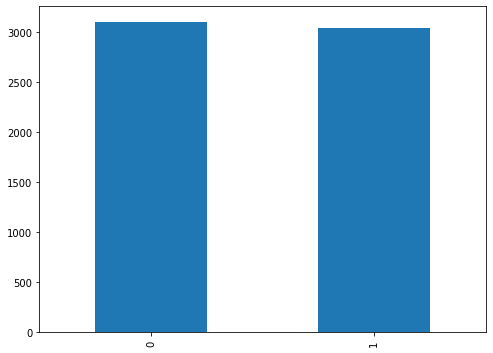

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
kiva_train.defaulted.value_counts().plot.bar(ylim=0)
plt.show()

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Word Cloud of Defaulted = 1')

(-0.5, 799.5, 499.5, -0.5)

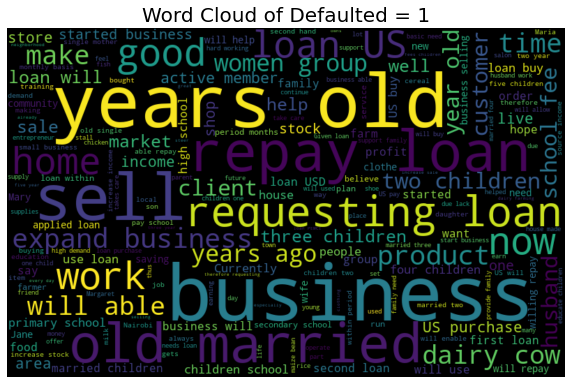

In [6]:
all_words_class1 = ' '.join([text for text in kiva_train[kiva_train['defaulted']==1]['en_clean']])
from wordcloud import WordCloud
wordcloud_class1 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_class1)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_class1, interpolation="bilinear")
plt.title("Word Cloud of Defaulted = 1",fontsize=20)
plt.axis('off')
plt.show()

<Figure size 720x504 with 0 Axes>

Text(0.5, 1.0, 'Word Cloud of Defaulted = 0')

(-0.5, 799.5, 499.5, -0.5)

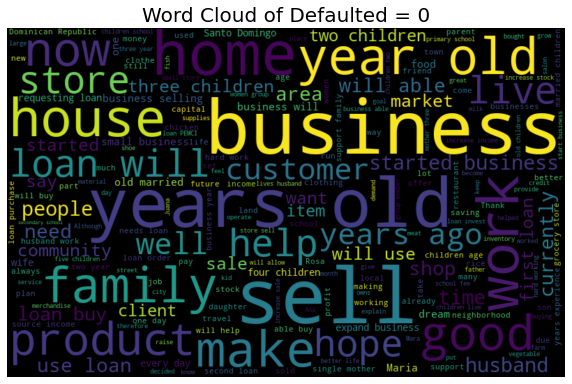

In [7]:
all_words_class2 = ' '.join([text for text in kiva_train[kiva_train['defaulted']==0]['en_clean']])
from wordcloud import WordCloud
wordcloud_class2 = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words_class2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_class2, interpolation="bilinear")
plt.title("Word Cloud of Defaulted = 0", fontsize=20)
plt.axis('off')
plt.show()

# EDA

In [44]:
my_stop_words=  ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an',
 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been',
 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn',
 "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't",
 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from',
 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven',
 "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself',
 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's",
 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more',
 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor',
 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our',
 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't",
 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',
 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them',
 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through',
 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't",
 'we', 'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while',
 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't",
 'y', 'you', "you'd", "you'll", "you're", "you've", 'your', 'yours', 'yourself',
 'yourselves']

In [15]:
from nltk.stem import WordNetLemmatizer
import re
import unidecode

lemmer = WordNetLemmatizer()

def plot_f1_vs_threshold(f1_score, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("F1 Score as a function of the decision threshold")
    plt.plot(thresholds, f1_score, "b--", label="f1_score")
    plt.ylabel("F1_Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# A nice preprocessing function that we can pass to CountVectorizer/TfidfVectorizer
def my_preprocess(doc):
    res = doc.lower()
    # Remove punctuation
    res = re.sub(r'[^\w\s]', '', res)

    # Remove numbers
    res = re.sub(r'\d+', '', res)

    res =' '.join([w for w in res.split() if w not in my_stop_words])

    # Remove any "weird" characters 
    res = unidecode.unidecode(res)
    
    # Lemmatize
    res = ' '.join([lemmer.lemmatize(w) for w in res.split()])

    return res

In [10]:
kiva_train['clean_text'] = kiva_train['en_clean'].map(lambda x: my_preprocess(x))
# kiva_train[['en_clean','clean_text']].head(5)

In [15]:
kiva_train['Num_w_b_preocessing'] = count_word(kiva_train['en_clean'])
kiva_train['Num_w_a_preocessing'] = count_word(kiva_train['clean_text'])

In [ ]:
pd.set_option('display.max_colwidth', -1)

In [16]:
kiva_train[['en_clean', 'clean_text']].head(2)

,en_clean,clean_text
0,"She opened a colmado out of the side of her house. In the Dominican Republic, a colmado is a small, neighborhood general store. Lucia sells several staple food items such as rice, dried beans, cookies and crackers as well as razors, toilet paper and other daily necessities. Her business has been very successful, and she is now on her third Ezperanza loan. Lucia's business has helped put her two children through college. She has a son, age 25, and a daughter, age 23. She is enthusiastic about the success of her business and plans to continue to expand her business as much as possible. The community she lives in loves the convenience of having a colmado in the neighborhood.",she opened colmado side her house dominican republic colmado small neighborhood general store lucia sell several staple food item rice dried bean cooky cracker well razor toilet paper daily necessity her business successful she her third ezperanza loan lucias business helped put her two child college she son age daughter age she enthusiastic success her business plan continue expand her business much possible community she life love convenience colmado neighborhood
1,"(First Loan): Joffre continues to run his locksmith and motorbike repair shop and he has started a new business by offering motorbike transportation services within the sector. Business Development: His income has increased due to the two businesses he runs. He has a solid demand in the repair shop, as well as in his transportation services. His sons help him by driving to of his motorbikes. He just recently bought a motorbike. : He is married and has three sons, who are in school and help him with his business. He has rooms for rent which provide him with monthly income. (Second Loan): He will use the loan to fix the motorbike he bought to provide transportation services and for the maintenance of his other motorbike.",first loan joffre continues run locksmith motorbike repair shop he started new business offering motorbike transportation service within sector business development income increased due two business he run he solid demand repair shop well transportation service son help him driving motorbike he recently bought motorbike he married three son school help him business he room rent provide him monthly income second loan he use loan fix motorbike he bought provide transportation service maintenance motorbike


In [ ]:
plt.figure(figsize=(20,10)) 
plt.hist(kiva_train['Num_w_b_preocessing'], bins=10, alpha=.5)
plt.hist(kiva_train['Num_w_a_preocessing'], bins=10, alpha=.5)
plt.title("Document word count before and after preprocessing", fontsize=20)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

tf_vectorizer = CountVectorizer(min_df=.05, max_df=.5, max_features=no_features, ngram_range=[1,3])
%time dtm_tf = tf_vectorizer.fit_transform(kiva_train['clean_text'])
print(dtm_tf.shape)

In [ ]:
df = pd.DataFrame(dtm_tf.toarray(), columns=tf_vectorizer.get_feature_names())
df.head()

In [ ]:
from yellowbrick.text import FreqDistVisualizer

plt.figure(figsize=(5,8))
visualizer = FreqDistVisualizer(features=tf_vectorizer.get_feature_names(), n=25)
visualizer.fit(dtm_tf)
visualizer.poof()

In [ ]:
# kiva_train['total_words_before_proprocessing']

In [ ]:
#make a list of all the text
loan_text_collection = list(kiva_train['en_clean'][1:2])

from textblob import TextBlob
 
for loan_text in loan_text_collection:
    print(loan_text)
    analysis = TextBlob(loan_text)
    print(analysis.sentiment)#analyse the sentitment
    #Polarity is a value between [-1.0, 1.0] and tells how positive or negative the text is. 
    #Subjectivity is within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.
    print("-"*20)

In [ ]:
kiva_train[["MONEY", "CARDINAL", "PERSON", "GPE", "ORG", "DATE"]] = check_ents_all(kiva_train['en_clean'])
# kiva_full['polarity'] = get_sentiment(kiva_full['en_clean'])
# kiva_train[['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning']] = get_lexical(kiva_train['en_clean'])

In [ ]:
import seaborn as sns
Corr_Plot_df1 = kiva_train[["MONEY", "CARDINAL", "PERSON", "GPE", "ORG", "DATE"]]

Var_Corr1 = Corr_Plot_df1.corr()
Var_Corr1

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

ax = sns.heatmap(
    Var_Corr1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title('Name Entity Correlation heatmap')

In [ ]:
import seaborn as sns
Corr_Plot_df1 = kiva_train[['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning']]

Var_Corr1 = Corr_Plot_df1.corr()
Var_Corr1

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

ax = sns.heatmap(
    Var_Corr1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title('Readability Metric Correlation ')

In [ ]:
kiva_train.head(1)

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("Money").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity MONEY Target Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
kiva_full_features[['defaulted','polarity']].groupby("defaulted").polarity.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("Polarity Comparison")

In [ ]:
kiva_full_features.defaulted.value_counts()

In [ ]:
kiva_full_features[['defaulted','len']].groupby("defaulted").len.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("Text length Comparison")

In [ ]:
kiva_full_features[['defaulted','syll']].groupby("defaulted").syll.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("syllable_count Comparison")

In [ ]:
kiva_full_features[['defaulted','lex']].groupby("defaulted").lex.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("lexicon_count Comparison")

In [ ]:
kiva_full_features[['defaulted','flesch']].groupby("defaulted").flesch.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("flesch_reading_ease Comparison")

In [ ]:
kiva_full_features[['defaulted','kincaid']].groupby("defaulted").kincaid.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("flesch_kincaid_grade Comparison")

In [ ]:
kiva_full_features[['defaulted','gunning']].groupby("defaulted").gunning.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("gunning_fog Comparison")

In [ ]:
kiva_full_features[['defaulted','sent']].groupby("defaulted").sent.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("Sentence Length Comparison")


In [ ]:
kiva_full_features["Gender"] = has_children(kiva_full_features['en_clean'])

In [ ]:
kiva_full_features['defaulted_str'] =kiva_full_features['defaulted'].astype("str")
kiva_full_features[['defaulted','Gender']].groupby("Gender").defaulted.value_counts().unstack(1).plot.bar(ylim=0,figsize=(10,5), legend=True,alpha=0.4)
plt.suptitle("Gender Comparison")
plt.show()

In [ ]:
kiva_full_features[["Date"]] = check_ents_all(kiva_full_features['en_clean'])

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("MONEY").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'MONEY' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("CARDINAL").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'CARDINAL' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("PERSON").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'PERSON' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("GPE").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'GPE' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("ORG").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'ORG' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
kiva_full_features.groupby("Date").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity 'DATE' Comparison")
plt.ylabel("Count")
plt.show()

In [ ]:
kiva_full_features['Has_chidren'] = has_children(kiva_full_features['en_clean'])

In [ ]:
kiva_full_features['defaulted_str'] =kiva_full_features['defaulted'].astype("str")
kiva_full_features[['defaulted','Has_chidren']].groupby("Has_chidren").defaulted.value_counts().unstack(1).plot.bar(ylim=0,figsize=(10,5), legend=True,alpha=0.4)
plt.suptitle("Has_chidren Comparison")
plt.show()

In [ ]:
kiva_full_features['num_stop_words'] = count_stop_word_corpus(kiva_full_features['en_clean'])

In [ ]:
kiva_full_features[['defaulted','num_stop_words']].groupby("defaulted").num_stop_words.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("num_stop_words Comparison")


In [13]:
def count_stop_word(doc):
    count =0
    for i in doc.split(" "):
      if i in my_stop_words:
        count +=1
    return count

def count_stop_word_corpus(corpus):
    res = np.array([count_stop_word(instance) for instance in corpus]).reshape(-1, 1)
    return res


In [ ]:
kiva_train[['Polarity', 'Subjectivity']] = get_sentiment(kiva_train['en_clean'])

In [ ]:
kiva_train[['defaulted','Polarity']].groupby("defaulted").Polarity.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("Polarity Comparison")


In [ ]:
kiva_train[['defaulted','Subjectivity']].groupby("defaulted").Subjectivity.hist(figsize=(10,5), alpha=0.4, bins=20, legend=True)
plt.suptitle("Subjectivity Comparison")

In [ ]:
kiva_train.defaulted.value_counts()

In [ ]:
analysis = TextBlob(" i hate you")

In [ ]:
analysis.sentiment

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

# We can use spacy to show all the named entities in a given document.
doc = nlp(kiva_train.iloc[0].en_clean)
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

# These functions will calculate additional features on the document.
# They will be put into the Pipeline, called via the FunctionTransformer() function.
# Each one takes an entire corpus (as a list of documents), and should return
# an array of feature values (one for each document in the corpus).
# These functions can do anything they want; I've made most of them quick
# one-liners Hopefully the names of the functions will make them self explanitory.

def doc_length(corpus):
    return np.array([len(doc) for doc in corpus]).reshape(-1, 1)

def count_word(corpus):
    return np.array([doc.count(' ')+1 for doc in corpus]).reshape(-1, 1)

def num_exclamation_marks(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1, 1)

import textstat
def get_lexical(corpus):
    res = np.array([len(instance) for instance in corpus]).reshape(-1, 1)
    res = np.c_[res, np.array([textstat.syllable_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.lexicon_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.sentence_count(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_reading_ease(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.flesch_kincaid_grade(instance) for instance in corpus]).reshape(-1, 1)]
    res = np.c_[res, np.array([textstat.gunning_fog(instance) for instance in corpus]).reshape(-1, 1)]
    return res

def check_ents(doc, ents):
    doc_check = nlp(doc)
    count = 0
    for i in doc_check.ents:
        if i.label_ == ents :
            count+=1
    return count

def check_ents_all(corpus):
    res = np.array([check_ents(doc, "MONEY") for doc in corpus]).reshape(-1, 1)
    # res = np.c_[res, np.array([check_ents(doc, "CARDINAL") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "PERSON") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "GPE") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "ORG") for doc in corpus]).reshape(-1, 1)]
    # res = np.c_[res, np.array([check_ents(doc, "DATE") for doc in corpus]).reshape(-1, 1)]
    
    return res

from textblob import TextBlob
def get_sentiment_polarity_score(text):
  analysis = TextBlob(text)
  analysis.sentiment
  return analysis.sentiment[0]

def get_sentiment_subjective_score(text):
  analysis = TextBlob(text)
  analysis.sentiment
  return analysis.sentiment[1]

def get_sentiment(corpus):
    res = np.array([get_sentiment_polarity_score(instance) for instance in corpus]).reshape(-1, 1)
    res = np.c_[res, np.array([get_sentiment_subjective_score(instance) for instance in corpus]).reshape(-1, 1)]
    return res

def get_extra_features(corpus):
    corpus_df = pd.DataFrame(corpus)
    corpus_df = corpus_df.merge(kiva_full[['en_clean','len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning', 'MONEY', 'subjectivity']], on="en_clean", how='left')

    return corpus_df[['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning', 'MONEY', 'subjectivity']].values.tolist()

def check_doc_gender(text):
  male_gender = re.findall("his|His|him|He", text)
  female_gender = re.findall("her|Her|She|she", text)

  if len(male_gender)> len(female_gender):
    return 0
  elif len(female_gender) > len(male_gender):
    return 1
  else:
    return 2

def has_children_doc(text):
  child_match = re.findall("children|grandchild|kids|child|mother|father|son|daughter", text)
  if len(child_match)> 0:
    return 1
  else:
    return 0


def check_gender(corpus):
    res = np.array([check_doc_gender(instance) for instance in corpus]).reshape(-1, 1)
    return res


def has_children(corpus):
    res = np.array([has_children_doc(instance) for instance in corpus]).reshape(-1, 1)
    return res

# Load All Features

In [18]:
df_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1EVWfyqQOd_W2uTKrr4JTD2iFrEZHoOHT")
kiva_full = pd.concat([kiva_train[['loan_id', 'en_clean']],df_test])

In [23]:
not_use_csv=True

if not_use_csv:
  kiva_full[["MONEY"]] = check_ents_all(kiva_full['en_clean'])
  kiva_full[['polarity', 'subjectivity']] = get_sentiment(kiva_full['en_clean'])
  kiva_full[['len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning']] = get_lexical(kiva_full['en_clean'])
else:
  kiva_full=pd.read_csv("/content/Full_data_wtih_features.csv")

In [24]:
del kiva_full['loan_id']
kiva_full = kiva_full.drop_duplicates(subset=['en_clean'])

In [25]:
kiva_full.head(1)

,en_clean,MONEY,polarity,subjectivity,len,syll,lex,sent,flesch,kincaid,gunning
0,"She opened a colmado out of the side of her house. In the Dominican Republic, a colmado is a small, neighborhood general store. Lucia sells several staple food items such as rice, dried beans, cookies and crackers as well as razors, toilet paper and other daily necessities. Her business has been very successful, and she is now on her third Ezperanza loan. Lucia's business has helped put her two children through college. She has a son, age 25, and a daughter, age 23. She is enthusiastic about the success of her business and plans to continue to expand her business as much as possible. The community she lives in loves the convenience of having a colmado in the neighborhood.",0,0.101282,0.405769,680,177,119,8,64.81,7.9,9.32


In [ ]:
# kiva_full.to_csv("Full_data_wtih_features.csv")
# from google.colab import files
# files.download('Full_data_wtih_features.csv')

#Topic Modelling

In [ ]:
kiva_train_topic_modelling = pd.read_csv("https://drive.google.com/uc?export=download&id=1dzzVbgHphbCf7kvq9IKiIhwzmxPbuH4s")
kiva_train_topic_modelling = kiva_train_topic_modelling.dropna()
kiva_train_topic_modelling = kiva_train_topic_modelling.reset_index(drop=True)

In [ ]:
kiva_train_topic_modelling['en_clean'] = kiva_train_topic_modelling['en_clean'].map(lambda x: my_preprocess(x))

In [ ]:
kiva_train_topic_modelling.head(2)

,loan_id,en_clean,defaulted
0,7779,opened colmado side house dominican republic colmado small neighborhood general store lucia sell several staple food item rice dried bean cooky cracker well razor toilet paper daily necessity business successful third ezperanza loan lucias business helped put two child college son age daughter age enthusiastic success business plan continue expand business much possible community life love convenience colmado neighborhood,0
1,2777,first loan joffre continues run locksmith motorbike repair shop started new business offering motorbike transportation service within sector business development income increased due two business run solid demand repair shop well transportation service son help driving motorbike recently bought motorbike married three son school help business room rent provide monthly income second loan use loan fix motorbike bought provide transportation service maintenance motorbike,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

no_features = 1000

tf_vectorizer = CountVectorizer(max_df=0.6, min_df=0.02, 
                                max_features=no_features, ngram_range=[1,3])
%time dtm_tf = tf_vectorizer.fit_transform(kiva_train_topic_modelling['en_clean'])
print(dtm_tf.shape)

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=0.05, 
                                   max_features=no_features, ngram_range=[1,3])
%time dtm_tfidf = tfidf_vectorizer.fit_transform(kiva_train_topic_modelling['en_clean'])
print(dtm_tfidf.shape)

# Choose which of the above we'll use below
dtm = dtm_tf
vectorizer = tf_vectorizer

feature_names = vectorizer.get_feature_names()
def filter_words(x):
    return ' '.join([w for w in x.split() if w in feature_names])

# Create a new column, which is the same as en_clean, but only keeps the 
# words from the vectorizer's vocabulary
%time kiva_train_topic_modelling['en_clean_filter'] = kiva_train_topic_modelling['en_clean'].apply(filter_words)

CPU times: user 2.7 s, sys: 75 ms, total: 2.78 s
Wall time: 2.78 s
(6138, 767)
CPU times: user 2.7 s, sys: 70 ms, total: 2.77 s
Wall time: 2.77 s
(6138, 271)
CPU times: user 3.72 s, sys: 1.99 ms, total: 3.73 s
Wall time: 3.73 s


In [ ]:
def runLDA(dtm, vectorizer, n_components, alpha=None, beta=None):

    lda_model = LatentDirichletAllocation(n_components=n_components,
                                          doc_topic_prior=alpha,
                                          topic_word_prior=beta,
                                          max_iter=200, 
                                          learning_method='batch', 
                                          random_state=123,
                                          n_jobs=2,
                                          verbose=0)
    lda_output = lda_model.fit(dtm)

    # Log Likelyhood: Higher the better
    ll = lda_model.score(dtm)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    perp = lda_model.perplexity(dtm)

    # Theta = document-topic matrix
    # Beta = components_ = topic-term matrix
    theta = pd.DataFrame(lda_model.transform(dtm))
    beta = pd.DataFrame(lda_model.components_)
    
    # Build Topic Summary
    no_top_words = 10
    weight = theta.sum(axis=0)
    support50 = (theta > 0.5).sum(axis=0)
    support10 = (theta > 0.1).sum(axis=0)
    termss = list()
    for topic_id, topic in enumerate(lda_model.components_):
        terms = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        termss.append(terms)
    topic_summary = pd.DataFrame({'TopicID': range(0, len(termss)), "Support50": support50, "Support10": support10, "Weight": weight, "Terms": termss})
    
    return {'model':lda_model, 'theta':theta, 'beta':beta, 'topic_summary':topic_summary, 'll':ll, 'perp':perp}

In [ ]:
%time l10 = runLDA(dtm, vectorizer, 10)

CPU times: user 5.17 s, sys: 761 ms, total: 5.93 s
Wall time: 11min 55s


In [ ]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 0)

from IPython.display import Markdown, display

def print_document(document_id, theta, res):
    str_list = []
    text = kiva_train_topic_modelling['en_clean_filter'].iloc[document_id]
    Topics = theta.iloc[document_id, :].nlargest(3)
    TopicIDs = Topics.index
    
    display(Markdown("###### Top 3 topics"))
    topic_id = TopicIDs[0]
    topic_str=list()
    display(Markdown('- Topic {} ({:.2f}): <span style="color:green;">{}</span>'.format(topic_id, theta.iloc[document_id, topic_id], res['Terms'].iloc[topic_id])))
    topic_id = TopicIDs[1]
    display(Markdown('- Topic {} ({:.2f}): <span style="color:blue;">{}</span>'.format(topic_id, theta.iloc[document_id, topic_id], res['Terms'].iloc[topic_id])))
    topic_id = TopicIDs[2]
    display(Markdown('- Topic {} ({:.2f}): <span style="color:purple;">{}</span>'.format(topic_id, theta.iloc[document_id, topic_id], res['Terms'].iloc[topic_id])))
    
    topic0_words = res['Terms'].iloc[TopicIDs[0]].split()
    topic1_words = res['Terms'].iloc[TopicIDs[1]].split()
    topic2_words = res['Terms'].iloc[TopicIDs[2]].split()

    for word in text.split():
        if word in topic0_words:
            str_list.append('<span style="color:green;font-weight:bold">' + word + '</span>')
        elif word in topic1_words:
            str_list.append('<span style="color:blue;font-weight:bold">' + word + '</span>')
        elif word in topic2_words:
            str_list.append('<span style="color:purple;font-weight:bold">' + word + '</span>')
        else:
            str_list.append('<span style="color:grey">' + word + '</span>')

    display(Markdown("###### Words (After Preprocessing and Filtering) - Highlighted"))
    display(Markdown(' '.join(str_list)))
    
    display(Markdown("###### Words (Original)"))
    display((kiva_train_topic_modelling['en_clean'].iloc[document_id]))
    
    
def show_topics(run):
    
    params = run['model'].get_params()
    display(Markdown("# Run: K={}, Alpha={}, Beta={}, Iters={}".format(
        params['n_components'], 
        params['doc_topic_prior'],
        params['topic_word_prior'],
        params['max_iter'],
    )))
    
    display(run['topic_summary'])
    
    for topic_id in range(run['topic_summary'].shape[0]):
        display(Markdown("## Topic {}".format(topic_id)))
        Memberships = run['theta'].iloc[:, topic_id].nlargest(5)
        DocIDs = Memberships.index
        for doc_id in DocIDs:
            print_document(doc_id, run['theta'], run['topic_summary'])


In [ ]:
display(l10['topic_summary'])

,TopicID,Support50,Support10,Weight,Terms
0,0,312,1364,500.095163,also service customer purchase machine care able two take old
1,1,557,1375,656.254216,group member school woman married usd woman group church active primary
2,2,728,1867,856.083641,school family pay fee able expand buy need income married
3,3,538,1382,630.180717,group life small member one hope woman sell community able
4,4,154,909,313.117675,rice land farm also maize family fish life farming farmer
5,5,489,1684,699.444533,product sell store old year old use home help use loan house
6,6,782,2012,905.525584,work home able husband buy also sell help product order
7,7,67,1588,430.124038,clothes stock sell market increase selling customer shop shoe husband
8,8,128,683,257.147701,dairy cow milk dairy cow per income farming sell usd litre
9,9,904,1567,890.026732,community sell entrepreneur woman buy family clothing good husband small


In [ ]:
l10['theta']

,0,1,2,3,4,5,6,7,8,9
0,0.002632,0.002632,0.002632,0.976309,0.002633,0.002632,0.002633,0.002632,0.002632,0.002632
1,0.506878,0.002001,0.002001,0.002000,0.002000,0.100040,0.379078,0.002000,0.002001,0.002000
2,0.002084,0.002084,0.166233,0.753461,0.065720,0.002084,0.002084,0.002084,0.002084,0.002084
3,0.145415,0.229306,0.614506,0.001539,0.001539,0.001539,0.001539,0.001539,0.001539,0.001539
4,0.001493,0.001493,0.001493,0.001493,0.001493,0.434702,0.415425,0.053300,0.087616,0.001493
...,...,...,...,...,...,...,...,...,...,...
6133,0.001471,0.001471,0.001471,0.001471,0.001471,0.131746,0.856487,0.001471,0.001471,0.001471
6134,0.001191,0.103638,0.646187,0.001191,0.241840,0.001191,0.001191,0.001191,0.001191,0.001191
6135,0.002382,0.002381,0.002381,0.002381,0.002381,0.358021,0.622927,0.002382,0.002381,0.002381
6136,0.002439,0.002439,0.002439,0.002440,0.778474,0.002440,0.202011,0.002439,0.002439,0.002439


In [ ]:
topics = l10['theta']
topics.columns = ['topic_0', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','topic_6', 'topic_7','topic_8', 'topic_9']


In [ ]:
topics.head(1)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.002632,0.002632,0.002632,0.976309,0.002633,0.002632,0.002633,0.002632,0.002632,0.002632


In [ ]:
show_topics(l10)

# Run: K=10, Alpha=None, Beta=None, Iters=200

,TopicID,Support50,Support10,Weight,Terms
0,0,312,1364,500.095163,also service customer purchase machine care able two take old
1,1,557,1375,656.254216,group member school woman married usd woman group church active primary
2,2,728,1867,856.083641,school family pay fee able expand buy need income married
3,3,538,1382,630.180717,group life small member one hope woman sell community able
4,4,154,909,313.117675,rice land farm also maize family fish life farming farmer
5,5,489,1684,699.444533,product sell store old year old use home help use loan house
6,6,782,2012,905.525584,work home able husband buy also sell help product order
7,7,67,1588,430.124038,clothes stock sell market increase selling customer shop shoe husband
8,8,128,683,257.147701,dairy cow milk dairy cow per income farming sell usd litre
9,9,904,1567,890.026732,community sell entrepreneur woman buy family clothing good husband small


## Topic 0

###### Top 3 topics

- Topic 0 (0.99): <span style="color:green;">also service customer purchase machine care able two take old</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 2 (0.00): <span style="color:purple;">school family pay fee able expand buy need income married</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">old</span> <span style="color:grey">single</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">nairobi</span> <span style="color:green;font-weight:bold">also</span> <span style="color:green;font-weight:bold">take</span> <span style="color:green;font-weight:bold">care</span> <span style="color:grey">aged</span> <span style="color:grey">parent</span> <span style="color:grey">trained</span> <span style="color:grey">beauty</span> <span style="color:grey">salon</span> <span style="color:green;font-weight:bold">service</span> <span style="color:grey">started</span> <span style="color:grey">hair</span> <span style="color:grey">salon</span> <span style="color:grey">home</span> <span style="color:grey">district</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">moved</span> <span style="color:grey">nairobi</span> <span style="color:grey">area</span> <span style="color:grey">known</span> <span style="color:grey">however</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">nairobi</span> <span style="color:grey">due</span> <span style="color:grey">since</span> <span style="color:grey">area</span> <span style="color:grey">type</span> <span style="color:grey">therefore</span> <span style="color:grey">decided</span> <span style="color:grey">move</span> <span style="color:grey">salon</span> <span style="color:grey">later</span> <span style="color:grey">due</span> <span style="color:grey">high</span> <span style="color:grey">cost</span> <span style="color:grey">living</span> <span style="color:grey">area</span> <span style="color:grey">high</span> <span style="color:grey">rent</span> <span style="color:purple;font-weight:bold">pay</span> <span style="color:grey">salon</span> <span style="color:grey">space</span> <span style="color:grey">moved</span> <span style="color:grey">thus</span> <span style="color:grey">running</span> <span style="color:grey">beauty</span> <span style="color:grey">salon</span> <span style="color:grey">last</span> <span style="color:grey">four</span> <span style="color:grey">living</span> <span style="color:grey">standard</span> <span style="color:grey">well</span> <span style="color:grey">enabled</span> <span style="color:green;font-weight:bold">take</span> <span style="color:green;font-weight:bold">care</span> <span style="color:grey">aged</span> <span style="color:grey">parent</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">managed</span> <span style="color:grey">provide</span> <span style="color:grey">training</span> <span style="color:grey">employment</span> <span style="color:grey">opportunity</span> <span style="color:grey">young</span> <span style="color:grey">girl</span> <span style="color:grey">area</span> <span style="color:grey">continues</span> <span style="color:grey">receive</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">due</span> <span style="color:grey">good</span> <span style="color:grey">quality</span> <span style="color:green;font-weight:bold">service</span> <span style="color:grey">provides</span> <span style="color:grey">however</span> <span style="color:grey">find</span> <span style="color:grey">unable</span> <span style="color:grey">increasing</span> <span style="color:grey">demand</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">raise</span> <span style="color:grey">amount</span> <span style="color:green;font-weight:bold">purchase</span> <span style="color:grey">necessary</span> <span style="color:grey">item</span> <span style="color:green;font-weight:bold">two</span> <span style="color:grey">six</span> <span style="color:grey">hair</span> <span style="color:grey">oil</span> <span style="color:grey">requesting</span> <span style="color:grey">ksh</span> <span style="color:grey">use</span> <span style="color:green;font-weight:bold">purchase</span> <span style="color:grey">item</span> <span style="color:grey">repayment</span> <span style="color:grey">period</span> <span style="color:grey">month</span> <span style="color:grey">belief</span> <span style="color:grey">new</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">satisfy</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">attract</span> <span style="color:grey">many</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">hope</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">offer</span> <span style="color:grey">training</span> <span style="color:grey">opportunity</span> <span style="color:grey">young</span> <span style="color:grey">woman</span> <span style="color:grey">may</span> <span style="color:grey">wish</span> <span style="color:grey">venture</span> <span style="color:grey">beauty</span> <span style="color:grey">salon</span> <span style="color:grey">many</span> <span style="color:grey">due</span> <span style="color:grey">hard</span> <span style="color:grey">work</span>

###### Words (Original)

'abigail mwongeli year old single life makadara estate nairobi apart also take care aged parent abigail trained beauty salon service specialist started hair salon vicinity home makueni district due lack customer moved nairobi area known jericho however also nairobi experienced difficulty due competition since area dominated type business therefore decided move lumumba estate relocated salon later due high cost living area high rent pay salon space abigail moved business makadara estate settled thus abigail running beauty salon business last four year improved living standard well enabled take care aged parent also managed provide training employment opportunity young girl area abigails business continues receive increasingly customer due good quality service provides however find unable cope increasing demand due lack propper tool equipment unfortunately able raise required amount purchase necessary item two drier six seat assortment hair chemical oil braid abigail requesting loan ksh 

###### Top 3 topics

- Topic 0 (0.99): <span style="color:green;">also service customer purchase machine care able two take old</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 1 (0.00): <span style="color:purple;">group member school woman married usd woman group church active primary</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">old</span> <span style="color:grey">single</span> <span style="color:grey">lady</span> <span style="color:grey">life</span> <span style="color:green;font-weight:bold">two</span> <span style="color:grey">within</span> <span style="color:grey">slum</span> <span style="color:grey">parent</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:green;font-weight:bold">take</span> <span style="color:green;font-weight:bold">care</span> <span style="color:grey">decided</span> <span style="color:grey">look</span> <span style="color:grey">job</span> <span style="color:grey">order</span> <span style="color:grey">make</span> <span style="color:grey">end</span> <span style="color:grey">meet</span> <span style="color:grey">employed</span> <span style="color:grey">town</span> <span style="color:grey">called</span> <span style="color:grey">work</span> <span style="color:grey">long</span> <span style="color:grey">six</span> <span style="color:grey">month</span> <span style="color:grey">decided</span> <span style="color:grey">job</span> <span style="color:grey">took</span> <span style="color:grey">ksh</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:grey">saving</span> <span style="color:grey">used</span> <span style="color:grey">ksh</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:blue;font-weight:bold">pay</span> <span style="color:grey">hair</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">completed</span> <span style="color:grey">eight</span> <span style="color:grey">month</span> <span style="color:grey">started</span> <span style="color:grey">using</span> <span style="color:grey">money</span> <span style="color:grey">saving</span> <span style="color:grey">bought</span> <span style="color:grey">many</span> <span style="color:grey">client</span> <span style="color:grey">lack</span> <span style="color:grey">hair</span> <span style="color:grey">necessary</span> <span style="color:grey">assist</span> <span style="color:grey">therefore</span> <span style="color:grey">asking</span> <span style="color:grey">good</span> <span style="color:grey">ksh</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:grey">hair</span> <span style="color:grey">worth</span> <span style="color:grey">ksh</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:grey">worth</span> <span style="color:grey">ksh</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">back</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">could</span> <span style="color:green;font-weight:bold">service</span> <span style="color:grey">belief</span> <span style="color:grey">current</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">help</span> <span style="color:grey">increase</span> <span style="color:grey">profit</span> <span style="color:grey">better</span> <span style="color:grey">support</span> <span style="color:grey">repayment</span> <span style="color:grey">period</span> <span style="color:grey">month</span>

###### Words (Original)

'yasmin year old single lady child life two sibling orphan within kibera slum parent killed tragic road accident year orphan family take care yasmin decided look job order make end meet year employed housekeeper town called kahawa west didnt work long employer wasnt treating fairly six month decided quit job ups down took ksh usd saving used ksh usd pay hair dressing school completed schooling eight month started business year using money remained saving bought wall mirror blow dryer many client lack hair dryer necessary chemical cant assist therefore yasmin asking good faith loan ksh usd buy hair dryer worth ksh usd blow dryer worth ksh usd equipment able gain back customer could service earlier yasmin belief current customer refer business help increase profit better position support sibling repayment period loan month'

###### Top 3 topics

- Topic 0 (0.99): <span style="color:green;">also service customer purchase machine care able two take old</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">young</span> <span style="color:grey">man</span> <span style="color:grey">aged</span> <span style="color:grey">dream</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">parent</span> <span style="color:grey">within</span> <span style="color:grey">slum</span> <span style="color:grey">nairobi</span> <span style="color:grey">operates</span> <span style="color:purple;font-weight:bold">shop</span> <span style="color:grey">slum</span> <span style="color:grey">skill</span> <span style="color:grey">employed</span> <span style="color:purple;font-weight:bold">shop</span> <span style="color:grey">worked</span> <span style="color:grey">start</span> <span style="color:purple;font-weight:bold">shop</span> <span style="color:grey">saved</span> <span style="color:grey">ksh</span> <span style="color:grey">usd</span> <span style="color:grey">working</span> <span style="color:grey">ksh</span> <span style="color:grey">mother</span> <span style="color:grey">start</span> <span style="color:grey">capital</span> <span style="color:grey">ksh</span> <span style="color:grey">usd</span> <span style="color:grey">bought</span> <span style="color:grey">new</span> <span style="color:grey">secondhand</span> <span style="color:grey">chair</span> <span style="color:grey">using</span> <span style="color:grey">people</span> <span style="color:grey">due</span> <span style="color:grey">client</span> <span style="color:grey">hair</span> <span style="color:grey">day</span> <span style="color:grey">demand</span> <span style="color:grey">high</span> <span style="color:grey">due</span> <span style="color:grey">increased</span> <span style="color:grey">number</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">want</span> <span style="color:purple;font-weight:bold">increase</span> <span style="color:grey">number</span> <span style="color:grey">number</span> <span style="color:grey">bank</span> <span style="color:grey">financial</span> <span style="color:grey">request</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:grey">therefore</span> <span style="color:grey">requesting</span> <span style="color:grey">plan</span> <span style="color:green;font-weight:bold">purchase</span> <span style="color:grey">chair</span> <span style="color:grey">help</span> <span style="color:grey">expand</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">give</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">enable</span> <span style="color:grey">employ</span> <span style="color:green;font-weight:bold">two</span> <span style="color:grey">young</span> <span style="color:grey">men</span> <span style="color:grey">assist</span> <span style="color:grey">client</span> <span style="color:grey">long</span> <span style="color:grey">belief</span> <span style="color:grey">even</span> <span style="color:grey">help</span> <span style="color:purple;font-weight:bold">increase</span> <span style="color:grey">clientele</span> <span style="color:grey">boost</span> <span style="color:grey">income</span> <span style="color:grey">may</span> <span style="color:grey">become</span> <span style="color:grey">young</span> <span style="color:grey">men</span> <span style="color:grey">want</span>

###### Words (Original)

'seima young man aged following dream selfemployed life parent within kiambiu slum nairobi seima operates barbershop name lunimart barber shop kiambiu slum seima acquired barbering skill employed barber shop named kimsa worked year opting start shop saved ksh usd working borrowed ksh u mother initial start capital total ksh usd seima bought new electric razor secondhand mirror chair using date business continued pull people due expertise shaving client hair weekday seima shave head day weekend demand shaving high shave head due increased number customer seima want increase number tool seima previously approached number bank financial assistance turned request due lack collateral seima therefore requesting loan u loan plan purchase electric razor chair mirror help expand business also give customer efficient shave tool enable employ two young men assist business ensuring client wait long seima belief loan even help increase clientele boost income may become beacon fellow young men want 

###### Top 3 topics

- Topic 0 (0.99): <span style="color:green;">also service customer purchase machine care able two take old</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:grey">man</span> <span style="color:blue;font-weight:bold">married</span> <span style="color:green;font-weight:bold">two</span> <span style="color:grey">life</span> <span style="color:grey">within</span> <span style="color:grey">slum</span> <span style="color:grey">nairobi</span> <span style="color:grey">wife</span> <span style="color:green;font-weight:bold">two</span> <span style="color:green;font-weight:bold">take</span> <span style="color:green;font-weight:bold">care</span> <span style="color:grey">four</span> <span style="color:grey">brother</span> <span style="color:grey">five</span> <span style="color:grey">sister</span> <span style="color:grey">earns</span> <span style="color:grey">operating</span> <span style="color:grey">salon</span> <span style="color:grey">small</span> <span style="color:grey">village</span> <span style="color:grey">within</span> <span style="color:grey">slum</span> <span style="color:grey">operation</span> <span style="color:grey">last</span> <span style="color:grey">received</span> <span style="color:grey">hair</span> <span style="color:grey">skill</span> <span style="color:grey">father</span> <span style="color:grey">salon</span> <span style="color:grey">part</span> <span style="color:grey">kenya</span> <span style="color:grey">worked</span> <span style="color:grey">would</span> <span style="color:grey">lady</span> <span style="color:grey">hair</span> <span style="color:grey">give</span> <span style="color:grey">men</span> <span style="color:grey">saving</span> <span style="color:grey">ksh</span> <span style="color:grey">father</span> <span style="color:grey">kind</span> <span style="color:grey">rent</span> <span style="color:grey">room</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:green;font-weight:bold">machine</span> <span style="color:grey">say</span> <span style="color:grey">happy</span> <span style="color:grey">client</span> <span style="color:grey">hair</span> <span style="color:grey">known</span> <span style="color:grey">right</span> <span style="color:grey">away</span> <span style="color:grey">good</span> <span style="color:grey">number</span> <span style="color:grey">client</span> <span style="color:grey">cannot</span> <span style="color:grey">meet</span> <span style="color:grey">growing</span> <span style="color:grey">demand</span> <span style="color:grey">many</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">therefore</span> <span style="color:grey">requesting</span> <span style="color:grey">repaid</span> <span style="color:grey">within</span> <span style="color:grey">month</span> <span style="color:grey">use</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:grey">job</span> <span style="color:grey">opportunity</span> <span style="color:grey">people</span> <span style="color:grey">therefore</span> <span style="color:grey">poverty</span> <span style="color:grey">within</span> <span style="color:grey">community</span>

###### Words (Original)

'joseph otieno osiolo yearold man married two child life within kibera slum nairobi apart wife two child joseph take care nine orphan four child brother five sister victim aid pandemic joseph earns livelihood operating salon barbershop raila small village within kibera slum operation last year joseph received hair dressing skill father salon barbershop ahero western part kenya worked year would blow dry straightening perm chemical application straightening lady hair give haircut men joseph pooled saving ksh father kind donation rent room buy blowdryer shaving machine say happy seeing client beam joy hair joseph fame kibera known right turning away good number client hairdryer blowdryer cannot meet growing demand many customer therefore joseph requesting loan repaid within month use buy hairdryer blowdryer tool translate income business turn create job opportunity people therefore alleviating poverty within community'

###### Top 3 topics

- Topic 0 (0.99): <span style="color:green;">also service customer purchase machine care able two take old</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 1 (0.00): <span style="color:purple;">group member school woman married usd woman group church active primary</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">old</span> <span style="color:grey">lady</span> <span style="color:blue;font-weight:bold">married</span> <span style="color:grey">life</span> <span style="color:grey">within</span> <span style="color:grey">slum</span> <span style="color:grey">experience</span> <span style="color:grey">working</span> <span style="color:grey">several</span> <span style="color:grey">salon</span> <span style="color:grey">decided</span> <span style="color:grey">start</span> <span style="color:grey">first</span> <span style="color:grey">worked</span> <span style="color:grey">part</span> <span style="color:grey">kenya</span> <span style="color:grey">nairobi</span> <span style="color:grey">nairobi</span> <span style="color:grey">employed</span> <span style="color:grey">salon</span> <span style="color:grey">skill</span> <span style="color:grey">time</span> <span style="color:grey">managed</span> <span style="color:grey">save</span> <span style="color:grey">money</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">started</span> <span style="color:grey">salon</span> <span style="color:grey">salon</span> <span style="color:grey">small</span> <span style="color:grey">shop</span> <span style="color:grey">started</span> <span style="color:grey">order</span> <span style="color:grey">supplement</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:grey">lack</span> <span style="color:grey">salon</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">since</span> <span style="color:grey">equipment</span> <span style="color:grey">go</span> <span style="color:green;font-weight:bold">service</span> <span style="color:grey">salon</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:blue;font-weight:bold">need</span> <span style="color:grey">would</span> <span style="color:grey">love</span> <span style="color:grey">give</span> <span style="color:green;font-weight:bold">service</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">therefore</span> <span style="color:grey">requesting</span> <span style="color:purple;font-weight:bold">usd</span> <span style="color:grey">enable</span> <span style="color:green;font-weight:bold">purchase</span> <span style="color:grey">enable</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:blue;font-weight:bold">need</span> <span style="color:grey">salon</span> <span style="color:grey">equipment</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">earn</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:grey">use</span> <span style="color:grey">maintain</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">intends</span> <span style="color:grey">repay</span> <span style="color:grey">month</span>

###### Words (Original)

'susan awino year old lady married child life within kibera slum susan extensive experience hairdressing gained working several salon decided start first worked webuye western part kenya year relocating nairobi settling nairobi employed salon year admired excellent braiding skill time managed save money braiding customer started salon february adjacent salon small candy shop started order supplement income susan lack blow dryer dryer salon equipment considers essential noticed customer avoiding since equipment go service salon equipment customer frequenting need braiding would love give complete service customer susan therefore requesting loan usd enable purchase blow dryer dryer enable fulfill customer need avoid hijacked salon equipment also earn income use maintain customer susan intends repay loan month'

## Topic 1

###### Top 3 topics

- Topic 1 (0.99): <span style="color:green;">group member school woman married usd woman group church active primary</span>

- Topic 7 (0.00): <span style="color:blue;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:grey">widow</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">ack</span> <span style="color:green;font-weight:bold">church</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">mother</span> <span style="color:green;font-weight:bold">church</span> <span style="color:grey">main</span> <span style="color:grey">assist</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">especially</span> <span style="color:grey">come</span> <span style="color:grey">poor</span> <span style="color:grey">family</span> <span style="color:purple;font-weight:bold">help</span> <span style="color:grey">get</span> <span style="color:grey">education</span> <span style="color:grey">community</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:green;font-weight:bold">member</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">enabled</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">save</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">every</span> <span style="color:grey">month</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">credit</span> <span style="color:grey">life</span> <span style="color:purple;font-weight:bold">able</span> <span style="color:grey">run</span> <span style="color:blue;font-weight:bold">shop</span> <span style="color:grey">requires</span> <span style="color:grey">capital</span> <span style="color:grey">received</span> <span style="color:grey">several</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">enable</span> <span style="color:grey">run</span> <span style="color:grey">meat</span> <span style="color:grey">nearby</span> <span style="color:green;font-weight:bold">primary</span> <span style="color:grey">secondary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">wish</span> <span style="color:purple;font-weight:bold">buy</span> <span style="color:grey">employ</span> <span style="color:grey">farm</span> <span style="color:grey">hand</span> <span style="color:grey">assist</span> <span style="color:grey">intends</span> <span style="color:grey">period</span> <span style="color:grey">month</span> <span style="color:blue;font-weight:bold">sell</span> <span style="color:grey">applied</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">enable</span> <span style="color:purple;font-weight:bold">buy</span> <span style="color:grey">approved</span> <span style="color:grey">repay</span> <span style="color:grey">within</span> <span style="color:grey">period</span> <span style="color:grey">month</span>

###### Words (Original)

'gladys year old widow grownup child gladys member kiambugi ack church also member mother union church gladyss main calling assist le fortunate member society especially child come poor family help get education assistance community gladys also member gaitheri graceful woman group group enabled member save usd every month member appreciate role credit component played life example gladys able run butcher shop business requires substantial capital gladys received several loan group enable run business delivers meat nearby boarding primary secondary school gladys wish buy mediumsized steer employ farm hand assist rear steer intends rear period month slaughter sell slaughterhouse applied loan usd enable buy steer loan committee approved loan repay loan within period month'

###### Top 3 topics

- Topic 1 (0.99): <span style="color:green;">group member school woman married usd woman group church active primary</span>

- Topic 5 (0.00): <span style="color:blue;">product sell store old year old use home help use loan house</span>

- Topic 9 (0.00): <span style="color:purple;">community sell entrepreneur woman buy family clothing good husband small</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">married</span> <span style="color:grey">five</span> <span style="color:grey">two</span> <span style="color:grey">college</span> <span style="color:grey">two</span> <span style="color:grey">secondary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:green;font-weight:bold">primary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">also</span> <span style="color:grey">college</span> <span style="color:grey">study</span> <span style="color:green;font-weight:bold">active</span> <span style="color:green;font-weight:bold">member</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">also</span> <span style="color:grey">attends</span> <span style="color:green;font-weight:bold">church</span> <span style="color:grey">service</span> <span style="color:green;font-weight:bold">church</span> <span style="color:grey">started</span> <span style="color:grey">four</span> <span style="color:grey">ago</span> <span style="color:blue;font-weight:bold">sell</span> <span style="color:grey">market</span> <span style="color:grey">nairobi</span> <span style="color:grey">sometimes</span> <span style="color:purple;font-weight:bold">small</span> <span style="color:blue;font-weight:bold">house</span> <span style="color:grey">build</span> <span style="color:blue;font-weight:bold">house</span> <span style="color:grey">town</span> <span style="color:grey">got</span> <span style="color:grey">order</span> <span style="color:blue;font-weight:bold">sell</span> <span style="color:grey">therefore</span> <span style="color:grey">applied</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:purple;font-weight:bold">buy</span> <span style="color:grey">willing</span> <span style="color:grey">repay</span> <span style="color:grey">within</span> <span style="color:grey">period</span> <span style="color:grey">month</span>

###### Words (Original)

'emily dama married five child two college two secondary school primary school also went college pursued study active member namelok woman group also attends church service baptist church noosuyian emily started beadwork business four year ago sell bead maasai market nairobi sometimes mombasa emilys business assisted acquire small concrete house build rental house isinya town emily twelve goat emily got order sell bead therefore applied loan usd buy bead willing repay loan within period month'

###### Top 3 topics

- Topic 1 (0.99): <span style="color:green;">group member school woman married usd woman group church active primary</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 8 (0.00): <span style="color:purple;">dairy cow milk dairy cow per income farming sell usd litre</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">eight</span> <span style="color:grey">two</span> <span style="color:grey">secondary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">five</span> <span style="color:green;font-weight:bold">primary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">one</span> <span style="color:grey">still</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">active</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">st</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">grows</span> <span style="color:blue;font-weight:bold">maize</span> <span style="color:grey">bean</span> <span style="color:grey">variety</span> <span style="color:grey">vegetable</span> <span style="color:blue;font-weight:bold">farmer</span> <span style="color:grey">mainly</span> <span style="color:grey">crop</span> <span style="color:blue;font-weight:bold">farming</span> <span style="color:grey">four</span> <span style="color:blue;font-weight:bold">farm</span> <span style="color:grey">produce</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">sold</span> <span style="color:grey">retailer</span> <span style="color:grey">local</span> <span style="color:grey">local</span> <span style="color:grey">market</span> <span style="color:grey">applied</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">use</span> <span style="color:grey">purchase</span> <span style="color:grey">approved</span> <span style="color:grey">willing</span> <span style="color:grey">repay</span> <span style="color:grey">within</span> <span style="color:grey">month</span>

###### Words (Original)

'jane nyambura mwangi year old married eight child two secondary school five primary school one still young child active member st monica woman group grows maize bean variety vegetable farmer mainly crop farming pig rearing four pig farm produce consumed family sold retailer local consumer local market applied loan usd use purchase pig loan committee approved loan willing repay loan within month'

###### Top 3 topics

- Topic 1 (0.99): <span style="color:green;">group member school woman married usd woman group church active primary</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 4 (0.00): <span style="color:purple;">rice land farm also maize family fish life farming farmer</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">member</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">group</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:grey">known</span> <span style="color:grey">number</span> <span style="color:grey">provide</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">repayment</span> <span style="color:grey">repay</span> <span style="color:blue;font-weight:bold">one</span> <span style="color:grey">person</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">make</span> <span style="color:grey">payment</span> <span style="color:grey">amount</span> <span style="color:grey">kiva</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">mother</span> <span style="color:grey">four</span> <span style="color:green;font-weight:bold">active</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">joined</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">five</span> <span style="color:grey">ago</span> <span style="color:grey">saving</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">time</span> <span style="color:grey">training</span> <span style="color:grey">given</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">bought</span> <span style="color:grey">three</span> <span style="color:grey">later</span> <span style="color:grey">sold</span> <span style="color:grey">profit</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">currently</span> <span style="color:grey">raising</span> <span style="color:grey">four</span> <span style="color:grey">sold</span> <span style="color:grey">two</span> <span style="color:grey">month</span> <span style="color:grey">time</span> <span style="color:grey">ready</span> <span style="color:grey">market</span> <span style="color:grey">nairobi</span> <span style="color:grey">nearby</span> <span style="color:grey">town</span>

###### Words (Original)

'business member enkakenya woman group group lending also known solidarity lending mechanism allows number individual provide collateral guarantee loan group repayment pledge incentive repay based peer pressure one person group default group member make payment amount kiva staff mokoine married mother four active member enkakenya rule controller disciplined hardworkingtraditionally masai cattle keeper joined group five year ago saving group time attended livestock training thereafter given loan usd bought three steer later sold profit usd currently raising four steer hopefully sold two month time ready market nairobi nearby town'

###### Top 3 topics

- Topic 1 (0.99): <span style="color:green;">group member school woman married usd woman group church active primary</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 8 (0.00): <span style="color:purple;">dairy cow milk dairy cow per income farming sell usd litre</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">ten</span> <span style="color:green;font-weight:bold">married</span> <span style="color:green;font-weight:bold">active</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">st</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">group</span> <span style="color:blue;font-weight:bold">also</span> <span style="color:green;font-weight:bold">active</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">ack</span> <span style="color:green;font-weight:bold">church</span> <span style="color:grey">grows</span> <span style="color:blue;font-weight:bold">maize</span> <span style="color:grey">bean</span> <span style="color:grey">banana</span> <span style="color:grey">variety</span> <span style="color:grey">vegetable</span> <span style="color:blue;font-weight:bold">farmer</span> <span style="color:grey">mainly</span> <span style="color:grey">crop</span> <span style="color:blue;font-weight:bold">farming</span> <span style="color:grey">grocery</span> <span style="color:grey">local</span> <span style="color:grey">centre</span> <span style="color:blue;font-weight:bold">farm</span> <span style="color:grey">produce</span> <span style="color:grey">part</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:purple;font-weight:bold">sell</span> <span style="color:grey">retailer</span> <span style="color:grey">local</span> <span style="color:grey">local</span> <span style="color:grey">market</span> <span style="color:grey">applied</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">intends</span> <span style="color:grey">purchase</span> <span style="color:grey">approved</span> <span style="color:grey">willing</span> <span style="color:grey">repay</span> <span style="color:grey">within</span> <span style="color:grey">month</span>

###### Words (Original)

'lilian wanjiru wathome year old married ten child married active member treasurer st monica woman group also active member ack church grows maize bean banana variety vegetable farmer mainly crop farming pig rearing green grocery business local shopping centre farm produce consumed part family lilian sell remainder retailer local consumer local market applied loan usd intends purchase pig loan committee approved loan willing repay loan within month'

## Topic 2

###### Top 3 topics

- Topic 2 (0.99): <span style="color:green;">school family pay fee able expand buy need income married</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">two</span> <span style="color:grey">lady</span> <span style="color:purple;font-weight:bold">selling</span> <span style="color:blue;font-weight:bold">husband</span> <span style="color:grey">live</span> <span style="color:grey">house</span> <span style="color:grey">nakuru</span> <span style="color:blue;font-weight:bold">also</span> <span style="color:grey">support</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">little</span> <span style="color:grey">earn</span> <span style="color:grey">young</span> <span style="color:grey">woman</span> <span style="color:grey">finish</span> <span style="color:grey">study</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">find</span> <span style="color:grey">source</span> <span style="color:green;font-weight:bold">income</span> <span style="color:grey">lack</span> <span style="color:grey">enough</span> <span style="color:grey">capital</span> <span style="color:grey">made</span> <span style="color:grey">venture</span> <span style="color:purple;font-weight:bold">selling</span> <span style="color:grey">local</span> <span style="color:grey">seven</span> <span style="color:grey">thus</span> <span style="color:grey">good</span> <span style="color:grey">experience</span> <span style="color:grey">want</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">provide</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">ensure</span> <span style="color:grey">get</span> <span style="color:grey">good</span> <span style="color:grey">education</span> <span style="color:grey">raise</span> <span style="color:grey">living</span> <span style="color:grey">standard</span> <span style="color:grey">however</span> <span style="color:grey">capital</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:grey">thus</span> <span style="color:grey">requesting</span> <span style="color:grey">plan</span> <span style="color:grey">money</span> <span style="color:grey">follows</span> <span style="color:grey">get</span> <span style="color:grey">place</span> <span style="color:purple;font-weight:bold">selling</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">transport</span> <span style="color:grey">get</span> <span style="color:grey">license</span> <span style="color:grey">determined</span> <span style="color:grey">hardworking</span> <span style="color:grey">young</span> <span style="color:grey">lady</span> <span style="color:grey">thus</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">repay</span>

###### Words (Original)

'minipher nyambune omambia year old married two child business lady selling charcoal husband auto mechanic live tworoomed house nakuru also support extended family little earn young woman finish study due lack fee minipher find source income lack enough capital made venture business selling charcoal local inhabitant business almost seven year thus good experience business minipher want expand business able provide family ensure child get good education raise living standard however capital expand business thus requesting loan u plan spend money follows u get place selling charcoal u buy charcoal u transport u get license minipher energetic determined hardworking young lady thus able repay loan'

###### Top 3 topics

- Topic 2 (0.99): <span style="color:green;">school family pay fee able expand buy need income married</span>

- Topic 1 (0.00): <span style="color:blue;">group member school woman married usd woman group church active primary</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">mary</span> <span style="color:grey">yearold</span> <span style="color:grey">businesswoman</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">mother</span> <span style="color:purple;font-weight:bold">one</span> <span style="color:green;font-weight:bold">school</span> <span style="color:purple;font-weight:bold">life</span> <span style="color:grey">nakuru</span> <span style="color:grey">town</span> <span style="color:grey">together</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">mary</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">parent</span> <span style="color:grey">support</span> <span style="color:grey">study</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:grey">money</span> <span style="color:grey">got</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">husband</span> <span style="color:purple;font-weight:bold">small</span> <span style="color:green;font-weight:bold">income</span> <span style="color:grey">cater</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">selling</span> <span style="color:grey">banana</span> <span style="color:grey">husband</span> <span style="color:grey">earns</span> <span style="color:green;font-weight:bold">income</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">live</span> <span style="color:grey">standard</span> <span style="color:purple;font-weight:bold">life</span> <span style="color:grey">mary</span> <span style="color:grey">customer</span> <span style="color:grey">especially</span> <span style="color:grey">juice</span> <span style="color:grey">however</span> <span style="color:grey">face</span> <span style="color:grey">challenge</span> <span style="color:grey">like</span> <span style="color:grey">lack</span> <span style="color:grey">fund</span> <span style="color:grey">high</span> <span style="color:grey">transport</span> <span style="color:grey">cost</span> <span style="color:grey">get</span> <span style="color:grey">banana</span> <span style="color:grey">kenya</span> <span style="color:grey">therefore</span> <span style="color:grey">requesting</span> <span style="color:grey">follows</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">banana</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:grey">transport</span> <span style="color:grey">cost</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">mary</span> <span style="color:grey">determined</span> <span style="color:grey">lady</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">repay</span>

###### Words (Original)

'mary wanjiru karubiu yearold businesswoman married mother one child school life nakuru town together nuclear family mary dropped school parent couldnt support study due lack money got married realized husband small income inadequate cater family ventured business selling banana separately husband business earns income able live standard life mary target customer especially business blend juice however face challenge like lack fund high transport cost get banana kenya uganda border therefore requesting loan spend follows buy banana pay transport cost pay municipal council fee mary determined lady able repay loan'

###### Top 3 topics

- Topic 2 (0.99): <span style="color:green;">school family pay fee able expand buy need income married</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 1 (0.00): <span style="color:purple;">group member school woman married usd woman group church active primary</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:purple;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">five</span> <span style="color:grey">one</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">going</span> <span style="color:grey">still</span> <span style="color:grey">husband</span> <span style="color:grey">man</span> <span style="color:grey">selling</span> <span style="color:grey">main</span> <span style="color:grey">market</span> <span style="color:grey">great</span> <span style="color:grey">help</span> <span style="color:grey">since</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">educate</span> <span style="color:blue;font-weight:bold">also</span> <span style="color:grey">take</span> <span style="color:grey">care</span> <span style="color:grey">one</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">high</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">level</span> <span style="color:grey">due</span> <span style="color:grey">lack</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">thus</span> <span style="color:grey">decided</span> <span style="color:grey">venture</span> <span style="color:grey">face</span> <span style="color:grey">various</span> <span style="color:grey">challenge</span> <span style="color:grey">lack</span> <span style="color:grey">enough</span> <span style="color:grey">fund</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:grey">high</span> <span style="color:grey">transportation</span> <span style="color:grey">cost</span> <span style="color:grey">fruit</span> <span style="color:grey">lack</span> <span style="color:grey">premise</span> <span style="color:grey">want</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:grey">lack</span> <span style="color:grey">fund</span> <span style="color:grey">requested</span> <span style="color:grey">budget</span> <span style="color:grey">follows</span> <span style="color:grey">add</span> <span style="color:grey">stock</span> <span style="color:grey">cater</span> <span style="color:grey">transport</span> <span style="color:purple;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">repay</span> <span style="color:grey">time</span>

###### Words (Original)

'agnes menyi kamau year old woman married five child one school going rest still underage husband business man involved business selling mango main market business great help since able educate child also take care younger one drop school high school level due lack fee thus decided venture mango business business sometime face various challenge lack enough fund expand business combat high transportation cost scarcity fruit seasonal lack permanent business premise agnes want expand business lack fund requested u budget follows u add stock u cater transport business oriented woman ambitious able repay loan time'

###### Top 3 topics

- Topic 2 (0.99): <span style="color:green;">school family pay fee able expand buy need income married</span>

- Topic 9 (0.00): <span style="color:blue;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">six</span> <span style="color:grey">two</span> <span style="color:grey">still</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">four</span> <span style="color:grey">completed</span> <span style="color:grey">study</span> <span style="color:grey">lady</span> <span style="color:grey">operating</span> <span style="color:grey">grocery</span> <span style="color:grey">stall</span> <span style="color:grey">open</span> <span style="color:grey">market</span> <span style="color:grey">long</span> <span style="color:grey">time</span> <span style="color:grey">left</span> <span style="color:grey">take</span> <span style="color:grey">care</span> <span style="color:blue;font-weight:bold">husband</span> <span style="color:grey">left</span> <span style="color:grey">two</span> <span style="color:grey">educate</span> <span style="color:grey">working</span> <span style="color:grey">hard</span> <span style="color:green;font-weight:bold">able</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:grey">us</span> <span style="color:grey">earns</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:green;font-weight:bold">school</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">education</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">hard</span> <span style="color:grey">ensure</span> <span style="color:grey">two</span> <span style="color:grey">get</span> <span style="color:grey">best</span> <span style="color:grey">requesting</span> <span style="color:grey">use</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">stock</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:grey">local</span> <span style="color:grey">license</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">stall</span> <span style="color:grey">already</span> <span style="color:purple;font-weight:bold">order</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">use</span> <span style="color:grey">money</span> <span style="color:purple;font-weight:bold">order</span> <span style="color:grey">hardworking</span> <span style="color:grey">paying</span> <span style="color:grey">back</span>

###### Words (Original)

'jecinta muthoni kamau year old married six child two still school four completed study business lady operating green grocery stall open air market long time left take care child husband resorted drinking left two child educate appreciates independent working hard ever beg able expand business us earns pay school fee fact education expensive motivates work hard ensure two child get best requesting loan u use u buy stock u pay local government authority license fee u reinforce stall already pending order school institution use money finance order hardworking organized capable paying back loan'

###### Top 3 topics

- Topic 2 (0.99): <span style="color:green;">school family pay fee able expand buy need income married</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 0 (0.00): <span style="color:purple;">also service customer purchase machine care able two take old</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">aged</span> <span style="color:green;font-weight:bold">married</span> <span style="color:grey">one</span> <span style="color:grey">still</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">earns</span> <span style="color:grey">living</span> <span style="color:grey">selling</span> <span style="color:grey">secondhand</span> <span style="color:grey">support</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">client</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">source</span> <span style="color:grey">secondhand</span> <span style="color:grey">due</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">university</span> <span style="color:grey">education</span> <span style="color:grey">determined</span> <span style="color:blue;font-weight:bold">work</span> <span style="color:grey">hard</span> <span style="color:grey">provide</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">son</span> <span style="color:grey">still</span> <span style="color:grey">young</span> <span style="color:grey">go</span> <span style="color:green;font-weight:bold">school</span> <span style="color:grey">already</span> <span style="color:grey">planning</span> <span style="color:grey">save</span> <span style="color:grey">college</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">getting</span> <span style="color:grey">used</span> <span style="color:grey">support</span> <span style="color:green;font-weight:bold">family</span> <span style="color:blue;font-weight:bold">order</span> <span style="color:grey">make</span> <span style="color:grey">dream</span> <span style="color:grey">come</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:green;font-weight:bold">expand</span> <span style="color:grey">lack</span> <span style="color:grey">capital</span> <span style="color:grey">requesting</span> <span style="color:purple;font-weight:bold">purchase</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:grey">transport</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:green;font-weight:bold">fee</span> <span style="color:grey">hardworking</span> <span style="color:grey">responsible</span> <span style="color:grey">want</span> <span style="color:grey">support</span> <span style="color:green;font-weight:bold">family</span> <span style="color:green;font-weight:bold">pay</span> <span style="color:grey">back</span>

###### Words (Original)

'joseph ruhari njoroge aged year married one child still school joseph earns living selling secondhand pullover support family meager return joseph understands client able source stylish secondhand pullover due fact able attain university education determined work hard provide family son still young go school already planning save college fee return getting business presently used support family order make dream come true would like expand business lack capital requesting loan u u purchase bale pullover u pay transport u pay annual municipal fee joseph hardworking responsible want fully support family pay back loan'

## Topic 3

###### Top 3 topics

- Topic 3 (0.99): <span style="color:green;">group life small member one hope woman sell community able</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 0 (0.00): <span style="color:purple;">also service customer purchase machine care able two take old</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">maria</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">life</span> <span style="color:green;font-weight:bold">small</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">outskirt</span> <span style="color:grey">san</span> <span style="color:grey">de</span> <span style="color:grey">dominican</span> <span style="color:grey">republic</span> <span style="color:green;font-weight:bold">life</span> <span style="color:purple;font-weight:bold">two</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">age</span> <span style="color:grey">little</span> <span style="color:grey">home</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">offer</span> <span style="color:grey">fried</span> <span style="color:grey">food</span> <span style="color:green;font-weight:bold">member</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">invest</span> <span style="color:grey">money</span> <span style="color:grey">buying</span> <span style="color:grey">merchandise</span> <span style="color:grey">capital</span> <span style="color:grey">hand</span> <span style="color:grey">buy</span> <span style="color:grey">vegetable</span> <span style="color:grey">meat</span> <span style="color:grey">goal</span> <span style="color:grey">continue</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">day</span> <span style="color:grey">restaurant</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">good</span> <span style="color:grey">goal</span> <span style="color:grey">house</span> <span style="color:grey">may</span> <span style="color:grey">help</span> <span style="color:purple;font-weight:bold">take</span> <span style="color:grey">better</span> <span style="color:purple;font-weight:bold">care</span> <span style="color:blue;font-weight:bold">also</span> <span style="color:grey">first</span> <span style="color:grey">time</span> <span style="color:green;font-weight:bold">life</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">start</span> <span style="color:grey">saving</span> <span style="color:grey">dream</span> <span style="color:grey">maria</span> <span style="color:grey">bank</span> <span style="color:green;font-weight:bold">hope</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">men</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">work</span> <span style="color:grey">hard</span> <span style="color:grey">improve</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">help</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">men</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">taken</span> <span style="color:grey">maria</span>

###### Words (Original)

'maria florentino spirited young woman life small community outskirt san pedro de macoris dominican republic life two small child age tiny little home maria small business offer fried food member community asked loan invest money business buying merchandise includes capital hand periodically buy vegetable meat fry goal continue expanding business one day restaurant spot sell good lifelong goal house think finally may possible help loan take better care child also first time life able start saving towards dream maria story represent dios verdadero bank hope belongs group men woman work hard improve life help small loan men woman taken similar loan maria'

###### Top 3 topics

- Topic 3 (0.99): <span style="color:green;">group life small member one hope woman sell community able</span>

- Topic 9 (0.00): <span style="color:blue;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 4 (0.00): <span style="color:purple;">rice land farm also maize family fish life farming farmer</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">maria</span> <span style="color:grey">like</span> <span style="color:grey">day</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">hand</span> <span style="color:grey">provide</span> <span style="color:grey">maria</span> <span style="color:blue;font-weight:bold">husband</span> <span style="color:grey">live</span> <span style="color:grey">dominican</span> <span style="color:grey">republic</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">made</span> <span style="color:grey">sugar</span> <span style="color:grey">provide</span> <span style="color:grey">seven</span> <span style="color:grey">currently</span> <span style="color:grey">living</span> <span style="color:grey">house</span> <span style="color:grey">others</span> <span style="color:grey">still</span> <span style="color:grey">dream</span> <span style="color:grey">home</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">day</span> <span style="color:grey">supporting</span> <span style="color:grey">time</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">one</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">person</span> <span style="color:grey">mean</span> <span style="color:grey">town</span> <span style="color:grey">dominican</span> <span style="color:blue;font-weight:bold">entrepreneur</span> <span style="color:grey">access</span> <span style="color:grey">would</span> <span style="color:grey">never</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">receive</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">bank</span> <span style="color:grey">paying</span> <span style="color:grey">together</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">person</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">help</span> <span style="color:grey">cover</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">payment</span> <span style="color:grey">order</span> <span style="color:grey">receive</span> <span style="color:grey">next</span> <span style="color:grey">together</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">bank</span> <span style="color:grey">make</span> <span style="color:grey">living</span> <span style="color:grey">selling</span> <span style="color:blue;font-weight:bold">clothing</span> <span style="color:grey">running</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">salon</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">owns</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">store</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">basic</span> <span style="color:grey">grocery</span>

###### Words (Original)

'maria jean batiste understands like struggle survive day life hand mouth try provide child immigrant haiti maria husband wilson live puerto plata dominican republic maria sell sweet made cocoa peanut sugar provide seven child currently living house others still haiti dream owning home one day primarily concerned supporting child time maria jean batiste one member person microbank villa ascencion mean ascended town unique dominican entrepreneur unite solidarity allowing access funding would otherwise never able receive concept group bank paying loan together reduce risk one person defaulting member gladly help cover one anothers payment order receive next loan together woman particular bank make living selling clothing running small salon one owns small colmado store sell basic grocery snack'

###### Top 3 topics

- Topic 3 (0.99): <span style="color:green;">group life small member one hope woman sell community able</span>

- Topic 7 (0.00): <span style="color:blue;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">de</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">hoping</span> <span style="color:grey">receive</span> <span style="color:green;font-weight:bold">member</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">already</span> <span style="color:grey">success</span> <span style="color:green;font-weight:bold">small</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">hoping</span> <span style="color:blue;font-weight:bold">increase</span> <span style="color:grey">continue</span> <span style="color:grey">improve</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">good</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">three</span> <span style="color:grey">previous</span> <span style="color:grey">paid</span> <span style="color:grey">back</span> <span style="color:grey">time</span> <span style="color:green;font-weight:bold">group</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">hard</span> <span style="color:grey">worker</span> <span style="color:grey">mother</span> <span style="color:grey">five</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">hard</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">support</span> <span style="color:grey">range</span> <span style="color:grey">age</span> <span style="color:grey">way</span> <span style="color:grey">first</span> <span style="color:grey">three</span> <span style="color:grey">started</span> <span style="color:grey">successful</span> <span style="color:blue;font-weight:bold">selling</span> <span style="color:grey">always</span> <span style="color:grey">great</span> <span style="color:grey">took</span> <span style="color:grey">first</span> <span style="color:blue;font-weight:bold">increase</span> <span style="color:grey">good</span> <span style="color:green;font-weight:bold">hope</span> <span style="color:grey">continue</span> <span style="color:grey">increasing</span> <span style="color:grey">want</span> <span style="color:grey">young</span> <span style="color:grey">even</span> <span style="color:grey">hard</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">future</span> <span style="color:grey">put</span> <span style="color:grey">next</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">thank</span> <span style="color:grey">support</span>

###### Words (Original)

'milagros de cumayasa group woman hoping receive fourth loan member group already experienced success small business fourth loan woman hoping increase size business continue improve life good group three previous loan paid back time full amanda pimentel group representative woman proven hard worker amanda mother five child work hard whole life support child child range age way first three loan amanda started successful business selling quilt pillowcase always great seamstress took first loan knew exactly wanted continued increase size business loan earning good salary hope continue increasing size want show young child even older child possible hard work excited future cant wait put next loan work thank support'

###### Top 3 topics

- Topic 3 (0.99): <span style="color:green;">group life small member one hope woman sell community able</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 2 (0.00): <span style="color:purple;">school family pay fee able expand buy need income married</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">young</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">living</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">dominican</span> <span style="color:grey">republic</span> <span style="color:grey">requested</span> <span style="color:grey">would</span> <span style="color:grey">allow</span> <span style="color:purple;font-weight:bold">buy</span> <span style="color:grey">fruit</span> <span style="color:grey">vegetable</span> <span style="color:grey">chicken</span> <span style="color:grey">would</span> <span style="color:purple;font-weight:bold">need</span> <span style="color:grey">street</span> <span style="color:grey">currently</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">home</span> <span style="color:grey">two</span> <span style="color:grey">two</span> <span style="color:grey">eight</span> <span style="color:grey">time</span> <span style="color:blue;font-weight:bold">rice</span> <span style="color:grey">bean</span> <span style="color:grey">could</span> <span style="color:grey">dish</span> <span style="color:grey">plan</span> <span style="color:grey">earnings</span> <span style="color:grey">continues</span> <span style="color:grey">grow</span> <span style="color:grey">dream</span> <span style="color:grey">travel</span> <span style="color:grey">country</span> <span style="color:grey">see</span> <span style="color:grey">outside</span> <span style="color:green;font-weight:bold">one</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">person</span> <span style="color:grey">bank</span> <span style="color:grey">dominican</span> <span style="color:grey">entrepreneur</span> <span style="color:grey">access</span> <span style="color:grey">would</span> <span style="color:grey">never</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">receive</span> <span style="color:green;font-weight:bold">group</span> <span style="color:grey">bank</span> <span style="color:grey">paying</span> <span style="color:grey">together</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">person</span> <span style="color:green;font-weight:bold">member</span> <span style="color:grey">help</span> <span style="color:grey">cover</span> <span style="color:green;font-weight:bold">one</span> <span style="color:grey">payment</span> <span style="color:grey">order</span> <span style="color:grey">receive</span> <span style="color:grey">next</span> <span style="color:grey">together</span>

###### Words (Original)

'jesucita trinidad young woman living community saman dominican republic initially requested loan would allow buy fruit vegetable chicken would need street vending business currently life home two child two eight spends time asked favorite meal appropriately responded rice bean else could favorite dish latin america jesucita plan reinvest earnings business continues grow dream child bit older travel foreign country see bit world outside island hispaniola jesucita one member person bank nuevo progreso dominican entrepreneur unite solidarity allowing access funding would otherwise never able receive concept group bank paying loan together reduce risk one person defaulting member gladly help cover one anothers payment order receive next loan together'

###### Top 3 topics

- Topic 3 (0.99): <span style="color:green;">group life small member one hope woman sell community able</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 0 (0.00): <span style="color:purple;">also service customer purchase machine care able two take old</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">single</span> <span style="color:grey">mother</span> <span style="color:grey">never</span> <span style="color:grey">thing</span> <span style="color:grey">especially</span> <span style="color:grey">difficult</span> <span style="color:grey">mother</span> <span style="color:grey">doesnt</span> <span style="color:grey">job</span> <span style="color:grey">situation</span> <span style="color:grey">maria</span> <span style="color:grey">face</span> <span style="color:grey">day</span> <span style="color:grey">living</span> <span style="color:grey">poverty</span> <span style="color:grey">work</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">living</span> <span style="color:grey">day</span> <span style="color:grey">day</span> <span style="color:grey">planning</span> <span style="color:grey">starting</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">selling</span> <span style="color:grey">used</span> <span style="color:grey">clothing</span> <span style="color:grey">good</span> <span style="color:grey">could</span> <span style="color:grey">use</span> <span style="color:green;font-weight:bold">one</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">situation</span> <span style="color:grey">still</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">dream</span> <span style="color:grey">dream</span> <span style="color:grey">college</span> <span style="color:grey">someday</span> <span style="color:grey">dream</span> <span style="color:grey">come</span> <span style="color:grey">would</span> <span style="color:grey">change</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">feel</span> <span style="color:grey">way</span> <span style="color:grey">dream</span> <span style="color:grey">hard</span> <span style="color:grey">worker</span> <span style="color:grey">ready</span> <span style="color:purple;font-weight:bold">take</span> <span style="color:grey">challenge</span> <span style="color:grey">going</span> <span style="color:grey">success</span> <span style="color:grey">someday</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">going</span>

###### Words (Original)

'single mother never easy thing especially difficult mother doesnt job child situation maria vasquez face day living extreme poverty child work whole family eat nobody family steady income whole family living day day planning starting small business selling used clothing good seamstress wanted something could use talent one rare woman situation still able dream dream sending child college someday knew wanted dream come true would change life feel business way realize dream hard worker ready take challenge going success someday whole family going benefit'

## Topic 4

###### Top 3 topics

- Topic 4 (0.98): <span style="color:green;">rice land farm also maize family fish life farming farmer</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 5 (0.00): <span style="color:purple;">product sell store old year old use home help use loan house</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">farmer</span> <span style="color:grey">area</span> <span style="color:grey">small</span> <span style="color:grey">piece</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">given</span> <span style="color:grey">brother</span> <span style="color:grey">father</span> <span style="color:grey">produce</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:grey">part</span> <span style="color:green;font-weight:bold">land</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">wife</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">brother</span> <span style="color:grey">nearby</span> <span style="color:grey">close</span> <span style="color:green;font-weight:bold">family</span> <span style="color:purple;font-weight:bold">help</span> <span style="color:grey">working</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">hope</span> <span style="color:grey">make</span> <span style="color:green;font-weight:bold">land</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:grey">level</span> <span style="color:blue;font-weight:bold">need</span> <span style="color:grey">rent</span> <span style="color:grey">level</span> <span style="color:grey">extra</span> <span style="color:grey">profit</span> <span style="color:grey">want</span> <span style="color:grey">improve</span> <span style="color:purple;font-weight:bold">home</span> <span style="color:grey">poor</span> <span style="color:grey">condition</span>

###### Words (Original)

'baldomero farmer santa lucia area small piece land given brother father primarily produce rice part land life wife child land brother nearby close knit family help working cohesively land hope loan make land productive rice level need rent machinery level extra profit want improve home poor condition'

###### Top 3 topics

- Topic 4 (0.98): <span style="color:green;">rice land farm also maize family fish life farming farmer</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">rice</span> <span style="color:green;font-weight:bold">farmer</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:grey">production</span> <span style="color:grey">feed</span> <span style="color:grey">three</span> <span style="color:purple;font-weight:bold">one</span> <span style="color:grey">two</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">wife</span> <span style="color:green;font-weight:bold">also</span> <span style="color:blue;font-weight:bold">help</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">raising</span> <span style="color:grey">chicken</span> <span style="color:grey">time</span> <span style="color:grey">ago</span> <span style="color:grey">chicken</span> <span style="color:grey">away</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:grey">fertilizer</span> <span style="color:grey">seed</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:grey">increase</span> <span style="color:grey">profit</span> <span style="color:grey">sector</span> <span style="color:green;font-weight:bold">farm</span> <span style="color:grey">want</span> <span style="color:grey">rent</span> <span style="color:blue;font-weight:bold">order</span> <span style="color:green;font-weight:bold">land</span> <span style="color:green;font-weight:bold">farming</span>

###### Words (Original)

'pedro rice farmer baba relies rice production feed three child one infant two life wife also help land raising chicken time ago unfortunately chicken fell ill passed away buy fertilizer seed loan would like increase profit sector farm yet productive want rent machinery order prepare unused land farming'

###### Top 3 topics

- Topic 4 (0.97): <span style="color:green;">rice land farm also maize family fish life farming farmer</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">produce</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">given</span> <span style="color:grey">father</span> <span style="color:green;font-weight:bold">also</span> <span style="color:purple;font-weight:bold">small</span> <span style="color:grey">production</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">brother</span> <span style="color:blue;font-weight:bold">work</span> <span style="color:grey">invest</span> <span style="color:grey">next</span> <span style="color:green;font-weight:bold">land</span> <span style="color:green;font-weight:bold">also</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:grey">fertilizer</span> <span style="color:grey">seed</span> <span style="color:grey">although</span> <span style="color:grey">still</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">close</span> <span style="color:grey">mother</span> <span style="color:grey">father</span> <span style="color:grey">brother</span> <span style="color:purple;font-weight:bold">hope</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">come</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">hoping</span> <span style="color:grey">start</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">near</span> <span style="color:grey">future</span>

###### Words (Original)

'guido produce rice corn land given father also small production plantain life brother work field invest loan plant next cycle prepare land also buy fertilizer seed although child still family oriented close mother father brother hope fix land productive year come also hoping start family near future'

###### Top 3 topics

- Topic 4 (0.97): <span style="color:green;">rice land farm also maize family fish life farming farmer</span>

- Topic 8 (0.00): <span style="color:blue;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">small</span> <span style="color:purple;font-weight:bold">home</span> <span style="color:grey">piece</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">given</span> <span style="color:grey">plot</span> <span style="color:grey">well</span> <span style="color:grey">chicken</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">hope</span> <span style="color:grey">invest</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:grey">season</span> <span style="color:purple;font-weight:bold">buy</span> <span style="color:grey">seed</span> <span style="color:grey">fertilizer</span> <span style="color:grey">four</span> <span style="color:grey">two</span> <span style="color:grey">still</span> <span style="color:grey">school</span> <span style="color:grey">living</span> <span style="color:purple;font-weight:bold">home</span> <span style="color:grey">hope</span> <span style="color:grey">additional</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:grey">continue</span> <span style="color:grey">feed</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">educate</span> <span style="color:grey">two</span> <span style="color:grey">son</span>

###### Words (Original)

'danilo small home piece land given employer tends plot well employer chicken horse named mueca land loan hope invest rice upcoming season buy seed fertilizer pesticide four child two still school living home hope additional income continue feed family educate two youngest son'

###### Top 3 topics

- Topic 4 (0.97): <span style="color:green;">rice land farm also maize family fish life farming farmer</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 0 (0.00): <span style="color:purple;">also service customer purchase machine care able two take old</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">working</span> <span style="color:green;font-weight:bold">farm</span> <span style="color:green;font-weight:bold">life</span> <span style="color:green;font-weight:bold">life</span> <span style="color:grey">wife</span> <span style="color:purple;font-weight:bold">old</span> <span style="color:grey">daughter</span> <span style="color:blue;font-weight:bold">help</span> <span style="color:purple;font-weight:bold">two</span> <span style="color:grey">grown</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:green;font-weight:bold">farming</span> <span style="color:grey">feed</span> <span style="color:green;font-weight:bold">family</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">activity</span> <span style="color:grey">born</span> <span style="color:grey">learned</span> <span style="color:green;font-weight:bold">farm</span> <span style="color:green;font-weight:bold">rice</span> <span style="color:grey">father</span> <span style="color:grey">want</span> <span style="color:grey">make</span> <span style="color:green;font-weight:bold">land</span> <span style="color:grey">rented</span> <span style="color:grey">long</span> <span style="color:grey">run</span> <span style="color:grey">want</span> <span style="color:grey">save</span> <span style="color:grey">daughter</span> <span style="color:grey">education</span>

###### Words (Original)

'juan working farm entire life life wife year old daughter help two child grown independent relies completely rice farming feed family land productive activity born raised baba learned farm rice father want make land productive plowing rented machinery long run want save daughter education'

## Topic 5

###### Top 3 topics

- Topic 5 (0.99): <span style="color:green;">product sell store old year old use home help use loan house</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 2 (0.00): <span style="color:purple;">school family pay fee able expand buy need income married</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">mr</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">store</span> <span style="color:grey">opened</span> <span style="color:grey">two</span> <span style="color:grey">ago</span> <span style="color:blue;font-weight:bold">able</span> <span style="color:grey">open</span> <span style="color:green;font-weight:bold">store</span> <span style="color:grey">thanks</span> <span style="color:grey">money</span> <span style="color:grey">selling</span> <span style="color:grey">food</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">item</span> <span style="color:grey">basic</span> <span style="color:grey">number</span> <span style="color:grey">client</span> <span style="color:grey">growing</span> <span style="color:grey">sale</span> <span style="color:grey">improving</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:green;font-weight:bold">use</span> <span style="color:grey">invest</span> <span style="color:grey">merchandise</span> <span style="color:green;font-weight:bold">store</span> <span style="color:grey">customer</span> <span style="color:grey">always</span> <span style="color:grey">various</span> <span style="color:grey">item</span> <span style="color:grey">maria</span> <span style="color:grey">best</span> <span style="color:grey">attend</span> <span style="color:grey">request</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">old</span> <span style="color:grey">two</span> <span style="color:grey">one</span> <span style="color:purple;font-weight:bold">school</span> <span style="color:green;font-weight:bold">house</span> <span style="color:grey">made</span> <span style="color:grey">cane</span> <span style="color:grey">goal</span> <span style="color:purple;font-weight:bold">expand</span> <span style="color:grey">want</span> <span style="color:grey">give</span> <span style="color:grey">good</span> <span style="color:grey">future</span> <span style="color:grey">separated</span> <span style="color:blue;font-weight:bold">husband</span> <span style="color:grey">thus</span> <span style="color:purple;font-weight:bold">family</span>

###### Words (Original)

'mr maria store opened two year ago able open store thanks money earned selling fast food maria sell item related basic necessity number client growing sale improving would like use loan invest merchandise store customer always ask various item maria best attend request maria year old two child one school house made cane goal expand business want give good future child separated husband thus maintains family'

###### Top 3 topics

- Topic 5 (0.99): <span style="color:green;">product sell store old year old use home help use loan house</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">sale</span> <span style="color:grey">general</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">next</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">started</span> <span style="color:grey">sister</span> <span style="color:grey">run</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">shop</span> <span style="color:grey">located</span> <span style="color:grey">next</span> <span style="color:grey">sister</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">currently</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">type</span> <span style="color:grey">good</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">drink</span> <span style="color:grey">stand</span> <span style="color:grey">extra</span> <span style="color:blue;font-weight:bold">income</span> <span style="color:blue;font-weight:bold">buy</span> <span style="color:grey">merchandise</span> <span style="color:grey">due</span> <span style="color:grey">increasing</span> <span style="color:grey">amount</span> <span style="color:grey">higher</span> <span style="color:grey">sale</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:blue;font-weight:bold">need</span> <span style="color:grey">another</span> <span style="color:grey">better</span> <span style="color:grey">display</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">merchandise</span> <span style="color:grey">another</span> <span style="color:grey">improve</span> <span style="color:grey">therefore</span> <span style="color:grey">increase</span> <span style="color:grey">sale</span> <span style="color:green;font-weight:bold">old</span> <span style="color:grey">two</span> <span style="color:grey">attend</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">improving</span> <span style="color:grey">hope</span> <span style="color:grey">offer</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">higher</span> <span style="color:grey">quality</span> <span style="color:grey">life</span>

###### Words (Original)

'elvia involved sale general paper product business welllocated next school started business suggestion sister run school loaned elvias shop located next sister school sell paper product child elvia currently sell type bazaar good also work school drink stand extra income m elvia seek loan buy merchandise due increasing amount student year provided higher sale also need another glass cabinet better display product elvia certain acquiring merchandise another cabinet improve business presentation therefore increase sale elvia year old child two attend school improving business hope offer entire family higher quality life'

###### Top 3 topics

- Topic 5 (0.99): <span style="color:green;">product sell store old year old use home help use loan house</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">mr</span> <span style="color:grey">owns</span> <span style="color:purple;font-weight:bold">shop</span> <span style="color:grey">opened</span> <span style="color:grey">seven</span> <span style="color:grey">ago</span> <span style="color:grey">wife</span> <span style="color:grey">assist</span> <span style="color:grey">client</span> <span style="color:grey">recently</span> <span style="color:grey">mr</span> <span style="color:grey">sale</span> <span style="color:grey">increased</span> <span style="color:grey">due</span> <span style="color:grey">made</span> <span style="color:grey">local</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">mr</span> <span style="color:grey">type</span> <span style="color:grey">work</span> <span style="color:grey">clothing</span> <span style="color:grey">mr</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:green;font-weight:bold">use</span> <span style="color:grey">purchase</span> <span style="color:grey">basic</span> <span style="color:grey">material</span> <span style="color:grey">various</span> <span style="color:grey">order</span> <span style="color:grey">including</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">mr</span> <span style="color:grey">capital</span> <span style="color:grey">necessary</span> <span style="color:blue;font-weight:bold">able</span> <span style="color:grey">provide</span> <span style="color:grey">current</span> <span style="color:grey">potential</span> <span style="color:grey">clientele</span> <span style="color:grey">mr</span> <span style="color:green;font-weight:bold">old</span> <span style="color:grey">one</span> <span style="color:grey">son</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">cement</span> <span style="color:grey">mr</span> <span style="color:grey">goal</span> <span style="color:purple;font-weight:bold">increase</span> <span style="color:grey">sale</span> <span style="color:grey">order</span> <span style="color:grey">one</span> <span style="color:grey">day</span> <span style="color:blue;font-weight:bold">expand</span> <span style="color:purple;font-weight:bold">shop</span>

###### Words (Original)

'mr peafiel owns tailor shop opened seven year ago wife assist attending client recently mr peafiels sale increased significantly due fact made agreement local school prepare uniform school child mr peafiel type work related clothing mr peafiel would like use loan purchase basic material complete various order including school uniform mr peafiel capital necessary able fully provide current potential clientele mr peafiel year old one son home constructed cement mr peafiels goal increase sale sin order one day expand shop'

###### Top 3 topics

- Topic 5 (0.99): <span style="color:green;">product sell store old year old use home help use loan house</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:green;font-weight:bold">store</span> <span style="color:grey">opened</span> <span style="color:grey">ago</span> <span style="color:grey">money</span> <span style="color:grey">made</span> <span style="color:grey">selling</span> <span style="color:grey">fruit</span> <span style="color:grey">around</span> <span style="color:grey">neighborhood</span> <span style="color:grey">city</span> <span style="color:grey">daughter</span> <span style="color:green;font-weight:bold">help</span> <span style="color:grey">around</span> <span style="color:green;font-weight:bold">store</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">outside</span> <span style="color:grey">various</span> <span style="color:grey">school</span> <span style="color:grey">area</span> <span style="color:grey">growing</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:grey">purchase</span> <span style="color:grey">merchandise</span> <span style="color:grey">make</span> <span style="color:grey">improvement</span> <span style="color:green;font-weight:bold">store</span> <span style="color:grey">since</span> <span style="color:grey">want</span> <span style="color:grey">make</span> <span style="color:grey">sure</span> <span style="color:grey">client</span> <span style="color:grey">mainly</span> <span style="color:grey">feel</span> <span style="color:green;font-weight:bold">old</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:green;font-weight:bold">house</span> <span style="color:grey">made</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:blue;font-weight:bold">one</span> <span style="color:grey">day</span> <span style="color:grey">expand</span> <span style="color:grey">clientele</span> <span style="color:grey">increase</span> <span style="color:grey">sale</span> <span style="color:grey">improve</span> <span style="color:grey">economic</span> <span style="color:grey">situation</span>

###### Words (Original)

'seora carmen candy store opened year ago money made selling fruit around neighborhood city oldest daughter help around store also sell candy product outside various school area lately business growing would like purchase merchandise make improvement store since want make sure client mainly child feel welcomed year old child life comfortably house made reed would like one day expand clientele increase sale improve economic situation'

###### Top 3 topics

- Topic 5 (0.99): <span style="color:green;">product sell store old year old use home help use loan house</span>

- Topic 0 (0.00): <span style="color:blue;">also service customer purchase machine care able two take old</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">mr</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">buying</span> <span style="color:grey">selling</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">began</span> <span style="color:grey">ago</span> <span style="color:grey">three</span> <span style="color:green;font-weight:bold">help</span> <span style="color:grey">buying</span> <span style="color:grey">selling</span> <span style="color:green;font-weight:bold">product</span> <span style="color:blue;font-weight:bold">take</span> <span style="color:grey">place</span> <span style="color:grey">within</span> <span style="color:grey">outside</span> <span style="color:grey">city</span> <span style="color:grey">recently</span> <span style="color:grey">sale</span> <span style="color:grey">increased</span> <span style="color:grey">result</span> <span style="color:blue;font-weight:bold">customer</span> <span style="color:purple;font-weight:bold">order</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">want</span> <span style="color:green;font-weight:bold">use</span> <span style="color:grey">invest</span> <span style="color:grey">improvement</span> <span style="color:grey">client</span> <span style="color:grey">well</span> <span style="color:grey">result</span> <span style="color:grey">need</span> <span style="color:grey">make</span> <span style="color:grey">improvement</span> <span style="color:green;font-weight:bold">old</span> <span style="color:grey">three</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">construction</span> <span style="color:grey">goal</span> <span style="color:grey">improve</span> <span style="color:grey">sale</span> <span style="color:grey">one</span> <span style="color:grey">day</span> <span style="color:blue;font-weight:bold">able</span> <span style="color:grey">expand</span> <span style="color:grey">dream</span> <span style="color:grey">one</span> <span style="color:grey">day</span> <span style="color:grey">live</span>

###### Words (Original)

'mr apo work buying selling recyclablerecycled product began business year ago today three employee help businessthe buying selling product take place within outside city recently sale increased result customer order sell sort plastic product want use loan invest fittingout business site present site suitable improvement apo insists serving client well result need make mentioned improvement renovation thirtysix year old three child home mixed construction goal improve sale one day able expand office site dream child one day administer business live proceeds'

## Topic 6

###### Top 3 topics

- Topic 6 (0.99): <span style="color:green;">work home able husband buy also sell help product order</span>

- Topic 5 (0.00): <span style="color:blue;">product sell store old year old use home help use loan house</span>

- Topic 0 (0.00): <span style="color:purple;">also service customer purchase machine care able two take old</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">experience</span> <span style="color:grey">started</span> <span style="color:grey">working</span> <span style="color:grey">brother</span> <span style="color:blue;font-weight:bold">old</span> <span style="color:grey">learned</span> <span style="color:grey">trade</span> <span style="color:grey">thanks</span> <span style="color:grey">saving</span> <span style="color:grey">decided</span> <span style="color:grey">open</span> <span style="color:grey">shop</span> <span style="color:grey">started</span> <span style="color:grey">buying</span> <span style="color:grey">make</span> <span style="color:green;font-weight:bold">product</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:grey">late</span> <span style="color:grey">often</span> <span style="color:grey">past</span> <span style="color:grey">pm</span> <span style="color:grey">son</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">shop</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">trade</span> <span style="color:grey">first</span> <span style="color:grey">mifex</span> <span style="color:grey">kiva</span> <span style="color:grey">success</span> <span style="color:grey">used</span> <span style="color:grey">money</span> <span style="color:grey">invest</span> <span style="color:grey">raw</span> <span style="color:grey">material</span> <span style="color:grey">wood</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">increase</span> <span style="color:grey">production</span> <span style="color:grey">demand</span> <span style="color:grey">many</span> <span style="color:green;font-weight:bold">order</span> <span style="color:grey">hire</span> <span style="color:grey">new</span> <span style="color:grey">hope</span> <span style="color:grey">continue</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">invest</span> <span style="color:grey">raw</span> <span style="color:grey">material</span> <span style="color:grey">man</span> <span style="color:grey">keep</span> <span style="color:grey">increased</span> <span style="color:grey">demand</span> <span style="color:blue;font-weight:bold">old</span> <span style="color:grey">one</span> <span style="color:blue;font-weight:bold">old</span> <span style="color:grey">still</span> <span style="color:grey">still</span> <span style="color:grey">provides</span> <span style="color:grey">education</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">cement</span> <span style="color:grey">wood</span> <span style="color:grey">hope</span> <span style="color:grey">make</span> <span style="color:grey">improvement</span> <span style="color:grey">future</span> <span style="color:grey">like</span> <span style="color:grey">different</span> <span style="color:grey">room</span> <span style="color:green;font-weight:bold">also</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">change</span> <span style="color:grey">shop</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">shop</span> <span style="color:grey">previous</span>

###### Words (Original)

'victor year experience business started working brother year old learned trade thanks saving knowledge decided open shop started buying tool machinery make product today work every day late afternoon often past pm son soninlaw work shop also learning trade loan usage victor first loan mifex kiva success used money invest raw material wood strip glue nail victor able increase production demand followed step many order hire new employee victor hope continue able invest raw material man power keep increased demand victor year old child one year old still victor still provides education home mix cement wood hope make improvement future like dividing different room also able change zinc board shop winter uncomfortable work shop normal fashion previous profile httpwwwkivaorgappphppagebusinessesactionaboutid'

###### Top 3 topics

- Topic 6 (0.99): <span style="color:green;">work home able husband buy also sell help product order</span>

- Topic 5 (0.00): <span style="color:blue;">product sell store old year old use home help use loan house</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">experience</span> <span style="color:purple;font-weight:bold">selling</span> <span style="color:grey">supply</span> <span style="color:grey">juice</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">start</span> <span style="color:grey">thanks</span> <span style="color:grey">saving</span> <span style="color:grey">previous</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">run</span> <span style="color:grey">decided</span> <span style="color:grey">open</span> <span style="color:blue;font-weight:bold">store</span> <span style="color:grey">set</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">good</span> <span style="color:grey">morning</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">premise</span> <span style="color:blue;font-weight:bold">store</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:grey">week</span> <span style="color:grey">pm</span> <span style="color:grey">single</span> <span style="color:grey">mother</span> <span style="color:grey">three</span> <span style="color:grey">school</span> <span style="color:grey">little</span> <span style="color:blue;font-weight:bold">house</span> <span style="color:grey">cement</span> <span style="color:grey">know</span> <span style="color:green;font-weight:bold">order</span> <span style="color:grey">get</span> <span style="color:grey">life</span> <span style="color:purple;font-weight:bold">increase</span> <span style="color:grey">revenue</span> <span style="color:grey">improve</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">investment</span> <span style="color:grey">first</span> <span style="color:grey">increased</span> <span style="color:grey">working</span> <span style="color:grey">capital</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">supply</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">greater</span> <span style="color:grey">demand</span> <span style="color:grey">development</span> <span style="color:grey">clientele</span> <span style="color:grey">increased</span> <span style="color:grey">offer</span> <span style="color:green;font-weight:bold">product</span> <span style="color:purple;font-weight:bold">increase</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">increased</span> <span style="color:grey">demand</span> <span style="color:green;font-weight:bold">help</span> <span style="color:blue;font-weight:bold">store</span> <span style="color:blue;font-weight:bold">use</span> <span style="color:grey">second</span> <span style="color:grey">used</span> <span style="color:grey">continue</span> <span style="color:grey">increasing</span> <span style="color:grey">working</span> <span style="color:grey">enough</span> <span style="color:green;font-weight:bold">order</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">continue</span> <span style="color:grey">improving</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">family</span>

###### Words (Original)

'dolores year experience business selling supply candy juice beverage able start business thanks saving previous work domestic servant wanted run business decided open storethe store set home doloress motherinlaw dolores good relationship morning motherinlaw work premise evening dolores manages store dolores work every day week pm single mother three child school little house built cement know order get ahead life must increase revenue improve home investment first loan dolores increased working capital able supply business product previously offered greater demand business development doloress clientele increased offer product increase work schedule increased demand older child help store use second loan loan used continue increasing working capitalshe enough order candy beveragesand also gradually continue improving home wellbeing entire family'

###### Top 3 topics

- Topic 6 (0.99): <span style="color:green;">work home able husband buy also sell help product order</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 5 (0.00): <span style="color:purple;">product sell store old year old use home help use loan house</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">experience</span> <span style="color:grey">food</span> <span style="color:grey">began</span> <span style="color:grey">selling</span> <span style="color:grey">street</span> <span style="color:grey">lot</span> <span style="color:grey">effort</span> <span style="color:grey">decided</span> <span style="color:green;font-weight:bold">help</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">part</span> <span style="color:purple;font-weight:bold">house</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">lunch</span> <span style="color:grey">friend</span> <span style="color:grey">money</span> <span style="color:grey">bought</span> <span style="color:grey">table</span> <span style="color:grey">chair</span> <span style="color:grey">demand</span> <span style="color:grey">growing</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:grey">week</span> <span style="color:grey">pm</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:green;font-weight:bold">order</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:grey">would</span> <span style="color:green;font-weight:bold">help</span> <span style="color:grey">lot</span> <span style="color:grey">save</span> <span style="color:grey">time</span> <span style="color:grey">money</span> <span style="color:grey">well</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:grey">capital</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">begin</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">would</span> <span style="color:green;font-weight:bold">help</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">income</span> <span style="color:purple;font-weight:bold">old</span> <span style="color:grey">study</span> <span style="color:green;font-weight:bold">help</span> <span style="color:grey">currently</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">wish</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">start</span> <span style="color:grey">working</span> <span style="color:green;font-weight:bold">help</span> <span style="color:grey">wife</span> <span style="color:grey">hope</span> <span style="color:grey">give</span> <span style="color:grey">better</span> <span style="color:grey">know</span> <span style="color:grey">investment</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">continue</span> <span style="color:grey">get</span> <span style="color:grey">better</span>

###### Words (Original)

'rosaura year experience food business began selling snack street required lot effort decided help husband adapt part house sell lunch friend lent money bought table chair demand growing work every day week pm rosaura would like loan order buy provision buy every day would help lot allowing save time money well would like allocate capital husband begin work would help family income rosaura year old child study help business currently husband work business wish able start working help wife hope give business better appearance know investment life continue get better'

###### Top 3 topics

- Topic 6 (0.99): <span style="color:green;">work home able husband buy also sell help product order</span>

- Topic 0 (0.00): <span style="color:blue;">also service customer purchase machine care able two take old</span>

- Topic 9 (0.00): <span style="color:purple;">community sell entrepreneur woman buy family clothing good husband small</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">seeking</span> <span style="color:grey">second</span> <span style="color:grey">kiva</span> <span style="color:grey">mifex</span> <span style="color:grey">first</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">invest</span> <span style="color:grey">making</span> <span style="color:grey">increased</span> <span style="color:grey">supply</span> <span style="color:grey">raw</span> <span style="color:grey">material</span> <span style="color:green;font-weight:bold">also</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">hire</span> <span style="color:blue;font-weight:bold">two</span> <span style="color:grey">new</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">opened</span> <span style="color:grey">new</span> <span style="color:grey">location</span> <span style="color:grey">hope</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">new</span> <span style="color:grey">store</span> <span style="color:grey">run</span> <span style="color:grey">daughter</span> <span style="color:grey">run</span> <span style="color:purple;font-weight:bold">family</span> <span style="color:blue;font-weight:bold">two</span> <span style="color:grey">son</span> <span style="color:grey">along</span> <span style="color:grey">couple</span> <span style="color:grey">worker</span> <span style="color:grey">daughter</span> <span style="color:grey">helping</span> <span style="color:grey">new</span> <span style="color:grey">location</span> <span style="color:grey">responsible</span> <span style="color:grey">operation</span> <span style="color:grey">need</span> <span style="color:green;font-weight:bold">order</span> <span style="color:grey">invest</span> <span style="color:grey">new</span> <span style="color:grey">store</span> <span style="color:grey">continue</span> <span style="color:grey">purchasing</span> <span style="color:grey">raw</span> <span style="color:grey">material</span> <span style="color:green;font-weight:bold">also</span> <span style="color:grey">invest</span> <span style="color:green;font-weight:bold">product</span> <span style="color:grey">made</span> <span style="color:grey">material</span> <span style="color:grey">used</span> <span style="color:grey">making</span> <span style="color:grey">always</span> <span style="color:purple;font-weight:bold">family</span> <span style="color:grey">enough</span> <span style="color:grey">income</span> <span style="color:grey">food</span> <span style="color:grey">proud</span> <span style="color:grey">making</span> <span style="color:grey">thanks</span> <span style="color:grey">kiva</span> <span style="color:purple;font-weight:bold">community</span> <span style="color:grey">providing</span> <span style="color:grey">first</span> <span style="color:grey">hope</span> <span style="color:grey">continue</span> <span style="color:grey">support</span> <span style="color:purple;font-weight:bold">community</span>

###### Words (Original)

'wilson seeking second loan kiva mifex first loan able invest furniture making business increased supply raw material also able hire two new employee wilson also opened new location hope sell final product excited new store run daughter wilson truly run family business two son employee workshop along couple worker daughter helping new location wilson responsible oversight whole operation need loan order invest new store continue purchasing raw material also invest product made paja toquilla straw material used panama hat furniture making always provided family enough income food housing wilson proud progress business making thanks kiva community providing first loan hope continue receiving support international community'

###### Top 3 topics

- Topic 6 (0.99): <span style="color:green;">work home able husband buy also sell help product order</span>

- Topic 9 (0.00): <span style="color:blue;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 5 (0.00): <span style="color:purple;">product sell store old year old use home help use loan house</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">running</span> <span style="color:grey">started</span> <span style="color:grey">working</span> <span style="color:grey">company</span> <span style="color:grey">managed</span> <span style="color:grey">save</span> <span style="color:grey">money</span> <span style="color:grey">start</span> <span style="color:grey">friend</span> <span style="color:grey">start</span> <span style="color:grey">selling</span> <span style="color:grey">cosmetic</span> <span style="color:grey">accessory</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:grey">week</span> <span style="color:grey">client</span> <span style="color:grey">area</span> <span style="color:grey">life</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">pm</span> <span style="color:grey">keep</span> <span style="color:grey">another</span> <span style="color:purple;font-weight:bold">house</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">drink</span> <span style="color:grey">invest</span> <span style="color:grey">second</span> <span style="color:grey">mifex</span> <span style="color:grey">purchasing</span> <span style="color:grey">cosmetic</span> <span style="color:grey">jewelry</span> <span style="color:purple;font-weight:bold">use</span> <span style="color:grey">another</span> <span style="color:grey">part</span> <span style="color:grey">invest</span> <span style="color:grey">secondary</span> <span style="color:green;font-weight:bold">home</span> <span style="color:grey">drink</span> <span style="color:grey">juice</span> <span style="color:grey">single</span> <span style="color:grey">mother</span> <span style="color:grey">studying</span> <span style="color:grey">shes</span> <span style="color:green;font-weight:bold">able</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">thanks</span> <span style="color:green;font-weight:bold">work</span> <span style="color:grey">happy</span> <span style="color:grey">mother</span> <span style="color:grey">become</span> <span style="color:grey">see</span> <span style="color:blue;font-weight:bold">family</span> <span style="color:grey">revenue</span> <span style="color:grey">wish</span> <span style="color:green;font-weight:bold">able</span> <span style="color:grey">finish</span> <span style="color:grey">building</span> <span style="color:purple;font-weight:bold">house</span> <span style="color:grey">little</span> <span style="color:grey">little</span> <span style="color:grey">way</span> <span style="color:grey">provide</span> <span style="color:grey">better</span> <span style="color:grey">living</span> <span style="color:grey">hope</span> <span style="color:grey">make</span> <span style="color:grey">dream</span> <span style="color:grey">come</span> <span style="color:grey">support</span> <span style="color:grey">provides</span>

###### Words (Original)

'luz running business year started working packaging company managed save money start business motivated friend start selling cosmetic perfume accessory work every day week visiting client area life work pm besides keep another business house sell cola drink invest second loan mifex purchasing cosmetic jewelry use another part loan invest supplying secondary business home cola drink juice luz single mother child studying shes able pull family thanks work child happy mother facing responsibility become involved business see family supported revenue generated wish able finish building house little little way provide child better living environment hope make dream come true support provides'

## Topic 7

###### Top 3 topics

- Topic 7 (0.98): <span style="color:green;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 4 (0.00): <span style="color:purple;">rice land farm also maize family fish life farming farmer</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:grey">entrepreneur</span> <span style="color:grey">mother</span> <span style="color:grey">six</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">kenya</span> <span style="color:grey">began</span> <span style="color:grey">current</span> <span style="color:green;font-weight:bold">selling</span> <span style="color:grey">secondhand</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:grey">ten</span> <span style="color:grey">ago</span> <span style="color:blue;font-weight:bold">woman</span> <span style="color:grey">clothing</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:grey">travel</span> <span style="color:grey">nairobi</span> <span style="color:blue;font-weight:bold">able</span> <span style="color:grey">purchase</span> <span style="color:grey">good</span> <span style="color:grey">variety</span> <span style="color:grey">wholesale</span> <span style="color:grey">price</span> <span style="color:grey">location</span> <span style="color:grey">busy</span> <span style="color:grey">street</span> <span style="color:grey">ten</span> <span style="color:grey">experience</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">enabled</span> <span style="color:grey">good</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">base</span> <span style="color:grey">plan</span> <span style="color:grey">expand</span> <span style="color:grey">next</span>

###### Words (Original)

'ruth odum yearold entrepreneur mother six schoolaged child life rongo kenya began current business selling secondhand clothes ten year ago specializes woman clothing skirt dress casual clothes bed sheet periodically travel nairobi able purchase good variety wholesale price prime location business busy street ten year experience friendly interaction customer enabled establish good customer base ruth plan expand business next loan u'

###### Top 3 topics

- Topic 7 (0.90): <span style="color:green;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 0 (0.08): <span style="color:blue;">also service customer purchase machine care able two take old</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:grey">entrepreneur</span> <span style="color:grey">five</span> <span style="color:purple;font-weight:bold">life</span> <span style="color:grey">kenya</span> <span style="color:grey">opened</span> <span style="color:grey">secondhand</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:green;font-weight:bold">shop</span> <span style="color:purple;font-weight:bold">woman</span> <span style="color:grey">clothing</span> <span style="color:grey">time</span> <span style="color:grey">time</span> <span style="color:grey">travel</span> <span style="color:grey">nairobi</span> <span style="color:grey">buy</span> <span style="color:grey">good</span> <span style="color:grey">variety</span> <span style="color:grey">item</span> <span style="color:grey">wholesale</span> <span style="color:grey">price</span> <span style="color:green;font-weight:bold">shop</span> <span style="color:grey">location</span> <span style="color:grey">along</span> <span style="color:grey">busy</span> <span style="color:grey">street</span> <span style="color:grey">three</span> <span style="color:grey">experience</span> <span style="color:grey">allowed</span> <span style="color:grey">good</span> <span style="color:grey">clientele</span> <span style="color:grey">base</span> <span style="color:grey">applied</span> <span style="color:grey">expand</span>

###### Words (Original)

'christabel yearold entrepreneur five schoolaged child life kisumu kenya opened secondhand clothes shop specializes woman clothing skirt dress casual apparel bed sheet time time travel nairobi buy good variety item wholesale price shop prime location along busy street plus three year experience friendly attitude allowed establish good clientele base christabel applied loan expand business'

###### Top 3 topics

- Topic 7 (0.86): <span style="color:green;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 6 (0.13): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 5 (0.00): <span style="color:purple;">product sell store old year old use home help use loan house</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:grey">entrepreneur</span> <span style="color:grey">mother</span> <span style="color:grey">two</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">live</span> <span style="color:grey">kenya</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:blue;font-weight:bold">work</span> <span style="color:grey">began</span> <span style="color:grey">current</span> <span style="color:green;font-weight:bold">selling</span> <span style="color:grey">new</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:grey">childrens</span> <span style="color:grey">woman</span> <span style="color:grey">clothing</span> <span style="color:grey">travel</span> <span style="color:blue;font-weight:bold">able</span> <span style="color:grey">purchase</span> <span style="color:grey">good</span> <span style="color:grey">variety</span> <span style="color:grey">wholesale</span> <span style="color:grey">price</span> <span style="color:grey">location</span> <span style="color:grey">busy</span> <span style="color:grey">street</span> <span style="color:grey">two</span> <span style="color:grey">experience</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">enabled</span> <span style="color:grey">good</span> <span style="color:grey">clientele</span> <span style="color:grey">base</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:green;font-weight:bold">shop</span> <span style="color:grey">make</span> <span style="color:grey">request</span> <span style="color:grey">plan</span> <span style="color:grey">expand</span> <span style="color:grey">invest</span> <span style="color:grey">part</span> <span style="color:green;font-weight:bold">stock</span> <span style="color:grey">secondhand</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:blue;font-weight:bold">also</span> <span style="color:grey">continue</span> <span style="color:grey">purchase</span> <span style="color:grey">new</span> <span style="color:green;font-weight:bold">clothes</span>

###### Words (Original)

'bessy auma yearold entrepreneur mother two schoolaged child husband live kisumu kenya husband work security guard kisumu townbessy began current business selling new clothes year specializes childrens woman clothing skirt dress casual formal top periodically travel kampala uganda able purchase good variety wholesale price prime location business busy street two year experience friendly interaction customer enabled establish good clientele base customer return shop wide selection make request certain style bessy plan expand business loan u invest part loan trial stock secondhand clothes also continue purchase new readymade clothes resale'

###### Top 3 topics

- Topic 7 (0.82): <span style="color:green;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 5 (0.16): <span style="color:blue;">product sell store old year old use home help use loan house</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:grey">widow</span> <span style="color:grey">support</span> <span style="color:grey">six</span> <span style="color:grey">household</span> <span style="color:green;font-weight:bold">selling</span> <span style="color:grey">woman</span> <span style="color:grey">despite</span> <span style="color:grey">area</span> <span style="color:grey">always</span> <span style="color:purple;font-weight:bold">able</span> <span style="color:grey">attract</span> <span style="color:blue;font-weight:bold">old</span> <span style="color:grey">new</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">hard</span> <span style="color:purple;font-weight:bold">work</span> <span style="color:grey">experience</span> <span style="color:grey">good</span> <span style="color:grey">location</span> <span style="color:grey">clientele</span> <span style="color:grey">base</span> <span style="color:grey">ensure</span> <span style="color:grey">continue</span> <span style="color:grey">grow</span> <span style="color:grey">plan</span> <span style="color:blue;font-weight:bold">use</span> <span style="color:grey">next</span> <span style="color:grey">purchase</span> <span style="color:grey">clothing</span> <span style="color:grey">meet</span> <span style="color:grey">high</span> <span style="color:grey">demand</span> <span style="color:green;font-weight:bold">customer</span>

###### Words (Original)

'margaret adhiambo yearold widow support six child household specializes selling readymade woman dress despite stiff competition area margaret always able attract old new customer hard work year experience good location business wellestablished clientele base ensure business continue grow plan use next loan u purchase clothing meet high demand customer'

###### Top 3 topics

- Topic 7 (0.79): <span style="color:green;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 0 (0.14): <span style="color:blue;">also service customer purchase machine care able two take old</span>

- Topic 9 (0.06): <span style="color:purple;">community sell entrepreneur woman buy family clothing good husband small</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">yearold</span> <span style="color:purple;font-weight:bold">entrepreneur</span> <span style="color:grey">mother</span> <span style="color:grey">four</span> <span style="color:grey">including</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">live</span> <span style="color:grey">kenya</span> <span style="color:grey">unable</span> <span style="color:grey">college</span> <span style="color:grey">study</span> <span style="color:grey">due</span> <span style="color:purple;font-weight:bold">family</span> <span style="color:grey">thus</span> <span style="color:green;font-weight:bold">selling</span> <span style="color:grey">first</span> <span style="color:grey">cost</span> <span style="color:grey">transportation</span> <span style="color:grey">however</span> <span style="color:grey">profit</span> <span style="color:grey">began</span> <span style="color:grey">current</span> <span style="color:green;font-weight:bold">selling</span> <span style="color:grey">secondhand</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:purple;font-weight:bold">woman</span> <span style="color:purple;font-weight:bold">clothing</span> <span style="color:grey">currently</span> <span style="color:grey">travel</span> <span style="color:grey">nairobi</span> <span style="color:blue;font-weight:bold">purchase</span> <span style="color:grey">large</span> <span style="color:grey">variety</span> <span style="color:green;font-weight:bold">clothes</span> <span style="color:grey">wholesale</span> <span style="color:grey">price</span> <span style="color:grey">location</span> <span style="color:grey">busy</span> <span style="color:grey">street</span> <span style="color:grey">eight</span> <span style="color:grey">experience</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:grey">enabled</span> <span style="color:purple;font-weight:bold">good</span> <span style="color:grey">clientele</span> <span style="color:grey">base</span> <span style="color:green;font-weight:bold">customer</span> <span style="color:green;font-weight:bold">shop</span> <span style="color:grey">make</span> <span style="color:grey">request</span> <span style="color:grey">requires</span> <span style="color:grey">expand</span> <span style="color:blue;font-weight:bold">purchase</span> <span style="color:grey">additional</span> <span style="color:purple;font-weight:bold">clothing</span>

###### Words (Original)

'christine atieno yearold entrepreneur mother four schoolaged child including pair twin husband live kisumu kenya christine unable complete college study due family circumstance thus tried selling grain first business cost transportation however substantially limited profit shortly thereafter began current business selling secondhand clothes specializes woman clothing skirt dress casual formal top currently process learning dressmaking christine periodically travel nairobi purchase large variety clothes wholesale price prime location business busy street eight year experience friendly interaction customer enabled establish good clientele base customer return shop wide selection make request certain style christine requires u expand business purchase additional clothing'

## Topic 8

###### Top 3 topics

- Topic 8 (0.98): <span style="color:green;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 1 (0.00): <span style="color:blue;">group member school woman married usd woman group church active primary</span>

- Topic 4 (0.00): <span style="color:purple;">rice land farm also maize family fish life farming farmer</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:blue;font-weight:bold">married</span> <span style="color:blue;font-weight:bold">school</span> <span style="color:grey">joined</span> <span style="color:grey">weec</span> <span style="color:grey">keep</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">produce</span> <span style="color:grey">average</span> <span style="color:green;font-weight:bold">litre</span> <span style="color:grey">daily</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:green;font-weight:bold">per</span> <span style="color:green;font-weight:bold">litre</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:grey">grows</span> <span style="color:grey">vegetable</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">local</span> <span style="color:grey">resident</span> <span style="color:grey">previous</span> <span style="color:grey">given</span> <span style="color:grey">helped</span> <span style="color:grey">raise</span> <span style="color:grey">living</span> <span style="color:grey">standard</span> <span style="color:purple;font-weight:bold">also</span> <span style="color:grey">educate</span> <span style="color:grey">due</span> <span style="color:grey">given</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">buy</span> <span style="color:grey">another</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">make</span> <span style="color:grey">repayment</span> <span style="color:grey">monthly</span> <span style="color:grey">basis</span>

###### Words (Original)

'married child school margaret devoted christian joined weec september keep dairy cow produce average litre daily sell milk dairy cooperative society ltd usd per litre also grows vegetable sell local resident previous loan given helped raise living standard also educate child due complete loan quarter given loan usd buy another dairy cow make loan repayment monthly basis'

###### Top 3 topics

- Topic 8 (0.98): <span style="color:green;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 1 (0.00): <span style="color:blue;">group member school woman married usd woman group church active primary</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:blue;font-weight:bold">married</span> <span style="color:grey">two</span> <span style="color:grey">dedicated</span> <span style="color:blue;font-weight:bold">member</span> <span style="color:grey">catholic</span> <span style="color:blue;font-weight:bold">woman</span> <span style="color:grey">joined</span> <span style="color:grey">weec</span> <span style="color:grey">since</span> <span style="color:purple;font-weight:bold">small</span> <span style="color:grey">weec</span> <span style="color:grey">bought</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">produce</span> <span style="color:grey">average</span> <span style="color:green;font-weight:bold">litre</span> <span style="color:grey">daily</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:green;font-weight:bold">per</span> <span style="color:green;font-weight:bold">litre</span> <span style="color:grey">paid</span> <span style="color:grey">monthly</span> <span style="color:grey">basis</span> <span style="color:grey">family</span> <span style="color:purple;font-weight:bold">life</span> <span style="color:purple;font-weight:bold">hope</span> <span style="color:grey">better</span> <span style="color:grey">another</span> <span style="color:grey">daily</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">meet</span> <span style="color:grey">repayment</span> <span style="color:grey">monthly</span>

###### Words (Original)

'married two child dedicated christian member catholic woman association cwashe joined weec since serviced small loan granted weec bought dairy cow produce average litre daily sell milk kiambaa dairy cooperative society ltd rate usd per litre paid monthly basis family life transformed hope better adding another daily cow promise meet repayment monthly installment'

###### Top 3 topics

- Topic 8 (0.97): <span style="color:green;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 7 (0.00): <span style="color:blue;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 6 (0.00): <span style="color:purple;">work home able husband buy also sell help product order</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">mother</span> <span style="color:grey">hard</span> <span style="color:grey">working</span> <span style="color:grey">lady</span> <span style="color:grey">widow</span> <span style="color:grey">six</span> <span style="color:grey">working</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:grey">two</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">banana</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">ten</span> <span style="color:green;font-weight:bold">litre</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:grey">every</span> <span style="color:grey">day</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:grey">ready</span> <span style="color:blue;font-weight:bold">market</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:grey">well</span> <span style="color:blue;font-weight:bold">increase</span> <span style="color:grey">supply</span>

###### Words (Original)

'evelyn treasurer kahumbu kwirera mother hard working lady widow six child working sell milk two dairy cow banana sell ten litre milk every day giving usd ready market milk maragua well thika call increase supply'

###### Top 3 topics

- Topic 8 (0.97): <span style="color:green;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 6 (0.00): <span style="color:blue;">work home able husband buy also sell help product order</span>

- Topic 7 (0.00): <span style="color:purple;">clothes stock sell market increase selling customer shop shoe husband</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">married</span> <span style="color:blue;font-weight:bold">husband</span> <span style="color:grey">family</span> <span style="color:green;font-weight:bold">per</span> <span style="color:grey">month</span> <span style="color:grey">two</span> <span style="color:grey">another</span> <span style="color:grey">month</span> <span style="color:grey">come</span> <span style="color:grey">farmer</span> <span style="color:grey">grows</span> <span style="color:grey">vegetable</span> <span style="color:grey">maize</span> <span style="color:grey">bean</span> <span style="color:grey">banana</span> <span style="color:grey">addition</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">milk</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:grey">helped</span> <span style="color:grey">lot</span> <span style="color:grey">looking</span> <span style="color:grey">family</span> <span style="color:grey">financial</span>

###### Words (Original)

'grace married wonderful husband contributes family welfare per month two child expecting another month come mixed farmer grows vegetable maize bean banana addition sell milk cow helped lot looking family enhancing quest financial freedom'

###### Top 3 topics

- Topic 8 (0.97): <span style="color:green;">dairy cow milk dairy cow per income farming sell usd litre</span>

- Topic 4 (0.00): <span style="color:blue;">rice land farm also maize family fish life farming farmer</span>

- Topic 1 (0.00): <span style="color:purple;">group member school woman married usd woman group church active primary</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">old</span> <span style="color:grey">widow</span> <span style="color:grey">two</span> <span style="color:grey">local</span> <span style="color:grey">college</span> <span style="color:grey">one</span> <span style="color:grey">high</span> <span style="color:green;font-weight:bold">farming</span> <span style="color:green;font-weight:bold">farming</span> <span style="color:grey">able</span> <span style="color:grey">educate</span> <span style="color:grey">piece</span> <span style="color:blue;font-weight:bold">land</span> <span style="color:green;font-weight:bold">dairy</span> <span style="color:green;font-weight:bold">cow</span> <span style="color:green;font-weight:bold">income</span> <span style="color:green;font-weight:bold">usd</span> <span style="color:green;font-weight:bold">per</span> <span style="color:grey">month</span>

###### Words (Original)

'jane year old widow child two local technical college one high schooljane farming year farming able educate child tree coffee threehectare piece land dairy cow aggregate brings net income usd per month'

## Topic 9

###### Top 3 topics

- Topic 9 (0.99): <span style="color:green;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 5 (0.00): <span style="color:purple;">product sell store old year old use home help use loan house</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">la</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">santo</span> <span style="color:grey">domingo</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">hardworking</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">raising</span> <span style="color:grey">two</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">work</span> <span style="color:grey">company</span> <span style="color:grey">supplement</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">income</span> <span style="color:grey">run</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">selling</span> <span style="color:grey">various</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">pant</span> <span style="color:grey">shes</span> <span style="color:grey">operating</span> <span style="color:grey">two</span> <span style="color:grey">currently</span> <span style="color:grey">supply</span> <span style="color:grey">many</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">need</span> <span style="color:grey">capital</span> <span style="color:grey">boost</span> <span style="color:grey">requesting</span> <span style="color:grey">shell</span> <span style="color:grey">take</span> <span style="color:grey">together</span> <span style="color:grey">four</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">live</span> <span style="color:grey">neighborhood</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">owner</span> <span style="color:grey">shell</span> <span style="color:purple;font-weight:bold">use</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">greater</span> <span style="color:grey">variety</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">boost</span> <span style="color:grey">inventory</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">jewelry</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">greater</span> <span style="color:grey">variety</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">add</span> <span style="color:grey">inventory</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">maria</span> <span style="color:grey">selling</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:grey">five</span> <span style="color:grey">operates</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">beauty</span> <span style="color:grey">explains</span> <span style="color:green;font-weight:bold">family</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">rented</span> <span style="color:purple;font-weight:bold">house</span> <span style="color:blue;font-weight:bold">hope</span> <span style="color:grey">allow</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:purple;font-weight:bold">house</span> <span style="color:grey">someday</span> <span style="color:grey">provide</span> <span style="color:grey">comfortable</span> <span style="color:grey">lifestyle</span>

###### Words (Original)

'lowincome canta la rana community east santo domingo life indhira isabel hardworking woman raising two child husband work towtruck driver company supplement family income indhira run small business selling various good pant shirt etc shes operating business two year currently indhira short supply many good need capital boost inventoryshes requesting loan shell take together four woman live closeby neighborhood small business owner shell use loan buy greater variety good boost inventory entrepreneur diomarys ramirez capellan sell costume jewelry buy greater variety good add inventory argentina ramirez suero sell woman clothing community jenny maria mejia mejia selling clothing five year iris diroche santana operates small beauty salonindhira explains family life rented house hope business allow buy house someday provide child comfortable lifestyle'

###### Top 3 topics

- Topic 9 (0.99): <span style="color:green;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 2 (0.00): <span style="color:purple;">school family pay fee able expand buy need income married</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">new</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">old</span> <span style="color:grey">new</span> <span style="color:grey">way</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">old</span> <span style="color:grey">still</span> <span style="color:grey">age</span> <span style="color:grey">responsible</span> <span style="color:grey">person</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">make</span> <span style="color:grey">thing</span> <span style="color:grey">selling</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:blue;font-weight:bold">one</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">say</span> <span style="color:grey">make</span> <span style="color:grey">great</span> <span style="color:grey">effort</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">budget</span> <span style="color:grey">young</span> <span style="color:grey">go</span> <span style="color:purple;font-weight:bold">school</span> <span style="color:grey">morning</span> <span style="color:grey">visit</span> <span style="color:grey">friend</span> <span style="color:grey">customer</span> <span style="color:grey">people</span> <span style="color:grey">nearby</span> <span style="color:grey">neighborhood</span> <span style="color:grey">offer</span> <span style="color:grey">product</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:grey">increase</span> <span style="color:grey">sale</span> <span style="color:grey">volume</span> <span style="color:grey">shes</span> <span style="color:grey">requesting</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">new</span> <span style="color:grey">pant</span> <span style="color:grey">add</span> <span style="color:grey">stock</span> <span style="color:grey">receive</span> <span style="color:grey">together</span> <span style="color:grey">four</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">hard</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">owns</span> <span style="color:grey">operates</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">beauty</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:green;font-weight:bold">community</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:grey">invest</span> <span style="color:grey">product</span> <span style="color:grey">beauty</span> <span style="color:grey">salon</span> <span style="color:grey">left</span> <span style="color:grey">right</span>

###### Words (Original)

'gladys antonia defines promoter new generation young entrepreneur whore breaking old paradigm establishing new way business community gladys eighteenyears old still schoolgirl spite age gladys responsible person young woman unshakable courage determination make thing happen gladys selling woman clothing one year community say make great effort succeed endeavor contribute family budget young valiant gladys go school morning afternoon visit friend customer people nearby neighborhood offer product entrepreneur would like increase sale volume significantly shes requesting loan buy new fashionable pant blouse add stock gladys receive loan together four woman young entrepreneur trying hard succeed life woman griselaida perez fransua owns operates small beauty parlor elizabeth javier santana sell clothing community angela mieses franco clothing seller mirosis yose cruz medina invest loan product beauty salon photo left right mirosis angela elizabeth griselaida gladys'

###### Top 3 topics

- Topic 9 (0.99): <span style="color:green;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 7 (0.00): <span style="color:blue;">clothes stock sell market increase selling customer shop shoe husband</span>

- Topic 2 (0.00): <span style="color:purple;">school family pay fee able expand buy need income married</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">young</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">earn</span> <span style="color:grey">living</span> <span style="color:grey">achieve</span> <span style="color:grey">great</span> <span style="color:grey">thing</span> <span style="color:grey">life</span> <span style="color:grey">six</span> <span style="color:grey">month</span> <span style="color:grey">ago</span> <span style="color:grey">effort</span> <span style="color:grey">take</span> <span style="color:grey">care</span> <span style="color:grey">keep</span> <span style="color:grey">operating</span> <span style="color:grey">also</span> <span style="color:grey">explains</span> <span style="color:grey">young</span> <span style="color:grey">doesnt</span> <span style="color:grey">kind</span> <span style="color:grey">job</span> <span style="color:grey">would</span> <span style="color:grey">allow</span> <span style="color:grey">support</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">businesswoman</span> <span style="color:grey">profitable</span> <span style="color:grey">say</span> <span style="color:grey">always</span> <span style="color:purple;font-weight:bold">pay</span> <span style="color:grey">close</span> <span style="color:blue;font-weight:bold">customer</span> <span style="color:grey">demand</span> <span style="color:grey">people</span> <span style="color:grey">add</span> <span style="color:grey">item</span> <span style="color:grey">inventory</span> <span style="color:grey">want</span> <span style="color:grey">currently</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">beauty</span> <span style="color:grey">product</span> <span style="color:grey">young</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:blue;font-weight:bold">increase</span> <span style="color:grey">sale</span> <span style="color:grey">volume</span> <span style="color:grey">generate</span> <span style="color:grey">better</span> <span style="color:purple;font-weight:bold">income</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">shell</span> <span style="color:grey">use</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">larger</span> <span style="color:grey">quantity</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">add</span> <span style="color:blue;font-weight:bold">stock</span> <span style="color:grey">hope</span> <span style="color:grey">allow</span> <span style="color:grey">start</span> <span style="color:grey">university</span> <span style="color:grey">study</span> <span style="color:grey">next</span>

###### Words (Original)

'eva young promising entrepreneur struggle earn living achieve great thing life six month ago eva gave birth child redouble effort take care newborn keep operating business eva also explains partner quite young doesnt kind job would allow support family fortunately eva smart businesswoman business profitable say always pay close attention customer demand people ask careful add item inventory want currently sell assortment fashionable earring bracelet necklace beauty product slipper young entrepreneur would like increase sale volume business generate better income family shell use loan buy larger quantity good add stock eva hope business allow start university study next year'

###### Top 3 topics

- Topic 9 (0.99): <span style="color:green;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 3 (0.00): <span style="color:blue;">group life small member one hope woman sell community able</span>

- Topic 1 (0.00): <span style="color:purple;">group member school woman married usd woman group church active primary</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">young</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">four</span> <span style="color:grey">ago</span> <span style="color:grey">started</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">grocery</span> <span style="color:grey">store</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">help</span> <span style="color:blue;font-weight:bold">life</span> <span style="color:grey">two</span> <span style="color:grey">daughter</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">son</span> <span style="color:blue;font-weight:bold">one</span> <span style="color:grey">get</span> <span style="color:grey">enough</span> <span style="color:grey">money</span> <span style="color:grey">go</span> <span style="color:grey">back</span> <span style="color:purple;font-weight:bold">school</span> <span style="color:grey">explains</span> <span style="color:grey">secondary</span> <span style="color:purple;font-weight:bold">school</span> <span style="color:grey">time</span> <span style="color:blue;font-weight:bold">one</span> <span style="color:grey">later</span> <span style="color:grey">got</span> <span style="color:grey">even</span> <span style="color:grey">expense</span> <span style="color:grey">explains</span> <span style="color:grey">started</span> <span style="color:grey">store</span> <span style="color:grey">still</span> <span style="color:grey">profitable</span> <span style="color:blue;font-weight:bold">hope</span> <span style="color:grey">using</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">new</span> <span style="color:grey">stock</span> <span style="color:grey">move</span> <span style="color:grey">forward</span> <span style="color:green;font-weight:bold">entrepreneur</span> <span style="color:grey">also</span> <span style="color:blue;font-weight:bold">hope</span> <span style="color:grey">allow</span> <span style="color:grey">go</span> <span style="color:grey">back</span> <span style="color:purple;font-weight:bold">school</span> <span style="color:grey">long</span> <span style="color:grey">receive</span> <span style="color:grey">together</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:grey">neighborhood</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:grey">retailer</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">jewelry</span> <span style="color:grey">owns</span> <span style="color:grey">operates</span> <span style="color:grey">left</span> <span style="color:grey">right</span>

###### Words (Original)

'miledy highspirited young woman newcomer business world fact four year ago miledy started small grocery store husband help life two daughter husband unique son one urgent objective miledy get enough money go back school explains unexpected pregnancy forced leave secondary school devote time caring newborn one year later got pregnant even harder bear expense miledy explains newly started store still profitable hope using loan buy new stock business move forward entrepreneur also hope business allow go back school long miledy receive loan together woman yosiris reyes brito sell clothing neighborhood santa ysabel serrano sanchez clothing retailer aurelia villa fana gonzalez sell jewelry josefa perez guzman owns operates minimarket picture show left right miledy yosiris santa ysabel aurelia josefa'

###### Top 3 topics

- Topic 9 (0.99): <span style="color:green;">community sell entrepreneur woman buy family clothing good husband small</span>

- Topic 2 (0.00): <span style="color:blue;">school family pay fee able expand buy need income married</span>

- Topic 3 (0.00): <span style="color:purple;">group life small member one hope woman sell community able</span>

###### Words (After Preprocessing and Filtering) - Highlighted

<span style="color:grey">early</span> <span style="color:grey">proud</span> <span style="color:grey">mother</span> <span style="color:grey">old</span> <span style="color:grey">daughter</span> <span style="color:grey">selling</span> <span style="color:grey">juice</span> <span style="color:grey">many</span> <span style="color:grey">lack</span> <span style="color:grey">capital</span> <span style="color:grey">since</span> <span style="color:green;font-weight:bold">family</span> <span style="color:green;font-weight:bold">husband</span> <span style="color:grey">would</span> <span style="color:grey">like</span> <span style="color:grey">make</span> <span style="color:grey">fresh</span> <span style="color:grey">start</span> <span style="color:grey">shes</span> <span style="color:grey">requesting</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">new</span> <span style="color:grey">get</span> <span style="color:grey">belief</span> <span style="color:grey">would</span> <span style="color:grey">help</span> <span style="color:grey">improve</span> <span style="color:green;font-weight:bold">family</span> <span style="color:grey">living</span> <span style="color:grey">condition</span> <span style="color:grey">want</span> <span style="color:grey">earn</span> <span style="color:grey">enough</span> <span style="color:grey">money</span> <span style="color:grey">allow</span> <span style="color:grey">daughter</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">education</span> <span style="color:grey">become</span> <span style="color:green;font-weight:bold">good</span> <span style="color:grey">professional</span> <span style="color:purple;font-weight:bold">life</span> <span style="color:grey">receive</span> <span style="color:green;font-weight:bold">woman</span> <span style="color:grey">maria</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:green;font-weight:bold">clothing</span> <span style="color:green;font-weight:bold">sell</span> <span style="color:grey">fruit</span> <span style="color:grey">vegetable</span> <span style="color:green;font-weight:bold">small</span> <span style="color:grey">selling</span> <span style="color:grey">fried</span> <span style="color:grey">chicken</span> <span style="color:green;font-weight:bold">buy</span> <span style="color:grey">fresh</span> <span style="color:grey">meat</span> <span style="color:green;font-weight:bold">community</span> <span style="color:grey">left</span> <span style="color:grey">right</span> <span style="color:grey">maria</span>

###### Words (Original)

'monica early thirty proud mother elevenyear old daughter shed selling toasted sandwich pt natural juice many year lack capital forced stop since family supported husband meager wage monica would like make fresh start shes requesting loan buy new toaster get refrigerator repaired belief business would help contribute improve family living condition monica want earn enough money allow daughter good education become good professional life monica receive loan common woman maria belen morel sell clothing alejandrina coronado sell fruit vegetable mercedes belen vasquez small business selling fried chicken barbara cornelio morel buy fresh meat resell community picture show left right monica maria belen alejandrina mercedes barbara'

In [ ]:
#!pip install pyLDAvis
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
% time pyLDAvis.sklearn.prepare(l10['model'], dtm, vectorizer, mds="tsne")

     |████████████████████████████████| 1.7MB 24.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 51.8MB/s 
     |████████████████████████████████| 15.3MB 211kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=0cdeff77279f26499a2b86af838be69b8f7e2f8162aafb01a728f4618bbedea1
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


CPU times: user 457 ms, sys: 58 ms, total: 515 ms
Wall time: 4.4 s


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
6      32.420952   8.115230       1        1  15.539608
9       0.648955  71.707100       2        1  13.810698
2      71.019684   9.971006       3        1  13.525431
1       3.785981  33.185135       4        1  10.985090
5     -42.666500  -9.222070       5        1  10.528506
3      -3.621689 -43.526516       6        1  10.324038
0      -3.632402  -4.171708       7        1   9.396825
7     -36.584400  35.804413       8        1   7.117145
8      44.391380  50.615383       9        1   4.521956
4      40.235809 -31.591665      10        1   4.250704, topic_info=       Term         Freq        Total Category  logprob  loglift
271   group  3423.000000  3423.000000  Default  30.0000  30.0000
423  member  2115.000000  2115.000000  Default  29.0000  29.0000
157   dairy   942.000000   942.000000  Default  28.0000  28.0000
149     cow   918.000000   918.000000  Default  27.0000  27.0000
428    milk   912.000000   912.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
635   small   192.004578  2596.643185  Topic10  -4.3590   0.5536
757   would   158.331346  1412.471940  Topic10  -4.5519   0.9697
87      buy   181.057927  3990.965865  Topic10  -4.4177   0.0651
750    work   148.285489  2565.561343  Topic10  -4.6174   0.3073
706     two   145.062863  2902.438174  Topic10  -4.6394   0.1619

[549 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
0         1  0.256423              able
0         2  0.006710              able
0         3  0.211789              able
0         4  0.061261              able
0         5  0.082849              able
...     ...       ...               ...
763       3  0.312092  year old married
763       4  0.325372  year old married
763       5  0.099604  year old married
763       7  0.156046  year old married
763       9  0.052015  year old married

[1669 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 3, 2, 6, 4, 1, 8, 9, 5])

In [ ]:
p = pyLDAvis.sklearn.prepare(l10['model'], dtm, vectorizer, mds="tsne")
pyLDAvis.save_html(p, 'lda.html')

In [ ]:
from google.colab import files
files.download('lda.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
l10['theta'].max(axis=1)

0       0.884074
1       0.755435
2       0.896778
3       0.690602
4       0.987835
          ...   
6133    0.788538
6134    0.521828
6135    0.980431
6136    0.555551
6137    0.520663
Length: 6138, dtype: float64

In [ ]:
np.where(kiva_train_topic_modelling_theta.iloc[[0]] == 0.884074)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
# del theta['rank1_topic']

In [ ]:
theta = l10['theta'].copy()
rank1_topic = theta.apply(lambda x: theta.columns[x.argmax()], axis = 1)
theta['rank1_topic'] = rank1_topic
theta.head()

,0,1,2,3,4,5,6,7,8,9,rank1_topic
0,0.002175,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.002174,0.884074,0.098532,8
1,0.001493,0.001493,0.001493,0.001493,0.755435,0.232622,0.001493,0.001493,0.001493,0.001493,4
2,0.001887,0.001887,0.001887,0.001887,0.088123,0.001887,0.001888,0.001887,0.896778,0.001887,8
3,0.132982,0.690602,0.167981,0.001205,0.001205,0.001205,0.001205,0.001205,0.001205,0.001205,1
4,0.001352,0.001352,0.001352,0.001352,0.987835,0.001352,0.001352,0.001352,0.001352,0.001352,4


In [ ]:
kiva_train_topic_modelling_theta = kiva_train_topic_modelling.join(topics)
kiva_train_topic_modelling_theta.head(3)

,loan_id,en_clean,defaulted,en_clean_filter,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,7779,opened colmado side house dominican republic colmado small neighborhood general store lucia sell...,0,opened house dominican republic small neighborhood general store sell several food item rice bea...,0.002632,0.002632,0.002632,0.976309,0.002633,0.002632,0.002633,0.002632,0.002632,0.002632
1,2777,first loan joffre continues run locksmith motorbike repair shop started new business offering mo...,1,first continues run repair shop started new offering transportation service within sector develo...,0.506878,0.002001,0.002001,0.002000,0.002000,0.100040,0.379078,0.002000,0.002001,0.002000
2,6007,dina santana mother two child julio manuel santana dianna michelle santan wife adriano de la cru...,0,mother two wife de la currently selling clothing also selling type food called hoping able buy m...,0.002084,0.002084,0.166233,0.753461,0.065720,0.002084,0.002084,0.002084,0.002084,0.002084


defaulted
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: topic_9, dtype: object

Text(0.5, 0.98, 'topic_9 Comparison')

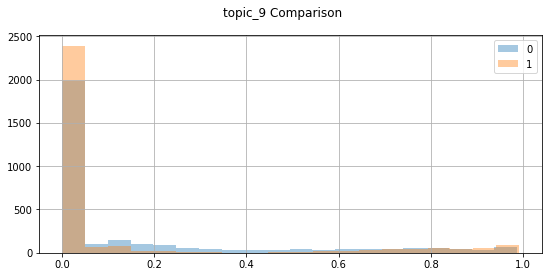

In [ ]:
kiva_train_topic_modelling_theta[['defaulted','topic_9']].groupby("defaulted").topic_9.hist(figsize=(9,4), alpha=0.4, bins=20, legend=True)
plt.suptitle("topic_9 Comparison")

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
topic_0,1.000000,-0.084394,-0.053309,-0.108931,-0.062891,-0.131181,-0.136802,0.001713,-0.083649,-0.143530
topic_1,-0.084394,1.000000,-0.109371,-0.151547,-0.065771,-0.207550,-0.221653,0.010799,0.248365,-0.221158
topic_2,-0.053309,-0.109371,1.000000,-0.175012,-0.049809,-0.209857,-0.235428,0.024106,-0.034830,-0.222879
topic_3,-0.108931,-0.151547,-0.175012,1.000000,-0.103644,-0.125060,-0.159104,-0.070014,-0.105497,-0.074503
topic_4,-0.062891,-0.065771,-0.049809,-0.103644,1.000000,-0.080706,-0.070501,0.014810,-0.030313,-0.133394
topic_5,-0.131181,-0.207550,-0.209857,-0.125060,-0.080706,1.000000,0.064934,-0.145515,-0.140085,-0.166500
topic_6,-0.136802,-0.221653,-0.235428,-0.159104,-0.070501,0.064934,1.000000,-0.133049,-0.151819,-0.193875
topic_7,0.001713,0.010799,0.024106,-0.070014,0.014810,-0.145515,-0.133049,1.000000,-0.093295,-0.130270
topic_8,-0.083649,0.248365,-0.034830,-0.105497,-0.030313,-0.140085,-0.151819,-0.093295,1.000000,-0.148988
topic_9,-0.143530,-0.221158,-0.222879,-0.074503,-0.133394,-0.166500,-0.193875,-0.130270,-0.148988,1.000000


[Text(0.5, 0, 'topic_0'),
 Text(1.5, 0, 'topic_1'),
 Text(2.5, 0, 'topic_2'),
 Text(3.5, 0, 'topic_3'),
 Text(4.5, 0, 'topic_4'),
 Text(5.5, 0, 'topic_5'),
 Text(6.5, 0, 'topic_6'),
 Text(7.5, 0, 'topic_7'),
 Text(8.5, 0, 'topic_8'),
 Text(9.5, 0, 'topic_9')]

Text(0.5, 1.0, 'Top 10 topics Correlation HeatMap')

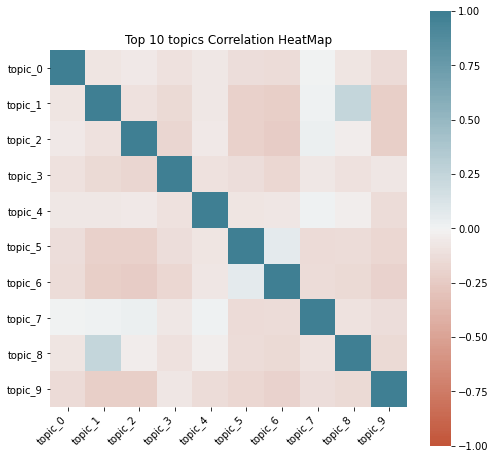

In [ ]:
import seaborn as sns
Corr_Plot_df1 = kiva_train_topic_modelling_theta[['topic_0', 'topic_1','topic_2', 'topic_3','topic_4', 'topic_5','topic_6', 'topic_7','topic_8', 'topic_9']]


Var_Corr1 = Corr_Plot_df1.corr()
Var_Corr1

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)

ax = sns.heatmap(
    Var_Corr1, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

ax.set_title('Top 10 topics Correlation HeatMap')

Text(0.5, 1.0, 'Top 10 topics defaulted class comparsion')

Text(0, 0.5, 'Count')

<Figure size 1152x864 with 0 Axes>

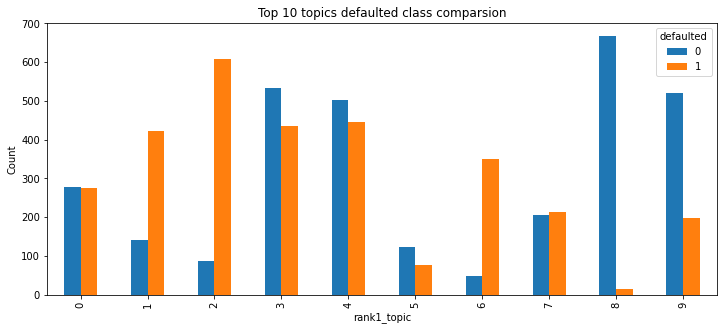

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,12))
kiva_train_topic_modelling_theta.groupby("rank1_topic").defaulted.value_counts().unstack().plot.bar(ylim=0,figsize=(12,5))
plt.title("Top 10 topics defaulted class comparsion")
plt.ylabel("Count")
plt.show()

#Cleansing before train test split

In [26]:
len(kiva_train[kiva_train.duplicated(['en_clean', 'defaulted'], keep=False)])

14

In [27]:
kiva_train[kiva_train.duplicated(['en_clean'], keep=False)].sort_values("en_clean")

,loan_id,en_clean,defaulted,clean_text,Num_w_b_preocessing,Num_w_a_preocessing
518,5671,"Celida Espino Calcano and her husband Victor have eight children and 14 grandchildren. Her small grocery store, named ""Colmado Anaceli after her second daughter, sells food staples, household items and cooking ingredients to her neighborhood of La Pacuala in the northern peninsula of Samana. She would like this loan to continue to restock her store with rice, salt, sugar, filtered water packets, etc. She puts everything that she saves back into the store and she hopes to expand with this loan to increase profits and therefore savings to provide better for her family. Each of the five members will receive a share of this $750 loan for their respective businesses and will be accountable to each other for repaying their share of this loan together. This group-lending method strengthens social needs in a community and ensures that members cooperate to help one another repay their loans and invest wisely in their business and family.",0,celida espino calcano her husband victor eight child grandchild her small grocery store named colmado anaceli her second daughter sell food staple household item cooking ingredient her neighborhood la pacuala northern peninsula samana she would like loan continue restock her store rice salt sugar filtered water packet etc she put everything she save back store she hope expand loan increase profit therefore saving provide better her family five member receive share loan respective business accountable repaying share loan together grouplending method strengthens social need community ensures member cooperate help one another repay loan invest wisely business family,154,97
5474,5985,"Celida Espino Calcano and her husband Victor have eight children and 14 grandchildren. Her small grocery store, named ""Colmado Anaceli after her second daughter, sells food staples, household items and cooking ingredients to her neighborhood of La Pacuala in the northern peninsula of Samana. She would like this loan to continue to restock her store with rice, salt, sugar, filtered water packets, etc. She puts everything that she saves back into the store and she hopes to expand with this loan to increase profits and therefore savings to provide better for her family. Each of the five members will receive a share of this $750 loan for their respective businesses and will be accountable to each other for repaying their share of this loan together. This group-lending method strengthens social needs in a community and ensures that members cooperate to help one another repay their loans and invest wisely in their business and family.",0,celida espino calcano her husband victor eight child grandchild her small grocery store named colmado anaceli her second daughter sell food staple household item cooking ingredient her neighborhood la pacuala northern peninsula samana she would like loan continue restock her store rice salt sugar filtered water packet etc she put everything she save back store she hope expand loan increase profit therefore saving provide better her family five member receive share loan respective business accountable repaying share loan together grouplending method strengthens social need community ensures member cooperate help one another repay loan invest wisely business family,154,97
865,5486,English:,0,english,1,1
1372,5490,English:,0,english,1,1
2191,5489,English:,0,english,1,1
5828,5480,English:,0,english,1,1
4511,862,I am a 27-year-old father of 2. I take care of 2 other children. My life will improve because I will be able to pay the school fees for my brother in secondary school.,1,yearold father take care child life improve able pay school fee brother secondary school,35,14
4889,4997,I am a 27-year-old father of 2. I take care of 2 other children. My life will improve because I will be able to pay the school fees for my brother in secondary school.,0,yearold father take care child life improve able pay school fee

In [28]:
All_duplicates = kiva_train[kiva_train.duplicated(['en_clean'], keep=False)]
All_duplicates2 = kiva_train[kiva_train.duplicated(['en_clean', 'defaulted'], keep=False)]

print("this is the duplicated rows in the text but contradicted label")
Contridiction_df = All_duplicates[~All_duplicates.isin(All_duplicates2)].dropna(how = 'all')
Contridiction_df

this is the duplicated rows in the text but contradicted label


,loan_id,en_clean,defaulted,clean_text,Num_w_b_preocessing,Num_w_a_preocessing
4511,862.0,I am a 27-year-old father of 2. I take care of 2 other children. My life will improve because I will be able to pay the school fees for my brother in secondary school.,1.0,yearold father take care child life improve able pay school fee brother secondary school,35.0,14.0
4889,4997.0,I am a 27-year-old father of 2. I take care of 2 other children. My life will improve because I will be able to pay the school fees for my brother in secondary school.,0.0,yearold father take care child life improve able pay school fee brother secondary school,35.0,14.0


Existing a contridiction, therefore, we need to drop that.

In [29]:
print("before drop contridiction there is total {} doc in training".format(len(kiva_train)))
kiva_train = kiva_train[~kiva_train.loan_id.isin(Contridiction_df.loan_id)]
print("after drop contridiction there is total {} doc in training".format(len(kiva_train)))

before drop contridiction there is total 6138 doc in training
after drop contridiction there is total 6136 doc in training


In [ ]:
# All_duplicates = kiva_train[kiva_train.duplicated(['en_clean'], keep=False)]
# All_duplicates.sort_values('totalwords')

In [30]:
print("before drop duplication there is total {} doc in training".format(len(kiva_train)))
kiva_train = kiva_train.drop_duplicates(subset=['en_clean'])
print("after drop duplication there is total {} doc in training".format(len(kiva_train)))

before drop duplication there is total 6136 doc in training
after drop duplication there is total 6128 doc in training


Should we take out the sample that less than n word?

In [ ]:
# kiva_train = kiva_train[kiva_train['totalwords']>=3]

# Train Test Split

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.corpus import stopwords
import textstat

from sklearn.model_selection import train_test_split


X = kiva_train['en_clean']
y = kiva_train['defaulted']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

df_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1EVWfyqQOd_W2uTKrr4JTD2iFrEZHoOHT")

X_test = df_test['en_clean']

# Use Naive Bayes and logistic regression as basline

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

# This vectorizer will be used to create the BOW features.
vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                             max_features = 200, 
                             min_df=.01, max_df=.9, ngram_range=[1,2],
                             use_idf=True)

rf = MultinomialNB()

# We will "union" together the BOW features and the custom-created features we
# created in the cell above.
feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('count_word', FunctionTransformer(count_word, validate=False)),
    ('check_gender', FunctionTransformer(check_gender, validate=False)),
    ('has_children', FunctionTransformer(has_children, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    #('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
])

pipe = Pipeline([('features', feature_processing), ('clf', rf)])
search_nb = pipe.fit(X_train, y_train)

y_val_pred = search_nb.predict(X_val)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search_nb.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

[[612 164]
 [271 488]]
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       776
           1       0.75      0.64      0.69       759

    accuracy                           0.72      1535
   macro avg       0.72      0.72      0.71      1535
weighted avg       0.72      0.72      0.72      1535



In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

# This vectorizer will be used to create the BOW features.
vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                             max_features = 500, 
                             min_df=.05, max_df=.85, ngram_range=[1,2],
                             use_idf=True)

rf = LogisticRegression()

# We will "union" together the BOW features and the custom-created features we
# created in the cell above.
feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('count_word', FunctionTransformer(doc_length, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
    #('polarity', FunctionTransformer(get_sentiment, validate=False))
    #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
    ("get_entities", FunctionTransformer(check_ents_all, validate=False))
])

pipe = Pipeline([('features', feature_processing), ('clf', rf)])
search_lr_1 = pipe.fit(X_train, y_train)

y_val_pred = search_lr_1.predict(X_val)

# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search_lr_1.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[557 219]
 [257 502]]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       776
           1       0.70      0.66      0.68       759

    accuracy                           0.69      1535
   macro avg       0.69      0.69      0.69      1535
weighted avg       0.69      0.69      0.69      1535



#Logsitic with GridSearch

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

scores=[]
params= {
         'n_gram': [2,3],
         'max_feature': [900,1000],
         'max_df':[0.925, 0.9, 0.875],
         'min_df':[0.005, 0.0075, 0.01],
         'max_iter' : [300, 400],
         'param_range' : [0.01,0.1,1,10, 50, 100]
         }

model_name = 'Logistic'


for n_gram in params['n_gram']:
  for max_feature in params['max_feature']:
    for max_iter in params['max_iter']:
      for max_df in params['max_df']:
        for min_df in params['min_df']:
          for param_range in params['param_range']:

            params_sets = [n_gram,max_feature,max_df,min_df,param_range]

            print("now is prcessing paramters {}".format((params_sets)))

            # This vectorizer will be used to create the BOW features.
            vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                        max_features = max_feature, 
                                        min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                        use_idf=False)

            rf = LogisticRegression(penalty = 'l2',C = param_range ,max_iter=max_iter, random_state=223)

            # We will "union" together the BOW features and the custom-created features we
            # created in the cell above.
            feature_processing =  FeatureUnion([ 
                ('bow', Pipeline([('vectorizer', vectorizer), ])),
                ('doc_length', FunctionTransformer(doc_length, validate=False)),
                ('count_word', FunctionTransformer(doc_length, validate=False)),
                ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                ('check_gender', FunctionTransformer(check_gender, validate=False)),
                ('has_children', FunctionTransformer(has_children, validate=False)),
                ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                #(get_sentiment)
            ])

            pipe = Pipeline([('features', feature_processing), ('clf', rf)])

            search_lr_final1 = pipe.fit(X_train, y_train)

            #search_rf_final1 = pipe.fit(X, y)

            #evaluate_testing_score(search_rf_final1)

            from sklearn.metrics import f1_score

            pred_test = search_lr_final1.predict(X_val)
            F1_score = f1_score(y_val, pred_test, average='weighted')
            print(F1_score)

            scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [2, 900, 0.925, 0.005, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.005, 0.1]
0.7767433702051152
now is prcessing paramters [2, 900, 0.925, 0.005, 1]
0.8311965278498659
now is prcessing paramters [2, 900, 0.925, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8177938229009282
now is prcessing paramters [2, 900, 0.925, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268288399471633
now is prcessing paramters [2, 900, 0.925, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268131242243312
now is prcessing paramters [2, 900, 0.925, 0.0075, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.0075, 0.1]
0.7754101657336644
now is prcessing paramters [2, 900, 0.925, 0.0075, 1]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8327458939377781
now is prcessing paramters [2, 900, 0.925, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8373671110185834
now is prcessing paramters [2, 900, 0.925, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.828338178497964
now is prcessing paramters [2, 900, 0.925, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8162767288090332
now is prcessing paramters [2, 900, 0.925, 0.01, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.01, 0.1]
0.7721883445295149
now is prcessing paramters [2, 900, 0.925, 0.01, 1]
0.8297972577428785
now is prcessing paramters [2, 900, 0.925, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8253123043569787
now is prcessing paramters [2, 900, 0.925, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8253249809108045
now is prcessing paramters [2, 900, 0.925, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8253249843629001
now is prcessing paramters [2, 900, 0.9, 0.005, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.9, 0.005, 0.1]
0.7632526162009562
now is prcessing paramters [2, 900, 0.9, 0.005, 1]
0.8297323064411615
now is prcessing paramters [2, 900, 0.9, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8267848198268234
now is prcessing paramters [2, 900, 0.9, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268225547706076
now is prcessing paramters [2, 900, 0.9, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8177938229009282
now is prcessing paramters [2, 900, 0.9, 0.0075, 0.01]
0.7072755125797968
now is prcessing paramters [2, 900, 0.9, 0.0075, 0.1]
0.7615955205546798
now is prcessing paramters [2, 900, 0.9, 0.0075, 1]
0.8342395067526478
now is prcessing paramters [2, 900, 0.9, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8297972577428785
now is prcessing paramters [2, 900, 0.9, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.823772381910768
now is prcessing paramters [2, 900, 0.9, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8358668342824469
now is prcessing paramters [2, 900, 0.9, 0.01, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.9, 0.01, 0.1]
0.7737819883710035
now is prcessing paramters [2, 900, 0.9, 0.01, 1]
0.8403324532739217
now is prcessing paramters [2, 900, 0.9, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8343478748212729
now is prcessing paramters [2, 900, 0.9, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.825286929838964
now is prcessing paramters [2, 900, 0.9, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298405076719297
now is prcessing paramters [2, 900, 0.875, 0.005, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.875, 0.005, 0.1]
0.7632526162009562
now is prcessing paramters [2, 900, 0.875, 0.005, 1]
0.8297323064411615
now is prcessing paramters [2, 900, 0.875, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8267848198268234
now is prcessing paramters [2, 900, 0.875, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268225547706076
now is prcessing paramters [2, 900, 0.875, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8177938229009282
now is prcessing paramters [2, 900, 0.875, 0.0075, 0.01]
0.7072755125797968
now is prcessing paramters [2, 900, 0.875, 0.0075, 0.1]
0.7615955205546798
now is prcessing paramters [2, 900, 0.875, 0.0075, 1]
0.8342395067526478
now is prcessing paramters [2, 900, 0.875, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8297972577428785
now is prcessing paramters [2, 900, 0.875, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.823772381910768
now is prcessing paramters [2, 900, 0.875, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8358668342824469
now is prcessing paramters [2, 900, 0.875, 0.01, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.875, 0.01, 0.1]
0.7737819883710035
now is prcessing paramters [2, 900, 0.875, 0.01, 1]
0.8403324532739217
now is prcessing paramters [2, 900, 0.875, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8343478748212729
now is prcessing paramters [2, 900, 0.875, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.825286929838964
now is prcessing paramters [2, 900, 0.875, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298405076719297
now is prcessing paramters [2, 900, 0.925, 0.005, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.005, 0.1]
0.7767433702051152
now is prcessing paramters [2, 900, 0.925, 0.005, 1]
0.8311965278498659
now is prcessing paramters [2, 900, 0.925, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8313115184652067
now is prcessing paramters [2, 900, 0.925, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8296734813953294
now is prcessing paramters [2, 900, 0.925, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8191703710028887
now is prcessing paramters [2, 900, 0.925, 0.0075, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.0075, 0.1]
0.7754101657336644
now is prcessing paramters [2, 900, 0.925, 0.0075, 1]
0.8327458939377781
now is prcessing paramters [2, 900, 0.925, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8343478748212729
now is prcessing paramters [2, 900, 0.925, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298405122959082
now is prcessing paramters [2, 900, 0.925, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8267439089208752
now is prcessing paramters [2, 900, 0.925, 0.01, 0.01]
0.7177985432483847
now is prcessing paramters [2, 900, 0.925, 0.01, 0.1]
0.7721883445295149
now is prcessing paramters [2, 900, 0.925, 0.01, 1]
0.8297972577428785
now is prcessing paramters [2, 900, 0.925, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8313436706859383
now is prcessing paramters [2, 900, 0.925, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8238203634040945
now is prcessing paramters [2, 900, 0.925, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8193017043904876
now is prcessing paramters [2, 900, 0.9, 0.005, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.9, 0.005, 0.1]
0.7632526162009562
now is prcessing paramters [2, 900, 0.9, 0.005, 1]
0.8297323064411615
now is prcessing paramters [2, 900, 0.9, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8282820723889346
now is prcessing paramters [2, 900, 0.9, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8177640533742319
now is prcessing paramters [2, 900, 0.9, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8283241611784099
now is prcessing paramters [2, 900, 0.9, 0.0075, 0.01]
0.7072755125797968
now is prcessing paramters [2, 900, 0.9, 0.0075, 0.1]
0.7615955205546798
now is prcessing paramters [2, 900, 0.9, 0.0075, 1]
0.8342395067526478
now is prcessing paramters [2, 900, 0.9, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298127110023819
now is prcessing paramters [2, 900, 0.9, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8283132530120482
now is prcessing paramters [2, 900, 0.9, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.828338178497964
now is prcessing paramters [2, 900, 0.9, 0.01, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.9, 0.01, 0.1]
0.7737819883710035
now is prcessing paramters [2, 900, 0.9, 0.01, 1]
0.8403324532739217
now is prcessing paramters [2, 900, 0.9, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298435988432707
now is prcessing paramters [2, 900, 0.9, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268288399471633
now is prcessing paramters [2, 900, 0.9, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8328370155556588
now is prcessing paramters [2, 900, 0.875, 0.005, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.875, 0.005, 0.1]
0.7632526162009562
now is prcessing paramters [2, 900, 0.875, 0.005, 1]
0.8297323064411615
now is prcessing paramters [2, 900, 0.875, 0.005, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8282820723889346
now is prcessing paramters [2, 900, 0.875, 0.005, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8177640533742319
now is prcessing paramters [2, 900, 0.875, 0.005, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8283241611784099
now is prcessing paramters [2, 900, 0.875, 0.0075, 0.01]
0.7072755125797968
now is prcessing paramters [2, 900, 0.875, 0.0075, 0.1]
0.7615955205546798
now is prcessing paramters [2, 900, 0.875, 0.0075, 1]
0.8342395067526478
now is prcessing paramters [2, 900, 0.875, 0.0075, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298127110023819
now is prcessing paramters [2, 900, 0.875, 0.0075, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8283132530120482
now is prcessing paramters [2, 900, 0.875, 0.0075, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.828338178497964
now is prcessing paramters [2, 900, 0.875, 0.01, 0.01]
0.7088235132065985
now is prcessing paramters [2, 900, 0.875, 0.01, 0.1]
0.7737819883710035
now is prcessing paramters [2, 900, 0.875, 0.01, 1]
0.8403324532739217
now is prcessing paramters [2, 900, 0.875, 0.01, 10]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8298435988432707
now is prcessing paramters [2, 900, 0.875, 0.01, 50]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8268288399471633
now is prcessing paramters [2, 900, 0.875, 0.01, 100]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.8328370155556588
now is prcessing paramters [2, 1000, 0.925, 0.005, 0.01]


KeyboardInterrupt: ignored

In [32]:
scores_df = pd.DataFrame(scores,columns=['model_name', 'parameter_set' ,'F1_Score'])
scores_df.sort_values("F1_Score").tail(10)

NameError: ignored

In [ ]:
prob_preds = search_lr_final1.predict_proba(X_val)
prob_preds

f1_list = []
threshold_list = []

for i in np.linspace(0.3,0.6,300):
  threshold = i # define threshold here
  preds_threshold = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
  F1_score = f1_score(y_val, preds_threshold, average='weighted')

  f1_list.append(F1_score)
  threshold_list.append(threshold)

array([[0.70076906, 0.29923094],
       [0.06301273, 0.93698727],
       [0.93587354, 0.06412646],
       ...,
       [0.58375762, 0.41624238],
       [0.13409348, 0.86590652],
       [0.98555053, 0.01444947]])

0.8464022715175509
182
0.4826086956521739


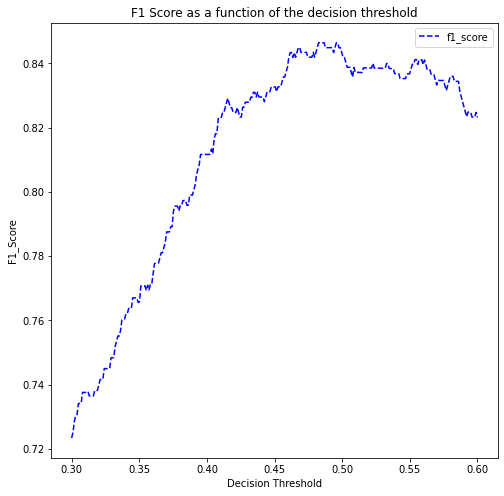

In [ ]:
plot_f1_vs_threshold(f1_list,threshold_list)

print(max(f1_list))
print(f1_list.index(max(f1_list)))
print(threshold_list[182])

## Best LR

In [ ]:
params= {
         'n_gram': [3],
         'max_feature': [1300],
         'max_df':[0.85],
         'min_df':[0.005],
         'max_iter' : [400],
         }

model_name = 'Logistic'


for n_gram in params['n_gram']:
  for max_feature in params['max_feature']:
    for max_df in params['max_df']:
      for min_df in params['min_df']:
        for max_iter in params['max_iter']:

          params_sets = [n_gram,max_feature,max_df,min_df,max_iter]

          print("now is prcessing paramters {}".format((params_sets)))

          # This vectorizer will be used to create the BOW features.
          vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                      max_features = max_feature, 
                                      min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                      use_idf=False)

          rf = LogisticRegression(max_iter=max_iter, random_state=223)

          # We will "union" together the BOW features and the custom-created features we
          # created in the cell above.
          feature_processing =  FeatureUnion([ 
              ('bow', Pipeline([('vectorizer', vectorizer), ])),
              ('doc_length', FunctionTransformer(doc_length, validate=False)),
              ('count_word', FunctionTransformer(doc_length, validate=False)),
              ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
              ('check_gender', FunctionTransformer(check_gender, validate=False)),
              ('has_children', FunctionTransformer(has_children, validate=False)),
              ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
              #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
              #("get_entities", FunctionTransformer(check_ents_all, validate=False))
          ])

          pipe = Pipeline([('features', feature_processing), ('clf', rf)])

          search_lr_final1 = pipe.fit(X_train, y_train)

          #search_rf_final1 = pipe.fit(X, y)

          #evaluate_testing_score(search_rf_final1)

          from sklearn.metrics import f1_score

          class_names = [str(x) for x in search_nb.classes_]
          print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

now is prcessing paramters [3, 1300, 0.85, 0.005, 400]
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       776
           1       0.70      0.66      0.68       759

    accuracy                           0.69      1535
   macro avg       0.69      0.69      0.69      1535
weighted avg       0.69      0.69      0.69      1535



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Support Vector Machine

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  

In [ ]:
scores=[]
params = {'C': [0.1,1, 10, 100], 
          'gamma': [1,0.1,0.01,0.001,'auto'],
          'kernel': ['rbf', 'poly', 'sigmoid','linear'],
           'max_feature': [1000],
         'max_df':[0.9],
         'min_df':[0.005],}

model_name = 'SVC'

for C in params['C']:
  for gamma in params['gamma']:
    for kernel in params['kernel']:
        for max_feature in params['max_feature']:
          for max_df in params['max_df']:
            for min_df in params['min_df']:

              params_sets = [C,gamma,kernel]

              print("now is prcessing paramters {}".format((params_sets)))

              # This vectorizer will be used to create the BOW features.
              vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                          max_features = max_feature, 
                                          min_df=min_df, max_df=max_df, ngram_range=[1,3],
                                          use_idf=False)

              rf = SVC(C=C, kernel=kernel, degree=3, gamma=gamma)

              # We will "union" together the BOW features and the custom-created features we
              # created in the cell above.
              feature_processing =  FeatureUnion([                          
                  ('bow', Pipeline([('vectorizer', vectorizer), ])),
                  ('doc_length', FunctionTransformer(doc_length, validate=False)),
                  ('count_word', FunctionTransformer(doc_length, validate=False)),
                  ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                  ('check_gender', FunctionTransformer(check_gender, validate=False)),
                  ('has_children', FunctionTransformer(has_children, validate=False)),
                  ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                  #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                  #("get_entities", FunctionTransformer(check_ents_all, validate=False))
              ])

              pipe = Pipeline([('features', feature_processing), ('clf', rf)])

              search_rf_final1 = pipe.fit(X_train, y_train)
              
              from sklearn.metrics import f1_score

              pred_test = search_rf_final1.predict(X_val)
              F1_score = f1_score(y_val, pred_test, average='weighted')
              print(F1_score)

              scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [0.1, 1, 'rbf']
0.3468055488887822
now is prcessing paramters [0.1, 1, 'poly']


# Random Forest with GridSearch

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

# This vectorizer will be used to create the BOW features.
vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                             max_features = 1000, 
                             min_df=.01, max_df=.9, ngram_range=[1,2],
                             use_idf=False)

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=223,
                                        verbose=0, warm_start=False)

# We will "union" together the BOW features and the custom-created features we
# created in the cell above.
feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('count_word', FunctionTransformer(count_word, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
    #('polarity', FunctionTransformer(get_sentiment, validate=False))
    #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
    #("get_entities", FunctionTransformer(check_ents_all, validate=False))
])

pipe = Pipeline([('features', feature_processing), ('clf', rf)])

search_rf_final1 = pipe.fit(X_train, y_train)

y_val_pred = search_rf_final1.predict(X_val)

print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))

class_names = [str(x) for x in search_rf_final1.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

[[667 109]
 [139 620]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       776
           1       0.85      0.82      0.83       759

    accuracy                           0.84      1535
   macro avg       0.84      0.84      0.84      1535
weighted avg       0.84      0.84      0.84      1535

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       340
           1       0.89      0.84      0.87       324

    accuracy                           0.87       664
   macro avg       0.87      0.87      0.87       664
weighted avg       0.87      0.87      0.87       664

F1 Score: 0.8733179134877619
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       340
           1       0.89      0.85      0.87       324

    accuracy                           0.88       664
   macro avg       0.88      0.88      0.88       664
weighted avg       0.8

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

scores=[]
params= {
         'min_samples_leaf': [3],
         'min_samples_split': [3],
         'max_depth': [50, 80, 100],
         'n_estimators': [300, 400],
         "subsample":[None, 0.925, 0.95],
         'n_gram': [3],
         'max_feature': [1200],
         'max_df':[0.925, 0.95],
         'min_df':[0.0025,0.005, 0.0075],
         }

# params= {
#          'min_samples_leaf': [2],
#          'min_samples_split': [2],
#          'max_depth': [80],
#          'n_estimators': [250],
#          'n_gram': [2],
#          'max_feature': [1000],
#          'max_df':[ 0.9],
#          'min_df':[0.005],
#          }


# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# params_sets = [max_depth ,min_samples_leaf, n_estimators,min_samples_split,n_gram,max_feature,max_df,min_df]
#now is prcessing paramters [60, 3, 400, 2, 3, 1400, 0.95, 0.01]


model_name = 'RandomForecast'

for subsample in params['subsample']:
  for max_depth in params['max_depth']:
      for min_samples_leaf in params['min_samples_leaf']:
          for n_estimators in params['n_estimators']:
            for min_samples_split in params['min_samples_split']:
              for n_gram in params['n_gram']:
                for max_feature in params['max_feature']:
                  for max_df in params['max_df']:
                    for min_df in params['min_df']:

                      params_sets = [max_depth ,min_samples_leaf, n_estimators,min_samples_split,n_gram,max_feature,max_df,min_df]

                      print("now is prcessing paramters {}".format((params_sets)))

                      # This vectorizer will be used to create the BOW features.
                      vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                  max_features = max_feature, 
                                                  min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                                  use_idf=False)

                      rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                                              class_weight=None, criterion='entropy',
                                                              max_depth=max_depth, max_features='auto',
                                                              max_leaf_nodes=None, max_samples=subsample,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                                              min_weight_fraction_leaf=0.0,
                                                              n_estimators=n_estimators, n_jobs=None,
                                                              oob_score=False, random_state=223,
                                                              verbose=0, warm_start=False)

                      # We will "union" together the BOW features and the custom-created features we
                      # created in the cell above.
                      feature_processing =  FeatureUnion([ 
                          ('bow', Pipeline([('vectorizer', vectorizer), ])),
                          ('doc_length', FunctionTransformer(doc_length, validate=False)),
                          ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                          ('count_word', FunctionTransformer(doc_length, validate=False)),
                          ('check_gender', FunctionTransformer(check_gender, validate=False)),
                          ('has_children', FunctionTransformer(has_children, validate=False)),
                          ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                          #('count_word', FunctionTransformer(doc_length, validate=False)),
                          #('polarity', FunctionTransformer(get_sentiment, validate=False))
                          #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                          #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                      ])

                      pipe = Pipeline([('features', feature_processing), ('clf', rf)])

                      search_rf_final1 = pipe.fit(X_train, y_train)

                      ###########################################
                      # Validation check
                      ###########################################

                      y_val_pred = search_rf_final1.predict(X_val)
                      F1_score = f1_score(y_val, y_val_pred, average='weighted')
                      print("Validation F1_score {}".format(F1_score))
                      from sklearn.metrics import confusion_matrix
                      from sklearn.metrics import classification_report
                      print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))
                      
                      scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [50, 3, 300, 3, 3, 1200, 0.925, 0.0025]


KeyboardInterrupt: ignored

In [ ]:
# from google.colab import files
scores_df = pd.DataFrame(scores,columns=['model_name', 'parameter_set' ,'F1_Score'])
scores_df.sort_values("F1_Score").tail(10)

NameError: ignored

## Best RF

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import FunctionTransformer

scores=[]
params= {
         'min_samples_leaf': [3],
         'min_samples_split': [3],
         'max_depth': [80],
         'n_estimators': [400],
         "subsample":[ 0.925],
         'n_gram': [3],
         'max_feature': [1200],
         'max_df':[0.925],
         'min_df':[0.0025],
         }

# params= {
#          'min_samples_leaf': [2],
#          'min_samples_split': [2],
#          'max_depth': [80],
#          'n_estimators': [250],
#          'n_gram': [2],
#          'max_feature': [1000],
#          'max_df':[ 0.9],
#          'min_df':[0.005],
#          }


# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# params_sets = [max_depth ,min_samples_leaf, n_estimators,min_samples_split,n_gram,max_feature,max_df,min_df]
#now is prcessing paramters [60, 3, 400, 2, 3, 1400, 0.95, 0.01]


model_name = 'RandomForecast'

for subsample in params['subsample']:
  for max_depth in params['max_depth']:
      for min_samples_leaf in params['min_samples_leaf']:
          for n_estimators in params['n_estimators']:
            for min_samples_split in params['min_samples_split']:
              for n_gram in params['n_gram']:
                for max_feature in params['max_feature']:
                  for max_df in params['max_df']:
                    for min_df in params['min_df']:

                      params_sets = [max_depth ,min_samples_leaf, n_estimators,min_samples_split,n_gram,max_feature,max_df,min_df]

                      print("now is prcessing paramters {}".format((params_sets)))

                      # This vectorizer will be used to create the BOW features.
                      vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                  max_features = max_feature, 
                                                  min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                                  use_idf=False)

                      rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                                              class_weight=None, criterion='entropy',
                                                              max_depth=max_depth, max_features='auto',
                                                              max_leaf_nodes=None, max_samples=subsample,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                                              min_weight_fraction_leaf=0.0,
                                                              n_estimators=n_estimators, n_jobs=None,
                                                              oob_score=False, random_state=223,
                                                              verbose=0, warm_start=False)

                      # We will "union" together the BOW features and the custom-created features we
                      # created in the cell above.
                      feature_processing =  FeatureUnion([ 
                          ('bow', Pipeline([('vectorizer', vectorizer), ])),
                          ('doc_length', FunctionTransformer(doc_length, validate=False)),
                          ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                          ('count_word', FunctionTransformer(doc_length, validate=False)),
                          ('check_gender', FunctionTransformer(check_gender, validate=False)),
                          ('has_children', FunctionTransformer(has_children, validate=False)),
                          ('get_extra_features', FunctionTransformer(get_extra_features, validate=False)),
                          #('get_extra_features2', FunctionTransformer(get_extra_features, validate=False))
                          #('count_word', FunctionTransformer(doc_length, validate=False)),
                          #('polarity', FunctionTransformer(get_sentiment, validate=False))
                          #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                          #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                      ])

                      pipe = Pipeline([('features', feature_processing), ('clf', rf)])

                      search_rf_best_final1 = pipe.fit(X_train, y_train)

                      ###########################################
                      # Validation check
                      ###########################################

                      y_val_pred = search_rf_final1.predict(X_val)
                      F1_score = f1_score(y_val, y_val_pred, average='weighted')
                      print("Validation F1_score {}".format(F1_score))
                      from sklearn.metrics import confusion_matrix
                      from sklearn.metrics import classification_report
                      print(confusion_matrix(y_true = y_val, y_pred = y_val_pred))


now is prcessing paramters [80, 3, 400, 3, 3, 1200, 0.925, 0.0025]


KeyboardInterrupt: ignored

In [ ]:
prob_val_preds = search_rf_best_final1.predict_proba(X_train)
prob_val_preds

threshold = 0.518 # define threshold here
preds_threshold_rf = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
F1_score = f1_score(prob_val_preds.defaulted, prob_val_preds, average='weighted')
print(F1_score)

array([[0.82581626, 0.17418374],
       [0.03367102, 0.96632898],
       [0.83454528, 0.16545472],
       ...,
       [0.7797219 , 0.2202781 ],
       [0.91712339, 0.08287661],
       [0.95765262, 0.04234738]])

NameError: ignored

## Threshold Checking

array([[0.82581626, 0.17418374],
       [0.03367102, 0.96632898],
       [0.83454528, 0.16545472],
       ...,
       [0.7797219 , 0.2202781 ],
       [0.91712339, 0.08287661],
       [0.95765262, 0.04234738]])

0.9982620107530182
272
0.5180360721442885


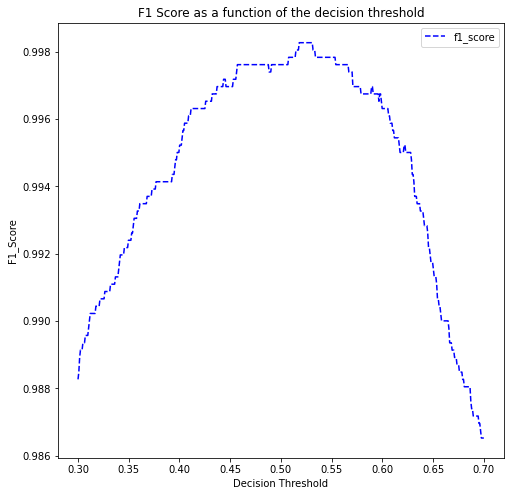

In [ ]:
prob_val_preds = search_rf_best_final1.predict_proba(X_train)
prob_val_preds

f1_list = []
threshold_list = []

for i in np.linspace(0.3,0.7,500):
  threshold = i # define threshold here
  preds_threshold = [1 if prob_val_preds[i][1]> threshold else 0 for i in range(len(prob_val_preds))]
  F1_score = f1_score(y_train, preds_threshold, average='weighted')

  f1_list.append(F1_score)
  threshold_list.append(threshold)

plot_f1_vs_threshold(f1_list,threshold_list)

print(max(f1_list))
print(f1_list.index(max(f1_list)))
print(threshold_list[272])

In [ ]:
prob_preds = search_rf_best_final1.predict_proba(df_test['en_clean'])
prob_preds

f1_list = []
threshold_list = []

for i in np.linspace(0.3,0.6,300):
  threshold = i # define threshold here
  preds_threshold = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
  F1_score = f1_score(kiva_test_label.defaulted, preds_threshold, average='weighted')

  f1_list.append(F1_score)
  threshold_list.append(threshold)

array([[0.62375162, 0.37624838],
       [0.05350549, 0.94649451],
       [0.68557639, 0.31442361],
       ...,
       [0.56478038, 0.43521962],
       [0.05282765, 0.94717235],
       [0.96488988, 0.03511012]])

In [ ]:
len(f1_list)
len(threshold_list)

300

300

In [ ]:
def plot_f1_vs_threshold(f1_score, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("F1 Score as a function of the decision threshold")
    plt.plot(thresholds, f1_score, "b--", label="f1_score")
    plt.ylabel("F1_Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
kiva_full_features.head(1)

,loan_id,en_clean,defaulted,polarity,len,syll,lex,sent,flesch,kincaid,gunning,Money
0,7779,"She opened a colmado out of the side of her house. In the Dominican Republic, a colmado is a small, neighborhood general store. Lucia sells several staple food items such as rice, dried beans, cookies and crackers as well as razors, toilet paper and other daily necessities. Her business has been very successful, and she is now on her third Ezperanza loan. Lucia's business has helped put her two children through college. She has a son, age 25, and a daughter, age 23. She is enthusiastic about the success of her business and plans to continue to expand her business as much as possible. The community she lives in loves the convenience of having a colmado in the neighborhood.",0,0.405769,680.0,177.0,119.0,8.0,64.81,7.9,9.32,0


In [ ]:
bow_names = dict(pipe.named_steps['features'].transformer_list).get('bow').named_steps['vectorizer'].get_feature_names()
bow_names = [name.replace(' ', '_') for name in bow_names]
feature_names = bow_names + ['doc_length', 'num_exclamation_marks','count_word', 'gender', 'has_children', 'len', 'syll', 'lex', 'sent', 'flesch', 'kincaid', 'gunning', 'Money', 'polarity','subjectivity']

from matplotlib import pyplot as plt

clf_obj = pipe.named_steps['clf']
imp = pd.DataFrame({'Feature': feature_names, 'Importance': clf_obj.feature_importances_})
imp = imp.sort_values('Importance', ascending=False)
imp.head(20)

,Feature,Importance
1212,Money,0.028193
880,repay_loan,0.016053
893,requesting,0.013865
585,loan,0.012661
879,repay,0.012610
1208,sent,0.010754
1202,count_word,0.009830
1206,syll,0.009627
1205,len,0.009600
1210,kincaid,0.009450


<BarContainer object of 20 artists>

Text(0.5, 0, 'Permutation Importance')

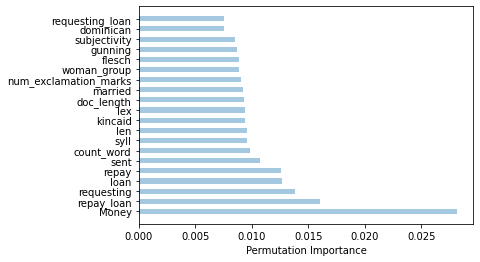

In [ ]:
figure= figsize=(10, 6)
plt.barh(imp.head(20).Feature, imp.head(20).Importance, alpha=0.4,  height=0.5)
plt.xlabel("Permutation Importance")

Text(0.5, 1.0, 'Random Forecast Feature Importance')

Text(0.5, 0, 'Importance')

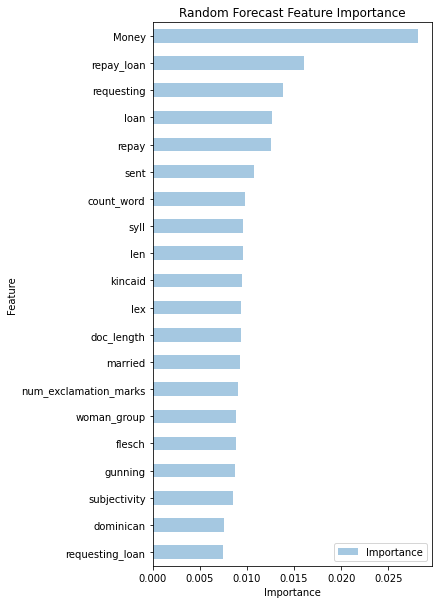

In [ ]:
imp.head(20).sort_values('Importance', ascending=True).set_index("Feature").plot.barh( alpha=0.4, figsize=(5, 10))
plt.title("Random Forecast Feature Importance")
plt.xlabel("Importance")

In [ ]:
kiva_full_features.groupby("Money").defaulted.value_counts().unstack().plot.bar(ylim=0, figsize=(10,5), alpha=0.4)
plt.title("Name Entity MONEY Target Comparison")
plt.ylabel("Count")
plt.show()

#Xgboost with GrideSearch

In [33]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

scores=[]

params = {
    "min_samples_leaf": [3, 5,7],
    "loss":["deviance"],
    "learning_rate": [0.05],
    "max_depth":[26, 30],
    "max_features_gbt":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.875, 0.9, 0.925],
    "n_estimators":[400, 500],
    'n_gram': [3],
    'max_feature': [1000],
    'max_df':[0.85, 0.875, 0.9, 0.925],
    'min_df':[0.005, 0.0075, 0.0025],
    }


model_name = 'Gradient Boost'

for min_samples_leaf in params['min_samples_leaf']:
  for max_depth in params['max_depth']:
      for criterion in params['criterion']:
          for n_estimators in params['n_estimators']:
            for learning_rate in params['learning_rate']:
              for n_gram in params['n_gram']:
                for max_feature in params['max_feature']:
                  for max_df in params['max_df']:
                    for min_df in params['min_df']:
                      for max_features_gbt in params['max_features_gbt']:
                        for subsample in params['subsample']:

                          params_sets = [min_samples_leaf,max_depth, n_estimators,learning_rate, max_features_gbt, n_gram, max_feature, max_df,min_df, subsample]

                          print("now is prcessing paramters {}".format((params_sets)))

                          # This vectorizer will be used to create the BOW features.
                          vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                      max_features = max_feature, 
                                                      min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                                      use_idf=False)

                          rf = GradientBoostingClassifier(criterion=criterion, init=None,
                                                          learning_rate=learning_rate, loss='deviance', max_depth=max_depth,
                                                          max_features=max_features_gbt, max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0, min_impurity_split=None,
                                                          min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_leaf,
                                                          min_weight_fraction_leaf=0.0, n_estimators=n_estimators, presort='auto',
                                                          random_state=223, subsample=subsample, verbose=0,
                                                          warm_start=False)

                          # We will "union" together the BOW features and the custom-created features we
                          # created in the cell above.
                          feature_processing =  FeatureUnion([ 
                              ('bow', Pipeline([('vectorizer', vectorizer), ])),
                              ('doc_length', FunctionTransformer(doc_length, validate=False)),
                              ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                              ('count_word', FunctionTransformer(count_word, validate=False)),
                              ('check_gender', FunctionTransformer(check_gender, validate=False)),
                              ('has_children', FunctionTransformer(has_children, validate=False)),
                              ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                              #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                              #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                          ])

                          pipe = Pipeline([('features', feature_processing), ('clf', rf)])

                          search_gb_final1 = pipe.fit(X_train, y_train)

                          pred_val = search_gb_final1.predict(X_val)
                          F1_score = f1_score(y_val, pred_val, average='weighted')
                          print(F1_score)

                          scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.005, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8635918457713107
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.005, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8636057973224819
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.005, 0.925]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8590203281136797
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0075, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8655414355447416
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0075, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8629511489942107
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0075, 0.925]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8622681955849033
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0025, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8570461366497337
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0025, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8590078328981723
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.85, 0.0025, 0.925]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8629364301105219
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.005, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8635918457713107
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.005, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8636057973224819
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.005, 0.925]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8590203281136797
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.0075, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8655414355447416
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.0075, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8629511489942107
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.0075, 0.925]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8622681955849033
now is prcessing paramters [3, 26, 400, 0.05, 'sqrt', 3, 1000, 0.875, 0.0025, 0.875]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


KeyboardInterrupt: ignored

In [34]:
scores_df = pd.DataFrame(scores,columns=['model_name', 'parameter_set' ,'F1_Score'])
scores_df.sort_values("F1_Score").tail(10)

,model_name,parameter_set,F1_Score
14,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.875, 0.0075, 0.925]",0.862268
8,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.85, 0.0025, 0.925]",0.862936
4,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.85, 0.0075, 0.9]",0.862951
13,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.875, 0.0075, 0.9]",0.862951
0,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.85, 0.005, 0.875]",0.863592
9,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.875, 0.005, 0.875]",0.863592
1,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.85, 0.005, 0.9]",0.863606
10,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.875, 0.005, 0.9]",0.863606
3,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.85, 0.0075, 0.875]",0.865541
12,Gradient Boost,"[3, 26, 400, 0.05, sqrt, 3, 1000, 0.875, 0.0075, 0.875]",0.865541


In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

scores=[]

# No cleansing with all features

params = {
    "min_samples_leaf": [ 3],
    "min_samples_split": [ 3],
    "loss":["deviance"],
    "learning_rate": [0.05],
    "max_depth":[30],
    "max_features_gbt":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.95, 0.925, 0.9],
    "n_estimators":[500],
    'n_gram': [3],
    'max_feature': [1000],
    'max_df':[0.9, 0.925, 0.95],
    'min_df':[0.003, 0.004, 0.005],
    }


model_name = 'Gradient Boost'

for min_samples_split in params["min_samples_split"]:
  for min_samples_leaf in params["min_samples_leaf"]:
    for max_depth in params['max_depth']:
        for criterion in params['criterion']:
            for n_estimators in params['n_estimators']:
              for learning_rate in params['learning_rate']:
                for n_gram in params['n_gram']:
                  for max_feature in params['max_feature']:
                    for max_df in params['max_df']:
                      for min_df in params['min_df']:
                        for max_features_gbt in params['max_features_gbt']:
                          for subsample in params['subsample']:

                            params_sets = [min_samples_split, min_samples_leaf, max_depth, n_estimators,learning_rate, max_features_gbt, n_gram, max_feature, max_df,min_df, subsample]

                            print("now is prcessing paramters {}".format((params_sets)))

                            # This vectorizer will be used to create the BOW features.
                            vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                        max_features = max_feature, 
                                                        min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                                        use_idf=False)

                            rf = GradientBoostingClassifier(criterion=criterion, init=None,
                                                            learning_rate=learning_rate, loss='deviance', max_depth=max_depth,
                                                            max_features=max_features_gbt, max_leaf_nodes=None,
                                                            min_impurity_decrease=0.0, min_impurity_split=None,
                                                            min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                                            min_weight_fraction_leaf=0.0, n_estimators=n_estimators, presort='auto',
                                                            random_state=223, subsample=subsample, verbose=0,
                                                            warm_start=False)

                            # We will "union" together the BOW features and the custom-created features we
                            # created in the cell above.
                            feature_processing =  FeatureUnion([ 
                                ('bow', Pipeline([('vectorizer', vectorizer), ])),
                                ('doc_length', FunctionTransformer(doc_length, validate=False)),
                                ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                                ('count_word', FunctionTransformer(doc_length, validate=False)),
                                ('check_gender', FunctionTransformer(check_gender, validate=False)),
                                ('has_children', FunctionTransformer(has_children, validate=False)),
                                ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                                #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                                #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                            ])

                            pipe = Pipeline([('features', feature_processing), ('clf', rf)])

                            search_gb_final1 = pipe.fit(X_train, y_train)

                            pred_val = search_gb_final1.predict(X_val)
                            F1_score = f1_score(y_val, pred_val, average='weighted')
                            print(F1_score)

                            scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [3, 3, 30, 500, 0.05, 'sqrt', 3, 1000, 0.9, 0.003, 0.95]


KeyboardInterrupt: ignored

## Best XGB

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

scores=[]

# No cleansing with all features


params = {
    "min_samples_leaf": [3],
    "loss":["deviance"],
    "learning_rate": [0.05],
    "max_depth":[30],
    "max_features_gbt":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.90],
    "n_estimators":[500],
    'n_gram': [3],
    'max_feature': [1000],
    'max_df':[0.9],
    'min_df':[0.005],
    }


model_name = 'Gradient Boost'

for min_samples_leaf in params["min_samples_leaf"]:
  for max_depth in params['max_depth']:
      for criterion in params['criterion']:
          for n_estimators in params['n_estimators']:
            for learning_rate in params['learning_rate']:
              for n_gram in params['n_gram']:
                for max_feature in params['max_feature']:
                  for max_df in params['max_df']:
                    for min_df in params['min_df']:
                      for max_features_gbt in params['max_features_gbt']:
                        for subsample in params['subsample']:

                          params_sets = [min_samples_leaf, max_depth, n_estimators,learning_rate, max_features_gbt, n_gram, max_feature, max_df,min_df, subsample]

                          print("now is prcessing paramters {}".format((params_sets)))

                          # This vectorizer will be used to create the BOW features.
                          vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                      max_features = max_feature, 
                                                      min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                                      use_idf=False)

                          rf = GradientBoostingClassifier(criterion=criterion, init=None,
                                                          learning_rate=learning_rate, loss='deviance', max_depth=max_depth,
                                                          max_features=max_features_gbt, max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0, min_impurity_split=None,
                                                          min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_leaf,
                                                          min_weight_fraction_leaf=0.0, n_estimators=n_estimators, presort='auto',
                                                          random_state=223, subsample=subsample, verbose=0,
                                                          warm_start=False)

                          # We will "union" together the BOW features and the custom-created features we
                          # created in the cell above.
                          feature_processing =  FeatureUnion([ 
                              ('bow', Pipeline([('vectorizer', vectorizer), ])),
                              ('doc_length', FunctionTransformer(doc_length, validate=False)),
                              ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                              ('count_word', FunctionTransformer(doc_length, validate=False)),
                              ('check_gender', FunctionTransformer(check_gender, validate=False)),
                              ('has_children', FunctionTransformer(has_children, validate=False)),
                              #('get_extra_features', FunctionTransformer(get_extra_features, validate=False)),
                              #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                              #("get_entities", FunctionTransformer(check_ents_all, validate=False)),
                              #("get_sentiment", FunctionTransformer(check_ents_all, validate=False))
                              
                          ])

                          pipe = Pipeline([('features', feature_processing), ('clf', rf)])

                          search_gb_final1 = pipe.fit(X_train, y_train)

                          pred_val = search_gb_final1.predict(X_val)
                          F1_score = f1_score(y_val, pred_val, average='weighted')
                          print(F1_score)

                          scores.append([model_name, params_sets, F1_score])

now is prcessing paramters [3, 30, 500, 0.05, 'sqrt', 3, 1000, 0.9, 0.005, 0.9]


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


0.8507948245690934


In [40]:
prob_preds = search_best_final.predict_proba(X_val)
prob_preds

f1_list = []
threshold_list = []

for i in np.linspace(0.2,0.8,200):
  threshold = i # define threshold here
  preds_threshold_xgb = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]
  F1_score = f1_score(y_val, preds_threshold_xgb, average='weighted')

  f1_list.append(F1_score)
  threshold_list.append(threshold)

array([[2.20993601e-02, 9.77900640e-01],
       [9.99812513e-01, 1.87487195e-04],
       [9.61360927e-04, 9.99038639e-01],
       ...,
       [9.45766450e-01, 5.42335495e-02],
       [7.88113904e-01, 2.11886096e-01],
       [8.50930685e-01, 1.49069315e-01]])

0.8694383271220445
40
0.48643216080402013


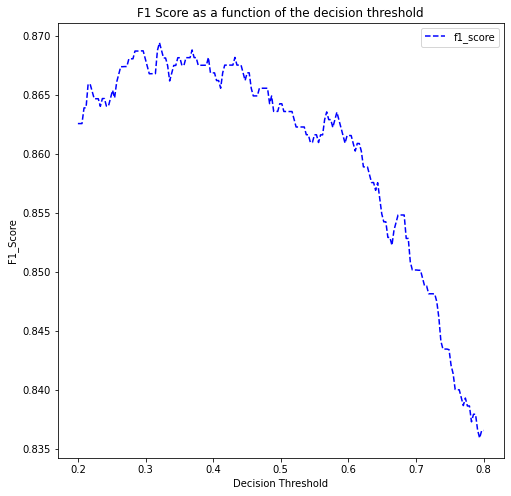

In [41]:
plot_f1_vs_threshold(f1_list,threshold_list)

print(max(f1_list))
print(f1_list.index(max(f1_list)))
print(threshold_list[95])

In [26]:
kiva_train.head()

,loan_id,en_clean,defaulted
0,7779,"She opened a colmado out of the side of her house. In the Dominican Republic, a colmado is a small, neighborhood general store. Lucia sells several staple food items such as rice, dried beans, cookies and crackers as well as razors, toilet paper and other daily necessities. Her business has been very successful, and she is now on her third Ezperanza loan. Lucia's business has helped put her two children through college. She has a son, age 25, and a daughter, age 23. She is enthusiastic about the success of her business and plans to continue to expand her business as much as possible. The community she lives in loves the convenience of having a colmado in the neighborhood.",0
1,2777,"(First Loan): Joffre continues to run his locksmith and motorbike repair shop and he has started a new business by offering motorbike transportation services within the sector. Business Development: His income has increased due to the two businesses he runs. He has a solid demand in the repair shop, as well as in his transportation services. His sons help him by driving to of his motorbikes. He just recently bought a motorbike. : He is married and has three sons, who are in school and help him with his business. He has rooms for rent which provide him with monthly income. (Second Loan): He will use the loan to fix the motorbike he bought to provide transportation services and for the maintenance of his other motorbike.",1
2,6007,"Dina Santana is the mother of two children, Julio Manuel Santana (2), Dianna Michelle Santan (7), and the wife of Adriano De la Cruz. Dina currently is selling clothing and also selling a common type of food here called Yucca. With this loan she is hoping to be able to not only buy more merchandise in order to expand her business, but she is hoping to be able to go to a better farm from which to buy the Yucca. Each of the five members will receive a share of this $800 loan for their respective businesses and will be accountable to each other for repaying their share of this loan together. This group-lending method strengthens social needs in a community and ensures that members cooperate to help one another repay their loans and invest wisely in their businesses and families.",0
3,76,"Rosemary is 50 years old, single, and has 6 children and 1 grandchild. She joined the group with an aim of improving her living standards. She has taken on the task of bringing up her kids alone. Living in slums, she has been able to get her income through casual jobs of many kinds. She has been paying fees for her children where she has 2 girls in high school,1 1 in college sponsored and 4 in primary school. She got a donation from one of her church member and started eggs business. She used to buy one tray at USD2 and sells it at USD2.4 but today demand is high and she is selling it at USD3.The business has been good and she no longer relies on casual jobs. She has a challenge of supplying eggs due to financial constrain. She believes she can handle the large quantity of eggs to supply often to her customers. She has a different perspective of life and she is very determined to work hard and educate her children.",1
4,4217,"Segundo has a shop where he sells animal feed, medicines and live poultry. He sells products for all types of animals ranging from pigs to ducks. Many people in his community raise these types of animals in their own backyards in order to resell them later for profits. He learned this business while being an assistant for his uncle for ten years. His uncle motivated him to start his own shop about 4 years ago and now he has a spot in his home where he makes his sales. Segundo needs this loan in order to invest in products at wholesale prices and quantities. He also wants to help his wife set up a part of their business as a small food market. They have been experimenting with the idea with some sales and they see potential for increased profits. Segundo and his wife are a young couple 

In [43]:
threshold = 0.5 # define threshold here
preds_threshold_xgb = [1 if prob_preds[i][1]> threshold else 0 for i in range(len(prob_preds))]

[[0.36773907 0.63226093]]


[('use', 0.1296449238040581),
 ('takes', 0.12889369006684576),
 ('care', 0.11654897686688104),
 ('utensils', 0.10791497068212702),
 ('loan', 0.09389383889922877),
 ('business', -0.08473530504491295),
 ('dishes', -0.08340709923055041),
 ('buy', 0.07223863139438516),
 ('savings', -0.07090878269937652),
 ('chairs', 0.0700472592120698),
 ('construction', 0.06162348472162827),
 ('quality', -0.05904399842570934),
 ('family', 0.05697524622399653),
 ('expand', 0.05639447547469136),
 ('tables', 0.05141995565606579),
 ('mother', -0.042906619623570355),
 ('attend', 0.034882804675531676),
 ('hope', -0.028871190629751076),
 ('make', -0.028348617468330298),
 ('helps', -0.027618273432551486)]

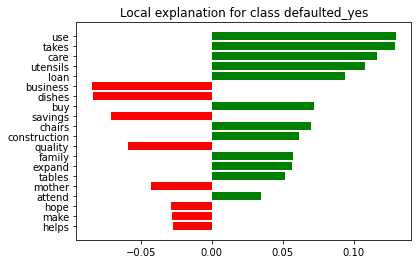

In [164]:
#!pip install lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# y_pred_prob = search.predict_proba(X_val)[:, 1]
# y_pred_prob
#c = make_pipeline(vect, classifier)
mystring = list(kiva_train[kiva_train['loan_id']==5929]['en_clean'])[0] #Take a string from test instance
print(search_gb_final1.predict_proba([mystring])) #Prediction is a "No" here. i.e., not relevant
class_names = ["defaulted_no", "defaulted_yes"] #not relevant, relevant
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(mystring, search_gb_final1.predict_proba, num_features=20)
exp.as_list()

%matplotlib inline
fig = exp.as_pyplot_figure()

In [152]:
mystring = list(kiva_train[kiva_train['loan_id']==5929]['en_clean'])[0] 
mystring

"Imelda capitalized her business with her own savings. Her mother helps her serve her clients. Her business thrives because she serves delicious and varied dishes. Purpose of Loan Imelda would use the loan to buy kitchen utensils, tables, chairs, and crockery and to make other improvements that would result in better service for her clients. About the Applicant Imelda is thirty-eight. She has three children who attend school. In spite of receiving no help from her family, Imelda takes care of her mother, who suffers from diabetes. Her house is of mixed construction techniques. Her hope is to expand her business and improve her family's quality of life."

In [163]:
kiva_train[kiva_train['loan_id']==7164]

,loan_id,en_clean,defaulted,pred,pred_prod,pred_1
4196,7164,"Natalia is thirty-nine years old and a single mother of four school-age children. She lives in the Trinitarios community of San Cristobal. Natalia separated from her husband four years ago, and since then she has had to fend for her family by herself. She says that seeing to the needs of four kids is no easy job, and that some nights she doesnt get a wink of sleep, thinking about what she can do to keep supporting her family. Currently, Natalia sells garments to people in her community, and she says that her business has been a great help in paying for her children's schooling. With her loan, the entrepreneur will buy more garments to increase her sales volume and thus her revenue. Natalia wants to become one of the most well-established suppliers of these goods in her sector.",0,0,0.772045,0.227955


In [154]:
print(search_gb_final1.predict([mystring]))

[1]


In [117]:
search_gb_final1.predict_proba([mystring])

array([[0.87871611, 0.12128389]])

In [162]:
exp.show_in_notebook()

In [56]:
y_val.index

Int64Index([2031, 5356, 4392,  576, 3771, 1253, 1612, 4866, 4102, 1209,
            ...
            1879,  790, 2181, 5813, 5558, 3260, 5107, 3339, 1359, 2486],
           dtype='int64', length=1535)

In [74]:
len(pred_val)

1535

In [82]:
A =pd.DataFrame(kiva_train.defaulted)

A['pred'] = pred

In [83]:
A[A['defaulted']!=A['pred']]

,defaulted,pred
14,0,1
29,0,1
33,0,1
44,0,1
69,1,0
...,...,...
5954,1,0
5958,1,0
6017,0,1
6038,1,0


In [146]:
pred_prod = search_gb_final1.predict_proba(kiva_train['en_clean'])

In [148]:
kiva_train[['pred_prod', 'pred_1']]= pred_prod

In [160]:
kiva_train[(kiva_train['pred_1']>0.2) &(kiva_train['pred_1']<0.3)]

,loan_id,en_clean,defaulted,pred,pred_prod,pred_1
8,4357,"Wilson is seeking his second loan with Kiva and Mifex. With his first loan he was able to invest in his furniture making business. He increased his supply of raw materials and he was also able to hire two new employees. Wilson has also just opened a new location from which he hopes to sell his final products. He is very excited about the new store that will be run by his daughter. Wilson truly runs a family business. His two sons are employees in his workshop along with a couple of other workers. His daughter is helping him at his new location and Wilson is responsible for the oversight of the whole operation. He needs the loan in order to invest in his new store and continue purchasing raw materials. He will also invest in products made out of paja toquilla straw, the same material used for panama hats. Furniture making has always provided him and his family with enough income for food and housing. Wilson is proud of the progress his business is making. He thanks the Kiva community for providing him with his first loan and hopes to continue receiving support from the international community.",0,0,0.790206,0.209794
69,381,"Susan is 35 years old. She is married and has 4 school-going children. She is a wife of a servant of God making her more involved in church activities. She is a good counselor, especially for the youth. Susan has always maintained the fact that, for them to be able to solve most of the problems afflicting families, women must join hands and work together. Savings and credit groups are organizations she holds dearly in her heart. She has influenced many women to join the groups. She earns her income from selling food products and curios. She was empowered to start the business through the training she has had from the group. She has esteemed customers who have helped her business performance. She has been able to transform her family life and she feels great when working in her food kiosk.",1,0,0.777060,0.222940
420,2971,"Josefina lives with her two children in the Barrio community of Santo Domingo. Barrio is one of the poorest communities of the capital, and most of the residents are unemployed and undereducated. Josefina sells womens clothing in the neighborhood in order to earn a living and fend for her children. She says that keeping up with two school-going kids is a hard job, but she understands thats the only way she can guarantee a bright future for the children. Josefina needs capital to invest in her business so that she can increase her inventory and her sales volume. Shes requesting a loan to buy clothing in bulk to sell in her community. Josefina hopes that her business will generate better income for her home, and improve her familys living conditions.",1,0,0.743844,0.256156
452,6536,"Yulvania is a very young entrepreneur who is striving for a better life. She lives with her partner and has no children. She is studying Computer Sciences in the public university of Santo Domingo, in the capital. For more than two years, Yulvania has been selling jewelry. She has different kinds of jewels in her inventory: gold-filled, silver-plated, acrylic jewels and plastic stones. When she started the business, she was just selling gold-filled jewelry. Six months ago, she obtained FSMA funds with which she could enlarge her inventory and attract more customers. This entrepreneur is very responsible and hard-working. Her discipline and sense of business helped her pay back the loan on time. With profits from her sales activity, Yulvania pays transport to go to the university five days a week; she also helps her partner pay for their rented house, and she saves money for an emergency. This entrepreneur hopes her business can grow so that she can have her own locale to operate her business, and that the store can get a lot of loyal customers. She has applied for a second loan to buy more goods to sell during the Christmas period. She thinks that its a grea

#AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

scores=[]

params = {
    "algorithm": ['SAMME', 'SAMME.R'],
    "learning_rate": [1.2, 1.3, 1.4, 1.5],
    "n_estimators":[1000],
    'n_gram': [3],
    'max_feature': [1000],
    'max_df':[0.85,0.875,0.9, 0.925, 0.95],
    'min_df':[0.005, 0.0075, 0.01, 0.05],
    }


model_name = 'AdaBoost'

for algorithm in params['algorithm']:
  for n_estimators in params['n_estimators']:
    for learning_rate in params['learning_rate']:
      for n_gram in params['n_gram']:
        for max_feature in params['max_feature']:
          for max_df in params['max_df']:
            for min_df in params['min_df']:

              params_sets = [algorithm, n_estimators,learning_rate, n_gram, max_feature, max_df,min_df]

              print("now is prcessing paramters {}".format((params_sets)))

              # This vectorizer will be used to create the BOW features.
              vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                          max_features = max_feature, 
                                          min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                          use_idf=False)

              rf = AdaBoostClassifier(base_estimator=None, n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm, random_state=223)

              # We will "union" together the BOW features and the custom-created features we
              # created in the cell above.
              feature_processing =  FeatureUnion([ 
                  ('bow', Pipeline([('vectorizer', vectorizer), ])),
                  ('doc_length', FunctionTransformer(doc_length, validate=False)),
                  ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                  ('count_word', FunctionTransformer(doc_length, validate=False)),
                  ('check_gender', FunctionTransformer(check_gender, validate=False)),
                  ('has_children', FunctionTransformer(has_children, validate=False)),
                  ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                  #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                  #("get_entities", FunctionTransformer(check_ents_all, validate=False))
              ])

              pipe = Pipeline([('features', feature_processing), ('clf', rf)])

              search_gb_final1 = pipe.fit(X_train, y_train)

              pred_val = search_gb_final1.predict(X_val)
              F1_score = f1_score(y_val, pred_val, average='weighted')
              print(F1_score)

              scores.append([model_name, params_sets, F1_score])

now is prcessing paramters ['SAMME', 1000, 1.2, 3, 1000, 0.85, 0.005]
0.8260081098484345
now is prcessing paramters ['SAMME', 1000, 1.2, 3, 1000, 0.85, 0.0075]


KeyboardInterrupt: ignored

In [ ]:
scores_df = pd.DataFrame(scores,columns=['model_name', 'parameter_set' ,'F1_Score'])
scores_df.sort_values("F1_Score").tail(10)

,model_name,parameter_set,F1_Score
0,AdaBoost,"[SAMME, 1000, 1.2, 3, 1000, 0.85, 0.005]",0.826008


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier

scores=[]

params = {
    "algorithm": ['SAMME'],
    "learning_rate": [ 1.4],
    "n_estimators":[1000],
    'n_gram': [3],
    'max_feature': [1000],
    'max_df':[0.875],
    'min_df':[ 0.0075],
    }


model_name = 'AdaBoost'

for algorithm in params['algorithm']:
  for n_estimators in params['n_estimators']:
    for learning_rate in params['learning_rate']:
      for n_gram in params['n_gram']:
        for max_feature in params['max_feature']:
          for max_df in params['max_df']:
            for min_df in params['min_df']:

              params_sets = [algorithm, n_estimators,learning_rate, n_gram, max_feature, max_df,min_df]

              print("now is prcessing paramters {}".format((params_sets)))

              # This vectorizer will be used to create the BOW features.
              vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                          max_features = max_feature, 
                                          min_df=min_df, max_df=max_df, ngram_range=[1,n_gram],
                                          use_idf=False)

              rf = AdaBoostClassifier(base_estimator=None, n_estimators=n_estimators, learning_rate=learning_rate, algorithm=algorithm, random_state=223)

              # We will "union" together the BOW features and the custom-created features we
              # created in the cell above.
              feature_processing =  FeatureUnion([ 
                  ('bow', Pipeline([('vectorizer', vectorizer), ])),
                  ('doc_length', FunctionTransformer(doc_length, validate=False)),
                  ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                  ('count_word', FunctionTransformer(doc_length, validate=False)),
                  ('check_gender', FunctionTransformer(check_gender, validate=False)),
                  ('has_children', FunctionTransformer(has_children, validate=False)),
                  ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))
                  #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                  #("get_entities", FunctionTransformer(check_ents_all, validate=False))
              ])

              pipe = Pipeline([('features', feature_processing), ('clf', rf)])

              search_ad_best_final1 = pipe.fit(X_train, y_train)

              y_val_pred = search_ad_best_final1.predict(X_val)
              class_names = [str(x) for x in search_ad_best_final1.classes_]
              print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

now is prcessing paramters ['SAMME', 1000, 1.4, 3, 1000, 0.875, 0.0075]
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       776
           1       0.83      0.82      0.83       759

    accuracy                           0.83      1535
   macro avg       0.83      0.83      0.83      1535
weighted avg       0.83      0.83      0.83      1535



# Voting Classifier

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


###########################################
# Logistic 
########################################


clf1_vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                    max_features = 1000, 
                                                    min_df=0.0075, max_df=0.875, ngram_range=[1,3],
                                                    use_idf=False)

rf_1 = AdaBoostClassifier(base_estimator=None, n_estimators=1000, learning_rate=1.4, algorithm='SAMME', random_state=223)

# We will "union" together the BOW features and the custom-created features we
# created in the cell above.
feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    ('count_word', FunctionTransformer(doc_length, validate=False)),
    ('check_gender', FunctionTransformer(check_gender, validate=False)),
    ('has_children', FunctionTransformer(has_children, validate=False)),
    ('get_extra_features', FunctionTransformer(get_extra_features, validate=False))])
    #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
    #("get_entities", FunctionTransformer(check_ents_all, validate=False))
pipe_1 = Pipeline([('features', feature_processing), ('lr', rf_1)])
rf_final1 = pipe_1.fit(X_train, y_train)


###########################################
# RF
########################################
clf2_vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                    max_features = 1000, 
                                                    min_df=0.005, max_df=0.9, ngram_range=[1,2],
                                                    use_idf=False)
rf_2 =  RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                              class_weight=None, criterion='entropy',
                                              max_depth=80, max_features='auto',
                                              max_leaf_nodes=None, max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2, min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=250, n_jobs=None,
                                              oob_score=False, random_state=223,
                                              verbose=0, warm_start=False)
feature_processing_rf =  FeatureUnion([ 
                            ('bow', Pipeline([('vectorizer', clf2_vectorizer), ])),
                            ('doc_length', FunctionTransformer(doc_length, validate=False)),
                            ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
                            ('check_gender', FunctionTransformer(check_gender, validate=False)),
                            ('has_children', FunctionTransformer(has_children, validate=False)),
                            ('get_extra_features', FunctionTransformer(get_extra_features, validate=False)),
                            #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
                            #("get_entities", FunctionTransformer(check_ents_all, validate=False))
                        ])
pipe_2 = Pipeline([('features', feature_processing_rf), ('rf', rf_2)])
rf_final2 = pipe_2.fit(X_train, y_train)

###########################################
# XGB
########################################
clf3_vectorizer = TfidfVectorizer(preprocessor=my_preprocess, 
                                                    max_features = 1000, 
                                                    min_df=0.005, max_df=0.9, ngram_range=[1,3],
                                                    use_idf=False)

rf_3 = GradientBoostingClassifier(criterion="friedman_mse", init=None,
                                                          learning_rate=0.05, loss='deviance', max_depth=30,
                                                          max_features="sqrt", max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0, min_impurity_split=None,
                                                          min_samples_leaf=3, min_samples_split=3,
                                                          min_weight_fraction_leaf=0.0, n_estimators=500, presort='auto',
                                                          random_state=223, subsample=0.9, verbose=0,
                                                          warm_start=False)

# We will "union" together the BOW features and the custom-created features we
# created in the cell above.
feature_processing =  FeatureUnion([ 
    ('bow', Pipeline([('vectorizer', clf3_vectorizer), ])),
    ('doc_length', FunctionTransformer(doc_length, validate=False)),
    ('num_exclamation_marks', FunctionTransformer(num_exclamation_marks, validate=False)),
    ('count_word', FunctionTransformer(doc_length, validate=False)),
    ('check_gender', FunctionTransformer(check_gender, validate=False)),
    ('has_children', FunctionTransformer(has_children, validate=False)),
    ('get_extra_features', FunctionTransformer(get_extra_features, validate=False)),
    #('get_lexical', FunctionTransformer(get_lexical, validate=False)),
    #("get_entities", FunctionTransformer(check_ents_all, validate=False)),
    #("get_sentiment", FunctionTransformer(check_ents_all, validate=False))
    
])

pipe_3 = Pipeline([('features', feature_processing), ('xgb', rf_3)])
rf_final3 = pipe_3.fit(X_train, y_train)


eclf1 = VotingClassifier(estimators=[('lr', rf_final1), ('rf', rf_final2), ('xgb', rf_final3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_val_pred = search_ad_best_final1.predict(X_val)
class_names = [str(x) for x in search_ad_best_final1.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

eclf2 = VotingClassifier(estimators=[('lr', rf_final1), ('rf', rf_final2), ('xgb', rf_final3)],voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
y_val_pred = search_ad_best_final1.predict(X_val)
class_names = [str(x) for x in search_ad_best_final1.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.75      0.76       776
           1       0.75      0.76      0.75       759

    accuracy                           0.76      1535
   macro avg       0.76      0.76      0.76      1535
weighted avg       0.76      0.76      0.76      1535



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.75      0.76       776
           1       0.75      0.76      0.75       759

    accuracy                           0.76      1535
   macro avg       0.76      0.76      0.76      1535
weighted avg       0.76      0.76      0.76      1535



In [ ]:
eclf1 = VotingClassifier(estimators=[('lr', rf_final1), ('rf', rf_final2), ('xgb', rf_final3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
y_val_pred = eclf1.predict(X_val)
class_names = [str(x) for x in eclf1.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))

eclf2 = VotingClassifier(estimators=[('lr', rf_final1), ('rf', rf_final2), ('xgb', rf_final3)],voting='soft')
eclf2 = eclf2.fit(X_train, y_train)
y_val_pred = eclf2.predict(X_val)
class_names = [str(x) for x in eclf2.classes_]
print(classification_report(y_true = y_val, y_pred = y_val_pred, target_names=class_names))


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.85      0.87      0.86       776
           1       0.87      0.84      0.85       759

    accuracy                           0.86      1535
   macro avg       0.86      0.86      0.86      1535
weighted avg       0.86      0.86      0.86      1535



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1342: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter. We also recommend using HistGradientBoosting models instead.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       776
           1       0.87      0.83      0.85       759

    accuracy                           0.86      1535
   macro avg       0.86      0.86      0.86      1535
weighted avg       0.86      0.86      0.86      1535



#Backward Selection

In [ ]:
imp.to_csv("Feature_importance.csv", index=False)

In [ ]:

from google.colab import files
files.download('Feature_importance.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Keras Model Bidirectional LSTM/GRU

##BI LSTM Model

In [ ]:
import tensorflow.keras as keras
import tensorflow as tf
from keras.layers import Dense, Input, Dropout, Flatten, Embedding
from keras.layers import Bidirectional, LSTM, GlobalMaxPooling1D, SpatialDropout1D, GRU
from keras.layers import LayerNormalization, BatchNormalization, Concatenate, Add
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential, regularizers
from numpy import zeros
from tensorflow.keras.utils import plot_model
import seaborn as sn
sn.set_style('darkgrid')

#for reproducible results with Keras
import os
os.environ['PYTHONASHSED'] = '0'

import random as rn
#FOR NUMPY
np.random.seed(37)
#FOR PYTHON
rn.seed(1254)
#FOR TENSORFLOW
tf.random.set_seed(89)

# from keras import backend as Keras
# #force TensorFlow to use a single thread
# sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_config)
# K.set_session(sess)




In [ ]:
def F1_Score_callback(pc, rc, pc2, rc2):
  # pc = history.history['precision_6']
  # rc = history.history['recall_6']

  # pc2 = history.history['val_precision_6']
  # rc2 = history.history['val_recall_6']

  f1_train = [2*p*r/(p+r) for p, r in zip(pc[4:], rc[4:])]
  f1_val = [2*p*r/(p+r) for p, r in zip(pc2[4:], rc2[4:])]

  return f1_train, f1_val

def to_category(prediction, threshold):
  category = [int(p>=threshold) for p in prediction]
  return category


def threshold_tuning(prediction, y_true):
  f1score = []
  threshold = np.arange(0.0, 1.0, 0.01)
  for i in threshold:
    y_val_cat = to_category(prediction, i)
    f1score.append(f1_score(y_true, y_val_cat, average='macro'))
    
  max_point = f1score.index(max(f1score))
  print(f'''optimize threshold is {threshold[max_point]}
  optimize f1 score on validation set is {f1score[max_point]}\n''')
    
  plt.figure(figsize=(10,8))
  plt.plot(threshold, f1score)
  plt.scatter(threshold[max_point], f1score[max_point], c='r', marker=(5, 1), s=10*56)
  plt.legend()

####Glove Embedding

In [ ]:
#GloVe embeddings using Glove 840b 300d
def GloveEmbedding(vocab_size, word_index):
  
  #Glove Embedding Path
  embedding_path = "/content/drive/MyDrive/Colab Notebooks/GloVe Twitter 27B/glove.840B.300d.txt"
  # max_features = 30000
  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
  embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))
  # embedding matrix
  embedding_matrix = zeros((vocab_size, 300))
  for w, i in word_index.items():
    embedding_vector = embedding_index.get(w)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  
  return embedding_matrix

####Build Model

In [ ]:
def tokenize_input(data_train, data_val, data_test, max_num_words):
  #tokenize and vectorize input
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data_train)
  word_index = tokenizer.word_index
  vocab_size = len(word_index) + 1

  tokenized_train = tokenizer.texts_to_sequences(data_train)
  tokenized_val = tokenizer.texts_to_sequences(data_val)
  tokenized_test = tokenizer.texts_to_sequences(data_test)

  train_padded = pad_sequences(tokenized_train, padding='post', 
                               truncating='post', maxlen=max_num_words)
  val_padded = pad_sequences(tokenized_val, padding='post', 
                               truncating='post', maxlen=max_num_words)
  test_padded = pad_sequences(tokenized_test, padding='post', 
                               truncating='post', maxlen=max_num_words)

  return train_padded, val_padded, test_padded, word_index, vocab_size, tokenizer


In [ ]:
def BiLSTM_Model(param={}):
  #Bi Directional LSTM
  max_seq_len = param['Max_length']
  vocab_size = param['Vocab Size']
  LSTM_layer1 = param['LSTM1']
  LSTM_layer2 = param['LSTM2']
  GRU_layer = param['GRU']
  Dense_layer1 = param['Dense1']
  Dense_layer2 = param['Dense2']
  drooput1 = param['Dropout1']
  drooput2 = param['Dropout2']
  drooput3 = param['Dropout3']
  drooput4 = param['Dropout4']
  drooput5 = param['Dropout5']
  embedding = param['Embedding']
  embedding_matrix = param['Embedding_Matrix']


  inputs = Input(shape = (max_seq_len,), dtype='int64', name='inputs')
  # inputs_extra_features = Input(shape = (num_features,), dtype='int64', name='extra_features')

  # if embedding_matrix == None:
  #   embedding_trainable = True
  #   embedding_layer = Embedding(vocab_size, embedding, embeddings_initializer ='uniform', 
  #               input_length=max_seq_len, trainable = embedding_trainable)(inputs)
  # else:
  embedding_trainable = False
  embedding_layer = Embedding(vocab_size, embedding, weights = [embedding_matrix], 
                input_length=max_seq_len, trainable = embedding_trainable)(inputs)
  

  # model = embedding_layer

  model = SpatialDropout1D(drooput5)(embedding_layer)

  x1 = Bidirectional(LSTM(LSTM_layer1, return_sequences=True, dropout=drooput1
                          ),merge_mode='concat')(model)

  x2 = Bidirectional(GRU(GRU_layer, return_sequences=True, dropout=drooput2
                          ),merge_mode='concat')(x1)

  model = Flatten()(x2)

  model = Dense(Dense_layer1, activation='relu',
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = LayerNormalization()(model)
  model = Dropout(drooput3)(model)
  model = Dense(Dense_layer2, activation='relu', 
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = LayerNormalization()(model)
  model = Dropout(drooput4)(model)


  output = Dense(1, activation='sigmoid', name='predictions')(model)

  model=keras.Model(inputs, output)

  learning_rate = param['learning_rate']

  model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                metrics=['accuracy', 
                         keras.metrics.Precision(),
                         keras.metrics.Recall()])
  model.summary()
  return model


In [ ]:
def train_model(model, data_train, y_train, data_val, y_val, batch_size, num_epochs):
  es = keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', verbose=1, 
                                     patience=1)
  history = model.fit(
            data_train, y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=1,
            validation_data=(data_val, y_val),
            callbacks=[es])
  return model, history

####Tokenize input

In [ ]:
X_train_padded, X_val_padded, X_test_padded, word_index, vocab_size, tokenizer = tokenize_input(X_train, X_val, df_test['en_clean'], max_num_words=200)

####Get GloVe Embedding

In [ ]:
  #Glove Embedding Path
  embedding_path = "/content/drive/MyDrive/Colab Notebooks/GloVe Twitter 27B/glove.840B.300d.txt"
  # max_features = 30000
  def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
  embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
# for word, i in enumerate(tweet_tokenized):
for w , i in word_index.items():
  embedding_vector = embedding_index.get(w)
  if embedding_vector is not None: 
    embedding_matrix[i] = embedding_vector

####Train Model

#####Without pretrained Embedding

In [ ]:
BiLSTM = BiLSTM_Model(param={'Max_length': 200, 
                             'Vocab Size': vocab_size,
                             'Embedding': 200,
                             'Embedding_Matrix': None,
                             'LSTM1':256, 'LSTM2':128, 'GRU':128,
                             'Dense1':128, 'Dense2':96,
                             'Dropout1':0.3, 'Dropout2':0.3,
                             'Dropout3':0.3, 'Dropout4':0.3, 'Dropout5':0.3,
                             'learning_rate':0.0001
                             })
BiLSTM, history_BiLSTM = train_model(BiLSTM, X_train_padded, y_train, X_val_padded, y_val, batch_size=512, num_epochs=50)

In [ ]:
history_BiLSTM.history.keys()

In [ ]:
#Visualize Training History
loss_train, loss_val  = history_BiLSTM.history['loss'],history_BiLSTM.history['val_loss']
acc_train, acc_val  = history_BiLSTM.history['accuracy'],history_BiLSTM.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_train)
ax1.plot(loss_val)
ax1.set_title('Model Loss')
ax1.set(xlabel='epoch', ylabel='Loss')

ax2.plot(acc_train)
ax2.plot(acc_val)
ax2.set_title('Model Accuracy')
ax2.set(xlabel='epoch', ylabel='Accuracy')

plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

In [ ]:
y_val_pred = BiLSTM.predict(X_val_padded)

In [ ]:
threshold_tuning(y_val_pred, y_val)

In [ ]:
print(classification_report(y_true = y_val, y_pred = to_category(y_val_pred,0.17), target_names=['Not Default', 'Default']))
#  print(f1_score(y_val, y_val_pred))

In [ ]:
BiLSTM.save('BI LSTM.GRU without tuning and Glove Embeding.h5')

In [ ]:
plot_model(BiLSTM, to_file='BI LSTM.GRU without tuning and Glove Embeding.png')

#####With pretrained Embedding

In [ ]:
BiLSTM_Glove = BiLSTM_Model(param={'Max_length': 200, 
                             'Vocab Size': vocab_size,
                             'Embedding': 300,
                             'Embedding_Matrix': embedding_matrix,
                             'LSTM1':256, 'LSTM2':128, 'GRU':128,
                             'Dense1':128, 'Dense2':96,
                             'Dropout1':0.3, 'Dropout2':0.3,
                             'Dropout3':0.3, 'Dropout4':0.3, 'Dropout5':0.4,
                             'learning_rate':0.0001
                             })
BiLSTM_Glove, history_BiLSTM_Glove = train_model(BiLSTM_Glove, X_train_padded, y_train, X_val_padded, y_val, batch_size=512, num_epochs=70)

In [ ]:
history_BiLSTM_Glove.history.keys()

In [ ]:
#Visualize Training History
loss_train, loss_val  = history_BiLSTM_Glove.history['loss'],history_BiLSTM_Glove.history['val_loss']
acc_train, acc_val  = history_BiLSTM_Glove.history['accuracy'],history_BiLSTM_Glove.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_train)
ax1.plot(loss_val)
ax1.set_title('Model Loss')
ax1.set(xlabel='epoch', ylabel='Loss')

ax2.plot(acc_train)
ax2.plot(acc_val)
ax2.set_title('Model Accuracy')
ax2.set(xlabel='epoch', ylabel='Accuracy')

plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

In [ ]:
y_val_pred = BiLSTM_Glove.predict(X_val_padded)

In [ ]:
threshold_tuning(y_val_pred, y_val)

In [ ]:
print(classification_report(y_true = y_val, y_pred = to_category(y_val_pred,0.56), target_names=['Not Default', 'Default']))
#  print(f1_score(y_val, y_val_pred))

In [ ]:
###Hyperparameter Tuning

###Hyperparameter Tuning

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
def Model_builder(hp):
  #Bi Directional LSTM
  max_seq_len = 200
  embedding_trainable = True

  inputs = Input(shape = (max_seq_len,), dtype='int64', name='inputs')

  hp_embedding = hp.Choice('embedding', values = [80,100,200,300])            
  hp_lstm1 = hp.Int('LSTM1', min_value=128, max_value=512, step=32)
  hp_GRU= hp.Int('GRU', min_value=128, max_value=512, step=32)
  # hp_lstm3 = hp.Int('LSTM3', min_value=64, max_value=512, step=64)
  hp_dense1 = hp.Int('Dense1', min_value=96, max_value=512, step=32)
  hp_dense2 = hp.Int('Dense2', min_value=96, max_value=512, step=32)
  hp_dropout1 = hp.Choice('Dropout_Rate1', values = [0.2, 0.3, 0.5, 0.7])
  hp_dropout2 = hp.Choice('Dropout_Rate2', values = [0.2, 0.3, 0.5, 0.7])
  hp_dropout3 = hp.Choice('Dropout_Rate3', values = [0.2, 0.3, 0.5, 0.7])
  hp_dropout4 = hp.Choice('Dropout_Rate4', values = [0.2, 0.3, 0.5, 0.7])
  hp_dropout5 = hp.Choice('Dropout_Rate5', values = [0.2, 0.3, 0.5, 0.7])


  model = Embedding(vocab_size, hp_embedding, embeddings_initializer ='uniform', 
                input_length=max_seq_len, trainable = embedding_trainable)(inputs)
  
  model = SpatialDropout1D(hp_dropout5)(model)

  l1 = Bidirectional(LSTM(hp_lstm1, return_sequences=True, 
                             dropout=hp_dropout1), 
                        merge_mode='concat')(model)

  l2 = Bidirectional(GRU(hp_GRU, return_sequences=True, 
                             dropout=hp_dropout2), 
                        merge_mode='concat')(l1)

  # model = Bidirectional(LSTM(hp_lstm3, dropout=hp_dropout6,
  #                            kernel_regularizer=regularizers.l2(0.01)), 
  #                       merge_mode='concat')(model)
  
  # mp1 = GlobalMaxPool1D()(l1)
  # mp2 = GlobalMaxPool1D()(l2)
  model = Flatten()(l2)
  # concat = Concatenate()([mp1, mp2])
  model = Dense(hp_dense1, activation='relu', 
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = LayerNormalization()(model)
  model = Dropout(hp_dropout3)(model)
  model = Dense(hp_dense2, activation='relu', 
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = BatchNormalization()(model)
  model = Dropout(hp_dropout4)(model)

  output = Dense(1, activation='sigmoid', name='predictions')(model)

  model=keras.Model(inputs, output)

  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                metrics=['accuracy',
                         keras.metrics.Precision(),
                         keras.metrics.Recall()])
 
  model.summary()
  return model

# keras.metrics.AUC(curve="ROC"), 
# keras.metrics.AUC(curve="PR"), 

In [ ]:
# tuner = kt.RandomSearch(Model_builder)
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=1)

tuner = kt.Hyperband(Model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3)

In [ ]:
%time tuner.search(X_train_padded, y_train, epochs=50, validation_data=(X_val_padded, y_val),  callbacks=[es])

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.The optimal Embedding Dimension is {best_hps.get('embedding')}, The optimal number of units in the LSTM Layers
are {best_hps.get('LSTM1')} and {best_hps.get('GRU')} and Dense Layer are {best_hps.get('Dense1')} and {best_hps.get('Dense2')} \n 
the optimal Dropout Rate is {best_hps.get('Dropout_Rate1')} and {best_hps.get('Dropout_Rate2')} and {best_hps.get('Dropout_Rate3')} 
and {best_hps.get('Dropout_Rate4')} and {best_hps.get('Dropout_Rate5')} \n
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

###Tuned Model

In [ ]:
def TunedBiLSTM_Model(param={}):
  #Bi Directional LSTM
  max_seq_len = param['Max_length']
  vocab_size = param['Vocab Size']
  LSTM_layer1 = param['LSTM1']
  # LSTM_layer2 = param['LSTM2']
  # LSTM_layer3 = param['LSTM3']
  GRU_layer = param['GRU']
  Dense_layer1 = param['Dense1']
  Dense_layer2 = param['Dense2']
  drooput1 = param['Dropout1']
  drooput2 = param['Dropout2']
  drooput3 = param['Dropout3']
  drooput4 = param['Dropout4']
  dropout5 = param['Dropout5']
  embedding = param['Embedding']

  embedding_trainable = True

  inputs = Input(shape = (max_seq_len,), dtype='int64', name='inputs')

  model = Embedding(vocab_size, embedding, embeddings_initializer ='uniform', 
                input_length=max_seq_len, trainable = embedding_trainable)(inputs)

  model = SpatialDropout1D(dropout5)(model)

  x1 = Bidirectional(LSTM(LSTM_layer1, return_sequences=True, dropout=drooput1),merge_mode='concat')(model)
  x2 = Bidirectional(GRU(GRU_layer, return_sequences=True, dropout=drooput2),merge_mode='concat')(x1)

  # x2 = Bidirectional(LSTM(LSTM_layer2, return_sequences=True, dropout=drooput2),merge_mode='concat')(x1)
  # model = Bidirectional(LSTM(LSTM_layer3, dropout=drooput3, kernel_regularizer=regularizers.l2(0.01)),merge_mode='concat')(x2)
  

  # mp1 = GlobalMaxPooling1D()(x1)
  # mp2 = GlobalMaxPooling1D()(x2)
  # concat = Concatenate()([mp1, mp2])
  model = Flatten()(x2)
  # model = LayerNormalization()(mp1)
  # model = BatchNormalization()(concat)
  # model = Dense(Dense_layer1, activation='relu', )(mp1)
  model = Dense(Dense_layer1, activation='relu',
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = Dropout(drooput3)(model)
  model = LayerNormalization()(model)
  model = Dense(Dense_layer2, activation='relu', 
                kernel_regularizer=regularizers.l2(0.03))(model)
  model = LayerNormalization()(model)
  model = Dropout(drooput4)(model)


  output = Dense(1, activation='sigmoid', name='predictions')(model)

  model=keras.Model(inputs, output)

  learning_rate = param['learning_rate']

  model.compile(loss='binary_crossentropy', 
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                metrics=['accuracy',
                         keras.metrics.Precision(),
                         keras.metrics.Recall()])
  model.summary()
  return model

In [ ]:
Final_model = BiLSTM = TunedBiLSTM_Model(param={'Max_length': 200, 
                             'Vocab Size': vocab_size,
                             'Embedding': 300,
                             'LSTM1':256, 'GRU':224,
                             'Dense1':416, 'Dense2':192,
                             'Dropout1':0.7, 'Dropout2':0.5,
                             'Dropout3':0.5, 'Dropout4':0.5, 'Dropout5':0.3,
                             'learning_rate':0.0001
                             })
Final_model, history_FinalModel = train_model(Final_model, X_train_padded, y_train, X_val_padded, y_val, batch_size=512, num_epochs=66)

In [ ]:
val_acc_per_epoch = history_FinalModel.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
history_FinalModel.history.keys()

In [ ]:
#Visualize Training History
loss_train, loss_val  = history_FinalModel.history['loss'],history_FinalModel.history['val_loss']
acc_train, acc_val  =history_FinalModel.history['accuracy'],history_FinalModel.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_train)
ax1.plot(loss_val)
ax1.set_title('Model Loss')
ax1.set(xlabel='epoch', ylabel='Loss')

ax2.plot(acc_train)
ax2.plot(acc_val)
ax2.set_title('Model Accuracy')
ax2.set(xlabel='epoch', ylabel='Accuracy')

plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

In [ ]:
Final_Prediction = Final_model.predict(X_val_padded)

In [ ]:
threshold_tuning(Final_Prediction, y_val)

In [ ]:
print(classification_report(y_true = y_val, y_pred = to_category(Final_Prediction,0.12), target_names=['Not Default', 'Default']))

##Transfer Learning Albert

In [ ]:
!pip install transformers
!pip install sentencepiece
# from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import AlbertTokenizer, TFAlbertModel

In [ ]:
def albert_tokenizer(text, max_num_words):
  tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

  encode = tokenizer(text.tolist(), truncation=True, padding = 'max_length', 
                        max_length = max_num_words, 
                        return_tensors = 'tf')
  input_ids, attention_mask = encode['input_ids'], encode['attention_mask']

  return input_ids, attention_mask


def TL_AlbertModel(param={}):
  
  max_seq_len = 200

  inputs = Input(shape = (max_seq_len,), dtype='int64', name='inputs')
  masks = Input(shape = (max_seq_len,), dtype='int64', name='masks')

  base_model = TFAlbertModel.from_pretrained('albert-base-v2')
  base_model.trainable = False

  base_model_output = base_model(inputs, attention_mask=masks)
  albert_last_hidden_state = base_model_output.last_hidden_state
  albert_cls_output = albert_last_hidden_state[:,0,:]

  model = Dense(128, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01))(albert_cls_output)
  model = LayerNormalization()(model)
  model = Dropout(0.3)(model)
  model = Dense(96, activation='relu', 
                kernel_regularizer=regularizers.l2(0.01))(model)
  model = LayerNormalization()(model)
  model = Dropout(0.3)(model)
  probs = Dense(1, activation='sigmoid')(model)

  model = keras.Model(inputs=[inputs, masks], outputs=probs)

  model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy", 
                keras.metrics.Precision(),
                keras.metrics.Recall()])
  
  model.summary()
  return model

In [ ]:
X_train_input_ids, X_train_masks = albert_tokenizer(X_train, max_num_words=200)
X_val_input_ids, X_val_masks = albert_tokenizer(X_val, max_num_words=200)
X_test_input_ids, X_test_masks = albert_tokenizer(X_test, max_num_words=200)

In [ ]:
train_model_inputs_and_masks = {
    'inputs' : X_train_input_ids,
    'masks' : X_train_masks}

val_model_inputs_and_masks = {
    'inputs' : X_val_input_ids,
    'masks' : X_val_masks}

test_model_inputs_and_masks = {
    'inputs' : X_test_input_ids,
    'masks' : X_test_masks}

In [ ]:
AlbertModel = TL_AlbertModel()
AlbertModel, history_Albert = train_model(AlbertModel,train_model_inputs_and_masks, y_train, val_model_inputs_and_masks, y_val, batch_size=512, num_epochs=100)

In [ ]:
albert_predict = AlbertModel.predict(val_model_inputs_and_masks)

In [ ]:
history_Albert.history.keys()

In [ ]:
loss_train, loss_val = history_Albert.history['loss'], history_Albert.history['val_loss']
acc_train, acc_val  = history_Albert.history['accuracy'],history_Albert.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(loss_train)
ax1.plot(loss_val)
ax1.set_title('Model Loss')
ax1.set(xlabel='epoch', ylabel='Loss')

ax2.plot(acc_train)
ax2.plot(acc_val)
ax2.set_title('Model Accuracy')
ax2.set(xlabel='epoch', ylabel='Accuracy')

plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()

In [ ]:
threshold_tuning(albert_predict, y_val)

In [ ]:
print(classification_report(y_true = y_val, y_pred = to_category(albert_predict,0.36), target_names=['Not Default', 'Default']))

In [ ]:
plot_model(AlbertModel, to_file='Albert Transfer Learning.png')

# Kaggle Predictions

In [19]:
# Read in the unlabeled testing data (for the Kaggle competition)
df_test = pd.read_csv("https://drive.google.com/uc?export=download&id=1EVWfyqQOd_W2uTKrr4JTD2iFrEZHoOHT")

In [ ]:
# Use our pipeline to make predictions; then output predictions to a CSV file.

pred_test = search_gb_final1.predict(df_test['en_clean'])
my_submission = pd.DataFrame({'id': df_test['loan_id'], 'predicted': pred_test})
my_submission.head()

# # This command will save the file to the local cloud instance; it will be deleted
# # as soon as this Notebooks session ends.
my_submission.to_csv('my_submission.csv', index=False)

,id,predicted
0,6607,0
1,154,1
2,7402,0
3,2617,1
4,6464,0
